In [1]:
!pip install -r ../requirements.txt

You should consider upgrading via the 'c:\users\falchetto\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


# Configuration

In [2]:
ROOT_DIR = "../"

DATA_DIR = ROOT_DIR + "data/"
DATASET_2016_10a_FILENAME = DATA_DIR + "RML2016.10a_dict.pkl"

NEURAL_NETWORK_NAME = 'VTCNN2_v2_double_input_mp_iq'

OUTPUT_FILENAME = NEURAL_NETWORK_NAME + '.dat'
NEURAL_NETWORK_FILENAME = NEURAL_NETWORK_NAME + '.wts.h5'

# Imports

In [3]:
import pickle
import pandas as pd
import h5py
import cmath
import numpy as np

import keras
import keras.models as models
from keras.layers import Input, concatenate
from keras.layers.core import Reshape, Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D

from tensorflow.keras.layers import Input

import matplotlib.pyplot as plt

import sys
sys.path.append(ROOT_DIR)

import neural_networks

# Dataset

In [4]:
dataset_filename = DATASET_2016_10a_FILENAME

dataset = []

with (open(dataset_filename, "rb")) as dataset_file:
    data = dataset_file.read()
    data_dict = pickle.loads(data, encoding='bytes') # unpickle data
    keys = data_dict.keys()
    
    # for each key in dataset keys
    for key in keys:
        # extract modulation label and snr
        modulation, snr = key[0].decode("utf-8") , key[1]
        
        # for each I/Q signal couple sample
        for signal in data_dict[key]:
            # save the tuple (signal, modulation_label, snr) in the list
            tuple = (signal, modulation, snr)
            dataset.append(tuple)

## Dataset in a pandas Dataframe

In [5]:
dataset_df = pd.DataFrame(data=dataset)

# pandas aesthetics

iq_signals_column_dataframe_name = 'IQ signals'
modulation_label_column_dataframe_name = 'Modulation_Label'
snr_column_dataframe_name = 'SNR'

dataset_df.columns = [
    iq_signals_column_dataframe_name,
    modulation_label_column_dataframe_name,
    snr_column_dataframe_name
]

## Raw dataset

In [6]:
dataset_df

,IQ signals,Modulation_Label,SNR
0,"[[-0.0059014712, -0.0023458179, -0.00074506126...",QPSK,2
1,"[[0.0050326153, 0.00094379985, -0.0018932355, ...",QPSK,2
2,"[[0.0052390713, 0.0073890695, 0.007276459, 0.0...",QPSK,2
3,"[[-0.0019859935, -0.0071501383, -0.00527185, -...",QPSK,2
4,"[[0.006674405, 0.0028359746, 0.005630027, 0.00...",QPSK,2
...,...,...,...
219995,"[[0.0062732296, -0.0050519477, 0.006672171, 0....",BPSK,-18
219996,"[[-0.003903181, -0.0015884301, -0.00633375, 2....",BPSK,-18
219997,"[[-0.0105958255, 0.005601244, -0.012161784, 0....",BPSK,-18
219998,"[[-0.002136606, 0.00995837, 0.0059440527, -0.0...",BPSK,-18


# I/Q samples to Module/Phase conversion

Each signal is transformed from an I/Q sample to his Module/Phase representation, and added as a column to the dataset.

In [7]:
def I_Q_to_module_phase(signal):
    modules = []
    phases =[]
    
    # a signal is 
    I = signal[0]
    Q = signal[1]

    # for each <i,q> couple
    for j in range(0, len(I)):
        cmplx = complex(I[j], Q[j]) # <i,q> can be represented as a complex number (i = real part, q = complex part)

        modules.append(abs(cmplx))
        phases.append(cmath.phase(cmplx))

    # return [module_1, module_2, ..., module_n], [phase_1, phase_2, ..., phase_n]
    return [modules, phases]

### Attention

This isn't a really heavy computation, but careful executing this block on devices with low computational resources, it may require a long time.

In [8]:
transformed_signals = []

for index, row in dataset_df.iterrows():
    signal = row[iq_signals_column_dataframe_name]
    transformed_signal = I_Q_to_module_phase(signal)
    
    # transformed_signal is a <modules, phases> couple
    transformed_signals.append(transformed_signal)

In [9]:
module_phase_signals_column_dataframe_name = 'MP signals'

# add Module/Phase signals to pandas Dataframe
dataset_df[module_phase_signals_column_dataframe_name] = transformed_signals

# (Aesthetics) Rearrange columns to show signal columns, and then other columns
df_columns = [
    iq_signals_column_dataframe_name,
    module_phase_signals_column_dataframe_name,
    modulation_label_column_dataframe_name,
    snr_column_dataframe_name
]
dataset_df = dataset_df[df_columns]

## The dataset after adding Module/Phase signals

In [10]:
dataset_df

,IQ signals,MP signals,Modulation_Label,SNR
0,"[[-0.0059014712, -0.0023458179, -0.00074506126...","[[0.009777415810077348, 0.008160794610184235, ...",QPSK,2
1,"[[0.0050326153, 0.00094379985, -0.0018932355, ...","[[0.006428271419970337, 0.0018729896699540463,...",QPSK,2
2,"[[0.0052390713, 0.0073890695, 0.007276459, 0.0...","[[0.006714471814517775, 0.010443807990507132, ...",QPSK,2
3,"[[-0.0019859935, -0.0071501383, -0.00527185, -...","[[0.0036471206082490607, 0.008847963411403753,...",QPSK,2
4,"[[0.006674405, 0.0028359746, 0.005630027, 0.00...","[[0.01363757358555227, 0.004953662955395487, 0...",QPSK,2
...,...,...,...,...
219995,"[[0.0062732296, -0.0050519477, 0.006672171, 0....","[[0.007888647836121875, 0.00518580783630137, 0...",BPSK,-18
219996,"[[-0.003903181, -0.0015884301, -0.00633375, 2....","[[0.004378196387910148, 0.006676949935829746, ...",BPSK,-18
219997,"[[-0.0105958255, 0.005601244, -0.012161784, 0....","[[0.013097595344676685, 0.008587072893700217, ...",BPSK,-18
219998,"[[-0.002136606, 0.00995837, 0.0059440527, -0.0...","[[0.004868425922433083, 0.01011580181134021, 0...",BPSK,-18


# Neural network

## Configuration

In [11]:
TRAINING_SET_DIMENSION = 0.7
DROPOUT_RATE = 0.5

# Set up some params 
NB_EPOCH = 100     # number of epochs to train on
BATCH_SIZE = 1024  # training batch size

## Data prepare

In [12]:
iq_signals = dataset_df[iq_signals_column_dataframe_name].tolist()
mp_signals = dataset_df[module_phase_signals_column_dataframe_name].tolist()
labels = dataset_df[modulation_label_column_dataframe_name].tolist()

# [QPSQ, BPSK, ...]
mods = dataset_df[modulation_label_column_dataframe_name].unique().tolist()
mods.sort()
# [-18, -16, ...]
snrs = dataset_df[snr_column_dataframe_name].unique().tolist()
snrs.sort()

### Training and Test data partitioning

In [13]:
# Partition the data
#  into training and test sets of the form we can train/test on 
#  while keeping SNR and Mod labels handy for each

# seeding the random numpy object
np.random.seed(2016)

# 220.000
n_examples = len(iq_signals)

# take a portion of the dataset as training set
n_train = int(n_examples * TRAINING_SET_DIMENSION)

# extract datapoints indexes randomly
# train_index = [I_1, I_2, ..., I_N_TRAIN]
train_index = np.random.choice(range(0,n_examples), size=n_train, replace=False)

# obtain the remaining datapoints indexes
# test_index = [I_1, I_2, ..., I_HALF_N_EXAMPLES]
test_index = list(set(range(0,n_examples)) - set(train_index))

iq_signals = np.array(iq_signals)
mp_signals = np.array(mp_signals)

iq_train = iq_signals[train_index]
iq_test =  iq_signals[test_index]

mp_train = mp_signals[train_index]
mp_test =  mp_signals[test_index]

### One-hot encoding for Training and Test labels

In [14]:
def to_onehot(x):
    input_list = list(x)
    vectors_number = len(list(input_list))
    number_of_elements_for_each_vector = max(input_list, default=0) + 1

    # one hot encoding is a vector of zeros, and only a 1 that identifies the class
    # producing <vectors_number> vectors of <number_of_elements_for_each_vector> elements
    result = np.zeros([vectors_number, number_of_elements_for_each_vector])
    
    # placing the 1 in the correct place
    for i in range(0, vectors_number):
        result[i][input_list[i]] = 1
    
    return result

Y_train = to_onehot(map(lambda x: mods.index(labels[x]), train_index))
Y_test = to_onehot(map(lambda x: mods.index(labels[x]), test_index))

## Build the Neural Network

In [15]:
iq_shape = iq_train.shape
mp_shape = mp_train.shape
print(iq_shape)
print(mp_shape)
iq_shape = list(iq_shape[1:])
mp_shape = list(mp_shape[1:])

classes = mods

(154000, 2, 128)
(154000, 2, 128)


In [16]:
model = neural_networks.freehand_v2_1_double_input(iq_shape, mp_shape)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2, 128)]     0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2, 128)]     0                                            
__________________________________________________________________________________________________
reshape (Reshape)               (None, 2, 128, 1)    0           input_1[0][0]                    
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 2, 128, 1)    0           input_2[0][0]                    
______________________________________________________________________________________________

### Train the model

In [17]:
# perform training ...
#   - call the main training loop in keras for our network+dataset
filepath = NEURAL_NETWORK_FILENAME

history = model.fit(
    (iq_train, mp_train),
    Y_train,
    batch_size=BATCH_SIZE,
    epochs=NB_EPOCH,
    validation_data=((iq_test, mp_test), Y_test),
    callbacks = [
        keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='auto'),
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')
    ])

# we re-load the best weights once training is finished
model.load_weights(filepath)

Epoch 1/100


  1/151 [..............................] - ETA: 35:32 - loss: 2.3998

  2/151 [..............................] - ETA: 17s - loss: 2.3980  

  3/151 [..............................] - ETA: 17s - loss: 2.3961

  4/151 [..............................] - ETA: 17s - loss: 2.3942

  5/151 [..............................] - ETA: 17s - loss: 2.3919

  6/151 [>.............................] - ETA: 17s - loss: 2.3893

  7/151 [>.............................] - ETA: 17s - loss: 2.3866

  8/151 [>.............................] - ETA: 17s - loss: 2.3838

  9/151 [>.............................] - ETA: 16s - loss: 2.3809

 10/151 [>.............................] - ETA: 16s - loss: 2.3777

 11/151 [=>............................] - ETA: 16s - loss: 2.3743

 12/151 [=>............................] - ETA: 16s - loss: 2.3707

 13/151 [=>............................] - ETA: 16s - loss: 2.3675

 14/151 [=>............................] - ETA: 16s - loss: 2.3643

 15/151 [=>............................] - ETA: 16s - loss: 2.3610

 16/151 [==>...........................] - ETA: 16s - loss: 2.3577

 17/151 [==>...........................] - ETA: 15s - loss: 2.3543

 18/151 [==>...........................] - ETA: 15s - loss: 2.3508

 19/151 [==>...........................] - ETA: 15s - loss: 2.3474

 20/151 [==>...........................] - ETA: 15s - loss: 2.3441

 21/151 [===>..........................] - ETA: 15s - loss: 2.3408

 22/151 [===>..........................] - ETA: 15s - loss: 2.3375

 23/151 [===>..........................] - ETA: 15s - loss: 2.3342

 24/151 [===>..........................] - ETA: 15s - loss: 2.3310

 25/151 [===>..........................] - ETA: 15s - loss: 2.3279

 26/151 [====>.........................] - ETA: 14s - loss: 2.3248

 27/151 [====>.........................] - ETA: 14s - loss: 2.3218

 28/151 [====>.........................] - ETA: 14s - loss: 2.3188

 29/151 [====>.........................] - ETA: 14s - loss: 2.3159

 30/151 [====>.........................] - ETA: 14s - loss: 2.3130

 31/151 [=====>........................] - ETA: 14s - loss: 2.3102

 32/151 [=====>........................] - ETA: 14s - loss: 2.3074

 33/151 [=====>........................] - ETA: 14s - loss: 2.3047

 34/151 [=====>........................] - ETA: 13s - loss: 2.3019

 35/151 [=====>........................] - ETA: 13s - loss: 2.2992

 36/151 [======>.......................] - ETA: 13s - loss: 2.2965

 37/151 [======>.......................] - ETA: 13s - loss: 2.2939

 38/151 [======>.......................] - ETA: 13s - loss: 2.2914

 39/151 [======>.......................] - ETA: 13s - loss: 2.2890

 40/151 [======>.......................] - ETA: 13s - loss: 2.2866

 41/151 [=======>......................] - ETA: 13s - loss: 2.2842

 42/151 [=======>......................] - ETA: 13s - loss: 2.2819

 43/151 [=======>......................] - ETA: 12s - loss: 2.2796

 44/151 [=======>......................] - ETA: 12s - loss: 2.2774

 45/151 [=======>......................] - ETA: 12s - loss: 2.2751

 46/151 [========>.....................] - ETA: 12s - loss: 2.2730

 47/151 [========>.....................] - ETA: 12s - loss: 2.2709

 48/151 [========>.....................] - ETA: 12s - loss: 2.2688

 49/151 [========>.....................] - ETA: 12s - loss: 2.2667

 50/151 [========>.....................] - ETA: 12s - loss: 2.2647

 51/151 [=========>....................] - ETA: 11s - loss: 2.2627

 52/151 [=========>....................] - ETA: 11s - loss: 2.2607

 53/151 [=========>....................] - ETA: 11s - loss: 2.2588

 54/151 [=========>....................] - ETA: 11s - loss: 2.2569

 55/151 [=========>....................] - ETA: 11s - loss: 2.2550

 56/151 [==========>...................] - ETA: 11s - loss: 2.2532

 57/151 [==========>...................] - ETA: 11s - loss: 2.2514

 58/151 [==========>...................] - ETA: 11s - loss: 2.2496

 59/151 [==========>...................] - ETA: 10s - loss: 2.2478

 60/151 [==========>...................] - ETA: 10s - loss: 2.2461

 61/151 [===========>..................] - ETA: 10s - loss: 2.2443

 62/151 [===========>..................] - ETA: 10s - loss: 2.2426

 63/151 [===========>..................] - ETA: 10s - loss: 2.2409

 64/151 [===========>..................] - ETA: 10s - loss: 2.2393

 65/151 [===========>..................] - ETA: 10s - loss: 2.2376

 66/151 [============>.................] - ETA: 10s - loss: 2.2360

 67/151 [============>.................] - ETA: 10s - loss: 2.2344

 68/151 [============>.................] - ETA: 9s - loss: 2.2329 

 69/151 [============>.................] - ETA: 9s - loss: 2.2313

 70/151 [============>.................] - ETA: 9s - loss: 2.2298

 71/151 [=============>................] - ETA: 9s - loss: 2.2283

 72/151 [=============>................] - ETA: 9s - loss: 2.2268

 73/151 [=============>................] - ETA: 9s - loss: 2.2253

 74/151 [=============>................] - ETA: 9s - loss: 2.2238

 75/151 [=============>................] - ETA: 9s - loss: 2.2224

 76/151 [==============>...............] - ETA: 9s - loss: 2.2209

 77/151 [==============>...............] - ETA: 8s - loss: 2.2195

 78/151 [==============>...............] - ETA: 8s - loss: 2.2181

 79/151 [==============>...............] - ETA: 8s - loss: 2.2167

 80/151 [==============>...............] - ETA: 8s - loss: 2.2154

 81/151 [===============>..............] - ETA: 8s - loss: 2.2140

 82/151 [===============>..............] - ETA: 8s - loss: 2.2127

 83/151 [===============>..............] - ETA: 8s - loss: 2.2114

 84/151 [===============>..............] - ETA: 8s - loss: 2.2101

 85/151 [===============>..............] - ETA: 7s - loss: 2.2088

 86/151 [================>.............] - ETA: 7s - loss: 2.2075

 87/151 [================>.............] - ETA: 7s - loss: 2.2062

 88/151 [================>.............] - ETA: 7s - loss: 2.2049

 89/151 [================>.............] - ETA: 7s - loss: 2.2037

 90/151 [================>.............] - ETA: 7s - loss: 2.2024

 91/151 [=================>............] - ETA: 7s - loss: 2.2012

 92/151 [=================>............] - ETA: 7s - loss: 2.2000

 93/151 [=================>............] - ETA: 6s - loss: 2.1988

 94/151 [=================>............] - ETA: 6s - loss: 2.1976

 95/151 [=================>............] - ETA: 6s - loss: 2.1964

 96/151 [==================>...........] - ETA: 6s - loss: 2.1952

 97/151 [==================>...........] - ETA: 6s - loss: 2.1941

 98/151 [==================>...........] - ETA: 6s - loss: 2.1929

 99/151 [==================>...........] - ETA: 6s - loss: 2.1918

100/151 [==================>...........] - ETA: 6s - loss: 2.1906

101/151 [===================>..........] - ETA: 6s - loss: 2.1895

102/151 [===================>..........] - ETA: 5s - loss: 2.1884

103/151 [===================>..........] - ETA: 5s - loss: 2.1873

104/151 [===================>..........] - ETA: 5s - loss: 2.1862

105/151 [===================>..........] - ETA: 5s - loss: 2.1851

106/151 [====================>.........] - ETA: 5s - loss: 2.1841

107/151 [====================>.........] - ETA: 5s - loss: 2.1830

108/151 [====================>.........] - ETA: 5s - loss: 2.1819

109/151 [====================>.........] - ETA: 5s - loss: 2.1809

110/151 [====================>.........] - ETA: 4s - loss: 2.1798

111/151 [=====================>........] - ETA: 4s - loss: 2.1788

112/151 [=====================>........] - ETA: 4s - loss: 2.1778

113/151 [=====================>........] - ETA: 4s - loss: 2.1767

114/151 [=====================>........] - ETA: 4s - loss: 2.1757

115/151 [=====================>........] - ETA: 4s - loss: 2.1747

116/151 [======================>.......] - ETA: 4s - loss: 2.1737

117/151 [======================>.......] - ETA: 4s - loss: 2.1727

118/151 [======================>.......] - ETA: 3s - loss: 2.1717

119/151 [======================>.......] - ETA: 3s - loss: 2.1707

120/151 [======================>.......] - ETA: 3s - loss: 2.1698

121/151 [=======================>......] - ETA: 3s - loss: 2.1688

122/151 [=======================>......] - ETA: 3s - loss: 2.1678

123/151 [=======================>......] - ETA: 3s - loss: 2.1669

124/151 [=======================>......] - ETA: 3s - loss: 2.1659

125/151 [=======================>......] - ETA: 3s - loss: 2.1650

126/151 [========================>.....] - ETA: 3s - loss: 2.1640

127/151 [========================>.....] - ETA: 2s - loss: 2.1631

128/151 [========================>.....] - ETA: 2s - loss: 2.1622

129/151 [========================>.....] - ETA: 2s - loss: 2.1612

130/151 [========================>.....] - ETA: 2s - loss: 2.1603

131/151 [=========================>....] - ETA: 2s - loss: 2.1594

132/151 [=========================>....] - ETA: 2s - loss: 2.1585

133/151 [=========================>....] - ETA: 2s - loss: 2.1575

134/151 [=========================>....] - ETA: 2s - loss: 2.1566

135/151 [=========================>....] - ETA: 1s - loss: 2.1557

136/151 [==========================>...] - ETA: 1s - loss: 2.1548

137/151 [==========================>...] - ETA: 1s - loss: 2.1539

138/151 [==========================>...] - ETA: 1s - loss: 2.1530

139/151 [==========================>...] - ETA: 1s - loss: 2.1521

140/151 [==========================>...] - ETA: 1s - loss: 2.1512

141/151 [===========================>..] - ETA: 1s - loss: 2.1504

142/151 [===========================>..] - ETA: 1s - loss: 2.1495

143/151 [===========================>..] - ETA: 0s - loss: 2.1486

144/151 [===========================>..] - ETA: 0s - loss: 2.1477

145/151 [===========================>..] - ETA: 0s - loss: 2.1469

146/151 [============================>.] - ETA: 0s - loss: 2.1460

147/151 [============================>.] - ETA: 0s - loss: 2.1451

148/151 [============================>.] - ETA: 0s - loss: 2.1443

149/151 [============================>.] - ETA: 0s - loss: 2.1434

150/151 [============================>.] - ETA: 0s - loss: 2.1425

151/151 [==============================] - ETA: 0s - loss: 2.1417

151/151 [==============================] - 37s 150ms/step - loss: 2.1408 - val_loss: 1.8176


Epoch 2/100


  1/151 [..............................] - ETA: 17s - loss: 1.7952

  2/151 [..............................] - ETA: 17s - loss: 1.8094

  3/151 [..............................] - ETA: 17s - loss: 1.8181

  4/151 [..............................] - ETA: 17s - loss: 1.8219

  5/151 [..............................] - ETA: 17s - loss: 1.8223

  6/151 [>.............................] - ETA: 17s - loss: 1.8225

  7/151 [>.............................] - ETA: 17s - loss: 1.8221

  8/151 [>.............................] - ETA: 16s - loss: 1.8217

  9/151 [>.............................] - ETA: 16s - loss: 1.8219

 10/151 [>.............................] - ETA: 16s - loss: 1.8217

 11/151 [=>............................] - ETA: 16s - loss: 1.8213

 12/151 [=>............................] - ETA: 16s - loss: 1.8210

 13/151 [=>............................] - ETA: 16s - loss: 1.8206

 14/151 [=>............................] - ETA: 16s - loss: 1.8201

 15/151 [=>............................] - ETA: 16s - loss: 1.8196

 16/151 [==>...........................] - ETA: 16s - loss: 1.8191

 17/151 [==>...........................] - ETA: 15s - loss: 1.8185

 18/151 [==>...........................] - ETA: 15s - loss: 1.8179

 19/151 [==>...........................] - ETA: 15s - loss: 1.8173

 20/151 [==>...........................] - ETA: 15s - loss: 1.8168

 21/151 [===>..........................] - ETA: 15s - loss: 1.8161

 22/151 [===>..........................] - ETA: 15s - loss: 1.8155

 23/151 [===>..........................] - ETA: 15s - loss: 1.8147

 24/151 [===>..........................] - ETA: 15s - loss: 1.8139

 25/151 [===>..........................] - ETA: 14s - loss: 1.8131

 26/151 [====>.........................] - ETA: 14s - loss: 1.8122

 27/151 [====>.........................] - ETA: 14s - loss: 1.8114

 28/151 [====>.........................] - ETA: 14s - loss: 1.8106

 29/151 [====>.........................] - ETA: 14s - loss: 1.8097

 30/151 [====>.........................] - ETA: 14s - loss: 1.8089

 31/151 [=====>........................] - ETA: 14s - loss: 1.8080

 32/151 [=====>........................] - ETA: 14s - loss: 1.8072

 33/151 [=====>........................] - ETA: 14s - loss: 1.8065

 34/151 [=====>........................] - ETA: 13s - loss: 1.8057

 35/151 [=====>........................] - ETA: 13s - loss: 1.8049

 36/151 [======>.......................] - ETA: 13s - loss: 1.8042

 37/151 [======>.......................] - ETA: 13s - loss: 1.8034

 38/151 [======>.......................] - ETA: 13s - loss: 1.8026

 39/151 [======>.......................] - ETA: 13s - loss: 1.8018

 40/151 [======>.......................] - ETA: 13s - loss: 1.8011

 41/151 [=======>......................] - ETA: 13s - loss: 1.8004

 42/151 [=======>......................] - ETA: 12s - loss: 1.7997

 43/151 [=======>......................] - ETA: 12s - loss: 1.7990

 44/151 [=======>......................] - ETA: 12s - loss: 1.7983

 45/151 [=======>......................] - ETA: 12s - loss: 1.7976

 46/151 [========>.....................] - ETA: 12s - loss: 1.7969

 47/151 [========>.....................] - ETA: 12s - loss: 1.7963

 48/151 [========>.....................] - ETA: 12s - loss: 1.7956

 49/151 [========>.....................] - ETA: 12s - loss: 1.7949

 50/151 [========>.....................] - ETA: 11s - loss: 1.7942

 51/151 [=========>....................] - ETA: 11s - loss: 1.7935

 52/151 [=========>....................] - ETA: 11s - loss: 1.7929

 53/151 [=========>....................] - ETA: 11s - loss: 1.7922

 54/151 [=========>....................] - ETA: 11s - loss: 1.7916

 55/151 [=========>....................] - ETA: 11s - loss: 1.7910

 56/151 [==========>...................] - ETA: 11s - loss: 1.7904

 57/151 [==========>...................] - ETA: 11s - loss: 1.7897

 58/151 [==========>...................] - ETA: 11s - loss: 1.7891

 59/151 [==========>...................] - ETA: 10s - loss: 1.7885

 60/151 [==========>...................] - ETA: 10s - loss: 1.7879

 61/151 [===========>..................] - ETA: 10s - loss: 1.7873

 62/151 [===========>..................] - ETA: 10s - loss: 1.7868

 63/151 [===========>..................] - ETA: 10s - loss: 1.7862

 64/151 [===========>..................] - ETA: 10s - loss: 1.7856

 65/151 [===========>..................] - ETA: 10s - loss: 1.7850

 66/151 [============>.................] - ETA: 10s - loss: 1.7845

 67/151 [============>.................] - ETA: 9s - loss: 1.7839 

 68/151 [============>.................] - ETA: 9s - loss: 1.7834

 69/151 [============>.................] - ETA: 9s - loss: 1.7828

 70/151 [============>.................] - ETA: 9s - loss: 1.7823

 71/151 [=============>................] - ETA: 9s - loss: 1.7817

 72/151 [=============>................] - ETA: 9s - loss: 1.7812

 73/151 [=============>................] - ETA: 9s - loss: 1.7807

 74/151 [=============>................] - ETA: 9s - loss: 1.7801

 75/151 [=============>................] - ETA: 9s - loss: 1.7796

 76/151 [==============>...............] - ETA: 8s - loss: 1.7791

 77/151 [==============>...............] - ETA: 8s - loss: 1.7786

 78/151 [==============>...............] - ETA: 8s - loss: 1.7781

 79/151 [==============>...............] - ETA: 8s - loss: 1.7776

 80/151 [==============>...............] - ETA: 8s - loss: 1.7770

 81/151 [===============>..............] - ETA: 8s - loss: 1.7765

 82/151 [===============>..............] - ETA: 8s - loss: 1.7760

 83/151 [===============>..............] - ETA: 8s - loss: 1.7755

 84/151 [===============>..............] - ETA: 7s - loss: 1.7750

 85/151 [===============>..............] - ETA: 7s - loss: 1.7745

 86/151 [================>.............] - ETA: 7s - loss: 1.7740

 87/151 [================>.............] - ETA: 7s - loss: 1.7735

 88/151 [================>.............] - ETA: 7s - loss: 1.7730

 89/151 [================>.............] - ETA: 7s - loss: 1.7725

 90/151 [================>.............] - ETA: 7s - loss: 1.7721

 91/151 [=================>............] - ETA: 7s - loss: 1.7716

 92/151 [=================>............] - ETA: 6s - loss: 1.7711

 93/151 [=================>............] - ETA: 6s - loss: 1.7706

 94/151 [=================>............] - ETA: 6s - loss: 1.7701

 95/151 [=================>............] - ETA: 6s - loss: 1.7697

 96/151 [==================>...........] - ETA: 6s - loss: 1.7692

 97/151 [==================>...........] - ETA: 6s - loss: 1.7687

 98/151 [==================>...........] - ETA: 6s - loss: 1.7683

 99/151 [==================>...........] - ETA: 6s - loss: 1.7678

100/151 [==================>...........] - ETA: 6s - loss: 1.7673

101/151 [===================>..........] - ETA: 5s - loss: 1.7669

102/151 [===================>..........] - ETA: 5s - loss: 1.7664

103/151 [===================>..........] - ETA: 5s - loss: 1.7660

104/151 [===================>..........] - ETA: 5s - loss: 1.7655

105/151 [===================>..........] - ETA: 5s - loss: 1.7651

106/151 [====================>.........] - ETA: 5s - loss: 1.7646

107/151 [====================>.........] - ETA: 5s - loss: 1.7642

108/151 [====================>.........] - ETA: 5s - loss: 1.7637

109/151 [====================>.........] - ETA: 4s - loss: 1.7633

110/151 [====================>.........] - ETA: 4s - loss: 1.7628

111/151 [=====================>........] - ETA: 4s - loss: 1.7624

112/151 [=====================>........] - ETA: 4s - loss: 1.7620

113/151 [=====================>........] - ETA: 4s - loss: 1.7615

114/151 [=====================>........] - ETA: 4s - loss: 1.7611

115/151 [=====================>........] - ETA: 4s - loss: 1.7607

116/151 [======================>.......] - ETA: 4s - loss: 1.7603

117/151 [======================>.......] - ETA: 4s - loss: 1.7598

118/151 [======================>.......] - ETA: 3s - loss: 1.7594

119/151 [======================>.......] - ETA: 3s - loss: 1.7590

120/151 [======================>.......] - ETA: 3s - loss: 1.7586

121/151 [=======================>......] - ETA: 3s - loss: 1.7581

122/151 [=======================>......] - ETA: 3s - loss: 1.7577

123/151 [=======================>......] - ETA: 3s - loss: 1.7573

124/151 [=======================>......] - ETA: 3s - loss: 1.7569

125/151 [=======================>......] - ETA: 3s - loss: 1.7565

126/151 [========================>.....] - ETA: 2s - loss: 1.7561

127/151 [========================>.....] - ETA: 2s - loss: 1.7557

128/151 [========================>.....] - ETA: 2s - loss: 1.7553

129/151 [========================>.....] - ETA: 2s - loss: 1.7549

130/151 [========================>.....] - ETA: 2s - loss: 1.7545

131/151 [=========================>....] - ETA: 2s - loss: 1.7541

132/151 [=========================>....] - ETA: 2s - loss: 1.7537

133/151 [=========================>....] - ETA: 2s - loss: 1.7533

134/151 [=========================>....] - ETA: 2s - loss: 1.7529

135/151 [=========================>....] - ETA: 1s - loss: 1.7525

136/151 [==========================>...] - ETA: 1s - loss: 1.7521

137/151 [==========================>...] - ETA: 1s - loss: 1.7517

138/151 [==========================>...] - ETA: 1s - loss: 1.7513

139/151 [==========================>...] - ETA: 1s - loss: 1.7509

140/151 [==========================>...] - ETA: 1s - loss: 1.7505

141/151 [===========================>..] - ETA: 1s - loss: 1.7502

142/151 [===========================>..] - ETA: 1s - loss: 1.7498

143/151 [===========================>..] - ETA: 0s - loss: 1.7494

144/151 [===========================>..] - ETA: 0s - loss: 1.7490

145/151 [===========================>..] - ETA: 0s - loss: 1.7486

146/151 [============================>.] - ETA: 0s - loss: 1.7482

147/151 [============================>.] - ETA: 0s - loss: 1.7479

148/151 [============================>.] - ETA: 0s - loss: 1.7475

149/151 [============================>.] - ETA: 0s - loss: 1.7471

150/151 [============================>.] - ETA: 0s - loss: 1.7467

151/151 [==============================] - 20s 135ms/step - loss: 1.7460 - val_loss: 1.6148


Epoch 3/100


  1/151 [..............................] - ETA: 17s - loss: 1.5488

  2/151 [..............................] - ETA: 17s - loss: 1.5498

  3/151 [..............................] - ETA: 17s - loss: 1.5474

  4/151 [..............................] - ETA: 17s - loss: 1.5465

  5/151 [..............................] - ETA: 17s - loss: 1.5514

  6/151 [>.............................] - ETA: 17s - loss: 1.5576

  7/151 [>.............................] - ETA: 17s - loss: 1.5621

  8/151 [>.............................] - ETA: 16s - loss: 1.5653

  9/151 [>.............................] - ETA: 16s - loss: 1.5674

 10/151 [>.............................] - ETA: 16s - loss: 1.5691

 11/151 [=>............................] - ETA: 16s - loss: 1.5706

 12/151 [=>............................] - ETA: 16s - loss: 1.5716

 13/151 [=>............................] - ETA: 16s - loss: 1.5726

 14/151 [=>............................] - ETA: 16s - loss: 1.5734

 15/151 [=>............................] - ETA: 16s - loss: 1.5742

 16/151 [==>...........................] - ETA: 16s - loss: 1.5748

 17/151 [==>...........................] - ETA: 15s - loss: 1.5752

 18/151 [==>...........................] - ETA: 15s - loss: 1.5756

 19/151 [==>...........................] - ETA: 15s - loss: 1.5758

 20/151 [==>...........................] - ETA: 15s - loss: 1.5761

 21/151 [===>..........................] - ETA: 15s - loss: 1.5763

 22/151 [===>..........................] - ETA: 15s - loss: 1.5765

 23/151 [===>..........................] - ETA: 15s - loss: 1.5766

 24/151 [===>..........................] - ETA: 15s - loss: 1.5767

 25/151 [===>..........................] - ETA: 14s - loss: 1.5767

 26/151 [====>.........................] - ETA: 14s - loss: 1.5767

 27/151 [====>.........................] - ETA: 14s - loss: 1.5766

 28/151 [====>.........................] - ETA: 14s - loss: 1.5766

 29/151 [====>.........................] - ETA: 14s - loss: 1.5765

 30/151 [====>.........................] - ETA: 14s - loss: 1.5765

 31/151 [=====>........................] - ETA: 14s - loss: 1.5764

 32/151 [=====>........................] - ETA: 14s - loss: 1.5763

 33/151 [=====>........................] - ETA: 13s - loss: 1.5761

 34/151 [=====>........................] - ETA: 13s - loss: 1.5760

 35/151 [=====>........................] - ETA: 13s - loss: 1.5759

 36/151 [======>.......................] - ETA: 13s - loss: 1.5758

 37/151 [======>.......................] - ETA: 13s - loss: 1.5756

 38/151 [======>.......................] - ETA: 13s - loss: 1.5755

 39/151 [======>.......................] - ETA: 13s - loss: 1.5754

 40/151 [======>.......................] - ETA: 13s - loss: 1.5753

 41/151 [=======>......................] - ETA: 13s - loss: 1.5752

 42/151 [=======>......................] - ETA: 12s - loss: 1.5751

 43/151 [=======>......................] - ETA: 12s - loss: 1.5750

 44/151 [=======>......................] - ETA: 12s - loss: 1.5748

 45/151 [=======>......................] - ETA: 12s - loss: 1.5747

 46/151 [========>.....................] - ETA: 12s - loss: 1.5745

 47/151 [========>.....................] - ETA: 12s - loss: 1.5744

 48/151 [========>.....................] - ETA: 12s - loss: 1.5743

 49/151 [========>.....................] - ETA: 12s - loss: 1.5742

 50/151 [========>.....................] - ETA: 11s - loss: 1.5741

 51/151 [=========>....................] - ETA: 11s - loss: 1.5739

 52/151 [=========>....................] - ETA: 11s - loss: 1.5738

 53/151 [=========>....................] - ETA: 11s - loss: 1.5737

 54/151 [=========>....................] - ETA: 11s - loss: 1.5735

 55/151 [=========>....................] - ETA: 11s - loss: 1.5734

 56/151 [==========>...................] - ETA: 11s - loss: 1.5733

 57/151 [==========>...................] - ETA: 11s - loss: 1.5731

 58/151 [==========>...................] - ETA: 11s - loss: 1.5730

 59/151 [==========>...................] - ETA: 10s - loss: 1.5728

 60/151 [==========>...................] - ETA: 10s - loss: 1.5727

 61/151 [===========>..................] - ETA: 10s - loss: 1.5726

 62/151 [===========>..................] - ETA: 10s - loss: 1.5725

 63/151 [===========>..................] - ETA: 10s - loss: 1.5723

 64/151 [===========>..................] - ETA: 10s - loss: 1.5722

 65/151 [===========>..................] - ETA: 10s - loss: 1.5721

 66/151 [============>.................] - ETA: 10s - loss: 1.5720

 67/151 [============>.................] - ETA: 9s - loss: 1.5718 

 68/151 [============>.................] - ETA: 9s - loss: 1.5717

 69/151 [============>.................] - ETA: 9s - loss: 1.5716

 70/151 [============>.................] - ETA: 9s - loss: 1.5714

 71/151 [=============>................] - ETA: 9s - loss: 1.5713

 72/151 [=============>................] - ETA: 9s - loss: 1.5711

 73/151 [=============>................] - ETA: 9s - loss: 1.5710

 74/151 [=============>................] - ETA: 9s - loss: 1.5708

 75/151 [=============>................] - ETA: 9s - loss: 1.5707

 76/151 [==============>...............] - ETA: 8s - loss: 1.5705

 77/151 [==============>...............] - ETA: 8s - loss: 1.5703

 78/151 [==============>...............] - ETA: 8s - loss: 1.5702

 79/151 [==============>...............] - ETA: 8s - loss: 1.5700

 80/151 [==============>...............] - ETA: 8s - loss: 1.5699

 81/151 [===============>..............] - ETA: 8s - loss: 1.5697

 82/151 [===============>..............] - ETA: 8s - loss: 1.5696

 83/151 [===============>..............] - ETA: 8s - loss: 1.5694

 84/151 [===============>..............] - ETA: 7s - loss: 1.5693

 85/151 [===============>..............] - ETA: 7s - loss: 1.5691

 86/151 [================>.............] - ETA: 7s - loss: 1.5690

 87/151 [================>.............] - ETA: 7s - loss: 1.5688

 88/151 [================>.............] - ETA: 7s - loss: 1.5687

 89/151 [================>.............] - ETA: 7s - loss: 1.5685

 90/151 [================>.............] - ETA: 7s - loss: 1.5684

 91/151 [=================>............] - ETA: 7s - loss: 1.5682

 92/151 [=================>............] - ETA: 7s - loss: 1.5681

 93/151 [=================>............] - ETA: 6s - loss: 1.5679

 94/151 [=================>............] - ETA: 6s - loss: 1.5677

 95/151 [=================>............] - ETA: 6s - loss: 1.5676

 96/151 [==================>...........] - ETA: 6s - loss: 1.5674

 97/151 [==================>...........] - ETA: 6s - loss: 1.5673

 98/151 [==================>...........] - ETA: 6s - loss: 1.5671

 99/151 [==================>...........] - ETA: 6s - loss: 1.5670

100/151 [==================>...........] - ETA: 6s - loss: 1.5668

101/151 [===================>..........] - ETA: 5s - loss: 1.5666

102/151 [===================>..........] - ETA: 5s - loss: 1.5665

103/151 [===================>..........] - ETA: 5s - loss: 1.5663

104/151 [===================>..........] - ETA: 5s - loss: 1.5662

105/151 [===================>..........] - ETA: 5s - loss: 1.5660

106/151 [====================>.........] - ETA: 5s - loss: 1.5659

107/151 [====================>.........] - ETA: 5s - loss: 1.5657

108/151 [====================>.........] - ETA: 5s - loss: 1.5655

109/151 [====================>.........] - ETA: 4s - loss: 1.5654

110/151 [====================>.........] - ETA: 4s - loss: 1.5652

111/151 [=====================>........] - ETA: 4s - loss: 1.5651

112/151 [=====================>........] - ETA: 4s - loss: 1.5649

113/151 [=====================>........] - ETA: 4s - loss: 1.5647

114/151 [=====================>........] - ETA: 4s - loss: 1.5646

115/151 [=====================>........] - ETA: 4s - loss: 1.5644

116/151 [======================>.......] - ETA: 4s - loss: 1.5643

117/151 [======================>.......] - ETA: 4s - loss: 1.5641

118/151 [======================>.......] - ETA: 3s - loss: 1.5640

119/151 [======================>.......] - ETA: 3s - loss: 1.5638

120/151 [======================>.......] - ETA: 3s - loss: 1.5636

121/151 [=======================>......] - ETA: 3s - loss: 1.5635

122/151 [=======================>......] - ETA: 3s - loss: 1.5633

123/151 [=======================>......] - ETA: 3s - loss: 1.5632

124/151 [=======================>......] - ETA: 3s - loss: 1.5630

125/151 [=======================>......] - ETA: 3s - loss: 1.5629

126/151 [========================>.....] - ETA: 2s - loss: 1.5627

127/151 [========================>.....] - ETA: 2s - loss: 1.5626

128/151 [========================>.....] - ETA: 2s - loss: 1.5624

129/151 [========================>.....] - ETA: 2s - loss: 1.5623

130/151 [========================>.....] - ETA: 2s - loss: 1.5621

131/151 [=========================>....] - ETA: 2s - loss: 1.5620

132/151 [=========================>....] - ETA: 2s - loss: 1.5618

133/151 [=========================>....] - ETA: 2s - loss: 1.5617

134/151 [=========================>....] - ETA: 2s - loss: 1.5616

135/151 [=========================>....] - ETA: 1s - loss: 1.5614

136/151 [==========================>...] - ETA: 1s - loss: 1.5613

137/151 [==========================>...] - ETA: 1s - loss: 1.5611

138/151 [==========================>...] - ETA: 1s - loss: 1.5610

139/151 [==========================>...] - ETA: 1s - loss: 1.5609

140/151 [==========================>...] - ETA: 1s - loss: 1.5607

141/151 [===========================>..] - ETA: 1s - loss: 1.5606

142/151 [===========================>..] - ETA: 1s - loss: 1.5604

143/151 [===========================>..] - ETA: 0s - loss: 1.5603

144/151 [===========================>..] - ETA: 0s - loss: 1.5602

145/151 [===========================>..] - ETA: 0s - loss: 1.5600

146/151 [============================>.] - ETA: 0s - loss: 1.5599

147/151 [============================>.] - ETA: 0s - loss: 1.5597

148/151 [============================>.] - ETA: 0s - loss: 1.5596

149/151 [============================>.] - ETA: 0s - loss: 1.5595

150/151 [============================>.] - ETA: 0s - loss: 1.5593

151/151 [==============================] - 20s 135ms/step - loss: 1.5591 - val_loss: 1.5382


Epoch 4/100


  1/151 [..............................] - ETA: 17s - loss: 1.5159

  2/151 [..............................] - ETA: 17s - loss: 1.5093

  3/151 [..............................] - ETA: 17s - loss: 1.5049

  4/151 [..............................] - ETA: 17s - loss: 1.5018

  5/151 [..............................] - ETA: 17s - loss: 1.5003

  6/151 [>.............................] - ETA: 17s - loss: 1.4995

  7/151 [>.............................] - ETA: 17s - loss: 1.4991

  8/151 [>.............................] - ETA: 17s - loss: 1.4977

  9/151 [>.............................] - ETA: 16s - loss: 1.4969

 10/151 [>.............................] - ETA: 16s - loss: 1.4967

 11/151 [=>............................] - ETA: 16s - loss: 1.4964

 12/151 [=>............................] - ETA: 16s - loss: 1.4963

 13/151 [=>............................] - ETA: 16s - loss: 1.4961

 14/151 [=>............................] - ETA: 16s - loss: 1.4960

 15/151 [=>............................] - ETA: 16s - loss: 1.4958

 16/151 [==>...........................] - ETA: 16s - loss: 1.4956

 17/151 [==>...........................] - ETA: 15s - loss: 1.4953

 18/151 [==>...........................] - ETA: 15s - loss: 1.4951

 19/151 [==>...........................] - ETA: 15s - loss: 1.4948

 20/151 [==>...........................] - ETA: 15s - loss: 1.4945

 21/151 [===>..........................] - ETA: 15s - loss: 1.4943

 22/151 [===>..........................] - ETA: 15s - loss: 1.4941

 23/151 [===>..........................] - ETA: 15s - loss: 1.4939

 24/151 [===>..........................] - ETA: 15s - loss: 1.4938

 25/151 [===>..........................] - ETA: 14s - loss: 1.4938

 26/151 [====>.........................] - ETA: 14s - loss: 1.4937

 27/151 [====>.........................] - ETA: 14s - loss: 1.4937

 28/151 [====>.........................] - ETA: 14s - loss: 1.4937

 29/151 [====>.........................] - ETA: 14s - loss: 1.4937

 30/151 [====>.........................] - ETA: 14s - loss: 1.4937

 31/151 [=====>........................] - ETA: 14s - loss: 1.4937

 32/151 [=====>........................] - ETA: 14s - loss: 1.4937

 33/151 [=====>........................] - ETA: 14s - loss: 1.4937

 34/151 [=====>........................] - ETA: 13s - loss: 1.4937

 35/151 [=====>........................] - ETA: 13s - loss: 1.4937

 36/151 [======>.......................] - ETA: 13s - loss: 1.4937

 37/151 [======>.......................] - ETA: 13s - loss: 1.4936

 38/151 [======>.......................] - ETA: 13s - loss: 1.4935

 39/151 [======>.......................] - ETA: 13s - loss: 1.4934

 40/151 [======>.......................] - ETA: 13s - loss: 1.4933

 41/151 [=======>......................] - ETA: 13s - loss: 1.4933

 42/151 [=======>......................] - ETA: 12s - loss: 1.4932

 43/151 [=======>......................] - ETA: 12s - loss: 1.4931

 44/151 [=======>......................] - ETA: 12s - loss: 1.4931

 45/151 [=======>......................] - ETA: 12s - loss: 1.4930

 46/151 [========>.....................] - ETA: 12s - loss: 1.4929

 47/151 [========>.....................] - ETA: 12s - loss: 1.4929

 48/151 [========>.....................] - ETA: 12s - loss: 1.4928

 49/151 [========>.....................] - ETA: 12s - loss: 1.4928

 50/151 [========>.....................] - ETA: 12s - loss: 1.4927

 51/151 [=========>....................] - ETA: 11s - loss: 1.4927

 52/151 [=========>....................] - ETA: 11s - loss: 1.4926

 53/151 [=========>....................] - ETA: 11s - loss: 1.4926

 54/151 [=========>....................] - ETA: 11s - loss: 1.4925

 55/151 [=========>....................] - ETA: 11s - loss: 1.4924

 56/151 [==========>...................] - ETA: 11s - loss: 1.4924

 57/151 [==========>...................] - ETA: 11s - loss: 1.4923

 58/151 [==========>...................] - ETA: 11s - loss: 1.4923

 59/151 [==========>...................] - ETA: 10s - loss: 1.4922

 60/151 [==========>...................] - ETA: 10s - loss: 1.4921

 61/151 [===========>..................] - ETA: 10s - loss: 1.4920

 62/151 [===========>..................] - ETA: 10s - loss: 1.4920

 63/151 [===========>..................] - ETA: 10s - loss: 1.4918

 64/151 [===========>..................] - ETA: 10s - loss: 1.4917

 65/151 [===========>..................] - ETA: 10s - loss: 1.4916

 66/151 [============>.................] - ETA: 10s - loss: 1.4915

 67/151 [============>.................] - ETA: 9s - loss: 1.4914 

 68/151 [============>.................] - ETA: 9s - loss: 1.4913

 69/151 [============>.................] - ETA: 9s - loss: 1.4911

 70/151 [============>.................] - ETA: 9s - loss: 1.4910

 71/151 [=============>................] - ETA: 9s - loss: 1.4909

 72/151 [=============>................] - ETA: 9s - loss: 1.4908

 73/151 [=============>................] - ETA: 9s - loss: 1.4907

 74/151 [=============>................] - ETA: 9s - loss: 1.4906

 75/151 [=============>................] - ETA: 9s - loss: 1.4905

 76/151 [==============>...............] - ETA: 8s - loss: 1.4904

 77/151 [==============>...............] - ETA: 8s - loss: 1.4903

 78/151 [==============>...............] - ETA: 8s - loss: 1.4902

 79/151 [==============>...............] - ETA: 8s - loss: 1.4901

 80/151 [==============>...............] - ETA: 8s - loss: 1.4900

 81/151 [===============>..............] - ETA: 8s - loss: 1.4899

 82/151 [===============>..............] - ETA: 8s - loss: 1.4898

 83/151 [===============>..............] - ETA: 8s - loss: 1.4897

 84/151 [===============>..............] - ETA: 7s - loss: 1.4896

 85/151 [===============>..............] - ETA: 7s - loss: 1.4895

 86/151 [================>.............] - ETA: 7s - loss: 1.4894

 87/151 [================>.............] - ETA: 7s - loss: 1.4893

 88/151 [================>.............] - ETA: 7s - loss: 1.4892

 89/151 [================>.............] - ETA: 7s - loss: 1.4891

 90/151 [================>.............] - ETA: 7s - loss: 1.4890

 91/151 [=================>............] - ETA: 7s - loss: 1.4890

 92/151 [=================>............] - ETA: 7s - loss: 1.4889

 93/151 [=================>............] - ETA: 6s - loss: 1.4888

 94/151 [=================>............] - ETA: 6s - loss: 1.4887

 95/151 [=================>............] - ETA: 6s - loss: 1.4886

 96/151 [==================>...........] - ETA: 6s - loss: 1.4885

 97/151 [==================>...........] - ETA: 6s - loss: 1.4884

 98/151 [==================>...........] - ETA: 6s - loss: 1.4883

 99/151 [==================>...........] - ETA: 6s - loss: 1.4882

100/151 [==================>...........] - ETA: 6s - loss: 1.4881

101/151 [===================>..........] - ETA: 5s - loss: 1.4881

102/151 [===================>..........] - ETA: 5s - loss: 1.4880

103/151 [===================>..........] - ETA: 5s - loss: 1.4879

104/151 [===================>..........] - ETA: 5s - loss: 1.4878

105/151 [===================>..........] - ETA: 5s - loss: 1.4877

106/151 [====================>.........] - ETA: 5s - loss: 1.4876

107/151 [====================>.........] - ETA: 5s - loss: 1.4875

108/151 [====================>.........] - ETA: 5s - loss: 1.4874

109/151 [====================>.........] - ETA: 5s - loss: 1.4874

110/151 [====================>.........] - ETA: 4s - loss: 1.4873

111/151 [=====================>........] - ETA: 4s - loss: 1.4872

112/151 [=====================>........] - ETA: 4s - loss: 1.4871

113/151 [=====================>........] - ETA: 4s - loss: 1.4870

114/151 [=====================>........] - ETA: 4s - loss: 1.4869

115/151 [=====================>........] - ETA: 4s - loss: 1.4869

116/151 [======================>.......] - ETA: 4s - loss: 1.4868

117/151 [======================>.......] - ETA: 4s - loss: 1.4867

118/151 [======================>.......] - ETA: 3s - loss: 1.4866

119/151 [======================>.......] - ETA: 3s - loss: 1.4865

120/151 [======================>.......] - ETA: 3s - loss: 1.4864

121/151 [=======================>......] - ETA: 3s - loss: 1.4864

122/151 [=======================>......] - ETA: 3s - loss: 1.4863

123/151 [=======================>......] - ETA: 3s - loss: 1.4862

124/151 [=======================>......] - ETA: 3s - loss: 1.4862

125/151 [=======================>......] - ETA: 3s - loss: 1.4861

126/151 [========================>.....] - ETA: 2s - loss: 1.4860

127/151 [========================>.....] - ETA: 2s - loss: 1.4860

128/151 [========================>.....] - ETA: 2s - loss: 1.4859

129/151 [========================>.....] - ETA: 2s - loss: 1.4859

130/151 [========================>.....] - ETA: 2s - loss: 1.4858

131/151 [=========================>....] - ETA: 2s - loss: 1.4858

132/151 [=========================>....] - ETA: 2s - loss: 1.4857

133/151 [=========================>....] - ETA: 2s - loss: 1.4856

134/151 [=========================>....] - ETA: 2s - loss: 1.4856

135/151 [=========================>....] - ETA: 1s - loss: 1.4855

136/151 [==========================>...] - ETA: 1s - loss: 1.4855

137/151 [==========================>...] - ETA: 1s - loss: 1.4854

138/151 [==========================>...] - ETA: 1s - loss: 1.4853

139/151 [==========================>...] - ETA: 1s - loss: 1.4853

140/151 [==========================>...] - ETA: 1s - loss: 1.4852

141/151 [===========================>..] - ETA: 1s - loss: 1.4852

142/151 [===========================>..] - ETA: 1s - loss: 1.4851

143/151 [===========================>..] - ETA: 0s - loss: 1.4851

144/151 [===========================>..] - ETA: 0s - loss: 1.4850

145/151 [===========================>..] - ETA: 0s - loss: 1.4849

146/151 [============================>.] - ETA: 0s - loss: 1.4849

147/151 [============================>.] - ETA: 0s - loss: 1.4848

148/151 [============================>.] - ETA: 0s - loss: 1.4848

149/151 [============================>.] - ETA: 0s - loss: 1.4847

150/151 [============================>.] - ETA: 0s - loss: 1.4847

151/151 [==============================] - ETA: 0s - loss: 1.4846

151/151 [==============================] - 20s 136ms/step - loss: 1.4846 - val_loss: 1.4889


Epoch 5/100


  1/151 [..............................] - ETA: 17s - loss: 1.4141

  2/151 [..............................] - ETA: 17s - loss: 1.4158

  3/151 [..............................] - ETA: 17s - loss: 1.4197

  4/151 [..............................] - ETA: 17s - loss: 1.4244

  5/151 [..............................] - ETA: 17s - loss: 1.4268

  6/151 [>.............................] - ETA: 17s - loss: 1.4286

  7/151 [>.............................] - ETA: 17s - loss: 1.4299

  8/151 [>.............................] - ETA: 17s - loss: 1.4315

  9/151 [>.............................] - ETA: 16s - loss: 1.4332

 10/151 [>.............................] - ETA: 16s - loss: 1.4349

 11/151 [=>............................] - ETA: 16s - loss: 1.4359

 12/151 [=>............................] - ETA: 16s - loss: 1.4370

 13/151 [=>............................] - ETA: 16s - loss: 1.4379

 14/151 [=>............................] - ETA: 16s - loss: 1.4386

 15/151 [=>............................] - ETA: 16s - loss: 1.4391

 16/151 [==>...........................] - ETA: 16s - loss: 1.4394

 17/151 [==>...........................] - ETA: 15s - loss: 1.4396

 18/151 [==>...........................] - ETA: 15s - loss: 1.4398

 19/151 [==>...........................] - ETA: 15s - loss: 1.4400

 20/151 [==>...........................] - ETA: 15s - loss: 1.4402

 21/151 [===>..........................] - ETA: 15s - loss: 1.4404

 22/151 [===>..........................] - ETA: 15s - loss: 1.4406

 23/151 [===>..........................] - ETA: 15s - loss: 1.4408

 24/151 [===>..........................] - ETA: 15s - loss: 1.4411

 25/151 [===>..........................] - ETA: 15s - loss: 1.4415

 26/151 [====>.........................] - ETA: 14s - loss: 1.4418

 27/151 [====>.........................] - ETA: 14s - loss: 1.4421

 28/151 [====>.........................] - ETA: 14s - loss: 1.4423

 29/151 [====>.........................] - ETA: 14s - loss: 1.4425

 30/151 [====>.........................] - ETA: 14s - loss: 1.4428

 31/151 [=====>........................] - ETA: 14s - loss: 1.4430

 32/151 [=====>........................] - ETA: 14s - loss: 1.4431

 33/151 [=====>........................] - ETA: 14s - loss: 1.4433

 34/151 [=====>........................] - ETA: 13s - loss: 1.4434

 35/151 [=====>........................] - ETA: 13s - loss: 1.4436

 36/151 [======>.......................] - ETA: 13s - loss: 1.4437

 37/151 [======>.......................] - ETA: 13s - loss: 1.4438

 38/151 [======>.......................] - ETA: 13s - loss: 1.4440

 39/151 [======>.......................] - ETA: 13s - loss: 1.4441

 40/151 [======>.......................] - ETA: 13s - loss: 1.4442

 41/151 [=======>......................] - ETA: 13s - loss: 1.4443

 42/151 [=======>......................] - ETA: 12s - loss: 1.4443

 43/151 [=======>......................] - ETA: 12s - loss: 1.4443

 44/151 [=======>......................] - ETA: 12s - loss: 1.4443

 45/151 [=======>......................] - ETA: 12s - loss: 1.4444

 46/151 [========>.....................] - ETA: 12s - loss: 1.4444

 47/151 [========>.....................] - ETA: 12s - loss: 1.4444

 48/151 [========>.....................] - ETA: 12s - loss: 1.4445

 49/151 [========>.....................] - ETA: 12s - loss: 1.4445

 50/151 [========>.....................] - ETA: 12s - loss: 1.4445

 51/151 [=========>....................] - ETA: 11s - loss: 1.4445

 52/151 [=========>....................] - ETA: 11s - loss: 1.4446

 53/151 [=========>....................] - ETA: 11s - loss: 1.4446

 54/151 [=========>....................] - ETA: 11s - loss: 1.4446

 55/151 [=========>....................] - ETA: 11s - loss: 1.4446

 56/151 [==========>...................] - ETA: 11s - loss: 1.4446

 57/151 [==========>...................] - ETA: 11s - loss: 1.4446

 58/151 [==========>...................] - ETA: 11s - loss: 1.4446

 59/151 [==========>...................] - ETA: 10s - loss: 1.4446

 60/151 [==========>...................] - ETA: 10s - loss: 1.4446

 61/151 [===========>..................] - ETA: 10s - loss: 1.4446

 62/151 [===========>..................] - ETA: 10s - loss: 1.4446

 63/151 [===========>..................] - ETA: 10s - loss: 1.4446

 64/151 [===========>..................] - ETA: 10s - loss: 1.4446

 65/151 [===========>..................] - ETA: 10s - loss: 1.4446

 66/151 [============>.................] - ETA: 10s - loss: 1.4446

 67/151 [============>.................] - ETA: 10s - loss: 1.4446

 68/151 [============>.................] - ETA: 9s - loss: 1.4445 

 69/151 [============>.................] - ETA: 9s - loss: 1.4445

 70/151 [============>.................] - ETA: 9s - loss: 1.4445

 71/151 [=============>................] - ETA: 9s - loss: 1.4444

 72/151 [=============>................] - ETA: 9s - loss: 1.4444

 73/151 [=============>................] - ETA: 9s - loss: 1.4444

 74/151 [=============>................] - ETA: 9s - loss: 1.4443

 75/151 [=============>................] - ETA: 9s - loss: 1.4443

 76/151 [==============>...............] - ETA: 8s - loss: 1.4442

 77/151 [==============>...............] - ETA: 8s - loss: 1.4442

 78/151 [==============>...............] - ETA: 8s - loss: 1.4442

 79/151 [==============>...............] - ETA: 8s - loss: 1.4442

 80/151 [==============>...............] - ETA: 8s - loss: 1.4441

 81/151 [===============>..............] - ETA: 8s - loss: 1.4441

 82/151 [===============>..............] - ETA: 8s - loss: 1.4441

 83/151 [===============>..............] - ETA: 8s - loss: 1.4440

 84/151 [===============>..............] - ETA: 7s - loss: 1.4440

 85/151 [===============>..............] - ETA: 7s - loss: 1.4440

 86/151 [================>.............] - ETA: 7s - loss: 1.4440

 87/151 [================>.............] - ETA: 7s - loss: 1.4439

 88/151 [================>.............] - ETA: 7s - loss: 1.4439

 89/151 [================>.............] - ETA: 7s - loss: 1.4439

 90/151 [================>.............] - ETA: 7s - loss: 1.4438

 91/151 [=================>............] - ETA: 7s - loss: 1.4438

 92/151 [=================>............] - ETA: 7s - loss: 1.4438

 93/151 [=================>............] - ETA: 6s - loss: 1.4437

 94/151 [=================>............] - ETA: 6s - loss: 1.4437

 95/151 [=================>............] - ETA: 6s - loss: 1.4437

 96/151 [==================>...........] - ETA: 6s - loss: 1.4436

 97/151 [==================>...........] - ETA: 6s - loss: 1.4436

 98/151 [==================>...........] - ETA: 6s - loss: 1.4435

 99/151 [==================>...........] - ETA: 6s - loss: 1.4435

100/151 [==================>...........] - ETA: 6s - loss: 1.4435

101/151 [===================>..........] - ETA: 5s - loss: 1.4434

102/151 [===================>..........] - ETA: 5s - loss: 1.4434

103/151 [===================>..........] - ETA: 5s - loss: 1.4433

104/151 [===================>..........] - ETA: 5s - loss: 1.4433

105/151 [===================>..........] - ETA: 5s - loss: 1.4432

106/151 [====================>.........] - ETA: 5s - loss: 1.4432

107/151 [====================>.........] - ETA: 5s - loss: 1.4431

108/151 [====================>.........] - ETA: 5s - loss: 1.4431

109/151 [====================>.........] - ETA: 4s - loss: 1.4430

110/151 [====================>.........] - ETA: 4s - loss: 1.4430

111/151 [=====================>........] - ETA: 4s - loss: 1.4429

112/151 [=====================>........] - ETA: 4s - loss: 1.4429

113/151 [=====================>........] - ETA: 4s - loss: 1.4429

114/151 [=====================>........] - ETA: 4s - loss: 1.4428

115/151 [=====================>........] - ETA: 4s - loss: 1.4428

116/151 [======================>.......] - ETA: 4s - loss: 1.4427

117/151 [======================>.......] - ETA: 4s - loss: 1.4427

118/151 [======================>.......] - ETA: 3s - loss: 1.4427

119/151 [======================>.......] - ETA: 3s - loss: 1.4426

120/151 [======================>.......] - ETA: 3s - loss: 1.4426

121/151 [=======================>......] - ETA: 3s - loss: 1.4426

122/151 [=======================>......] - ETA: 3s - loss: 1.4425

123/151 [=======================>......] - ETA: 3s - loss: 1.4425

124/151 [=======================>......] - ETA: 3s - loss: 1.4424

125/151 [=======================>......] - ETA: 3s - loss: 1.4424

126/151 [========================>.....] - ETA: 2s - loss: 1.4424

127/151 [========================>.....] - ETA: 2s - loss: 1.4423

128/151 [========================>.....] - ETA: 2s - loss: 1.4423

129/151 [========================>.....] - ETA: 2s - loss: 1.4422

130/151 [========================>.....] - ETA: 2s - loss: 1.4422

131/151 [=========================>....] - ETA: 2s - loss: 1.4421

132/151 [=========================>....] - ETA: 2s - loss: 1.4421

133/151 [=========================>....] - ETA: 2s - loss: 1.4421

134/151 [=========================>....] - ETA: 2s - loss: 1.4420

135/151 [=========================>....] - ETA: 1s - loss: 1.4420

136/151 [==========================>...] - ETA: 1s - loss: 1.4419

137/151 [==========================>...] - ETA: 1s - loss: 1.4419

138/151 [==========================>...] - ETA: 1s - loss: 1.4419

139/151 [==========================>...] - ETA: 1s - loss: 1.4418

140/151 [==========================>...] - ETA: 1s - loss: 1.4418

141/151 [===========================>..] - ETA: 1s - loss: 1.4417

142/151 [===========================>..] - ETA: 1s - loss: 1.4417

143/151 [===========================>..] - ETA: 0s - loss: 1.4416

144/151 [===========================>..] - ETA: 0s - loss: 1.4416

145/151 [===========================>..] - ETA: 0s - loss: 1.4416

146/151 [============================>.] - ETA: 0s - loss: 1.4415

147/151 [============================>.] - ETA: 0s - loss: 1.4415

148/151 [============================>.] - ETA: 0s - loss: 1.4414

149/151 [============================>.] - ETA: 0s - loss: 1.4414

150/151 [============================>.] - ETA: 0s - loss: 1.4414

151/151 [==============================] - 20s 136ms/step - loss: 1.4413 - val_loss: 1.4690


Epoch 6/100


  1/151 [..............................] - ETA: 17s - loss: 1.3942

  2/151 [..............................] - ETA: 17s - loss: 1.4101

  3/151 [..............................] - ETA: 17s - loss: 1.4063

  4/151 [..............................] - ETA: 17s - loss: 1.4062

  5/151 [..............................] - ETA: 17s - loss: 1.4034

  6/151 [>.............................] - ETA: 17s - loss: 1.4009

  7/151 [>.............................] - ETA: 17s - loss: 1.3995

  8/151 [>.............................] - ETA: 16s - loss: 1.3986

  9/151 [>.............................] - ETA: 16s - loss: 1.3983

 10/151 [>.............................] - ETA: 16s - loss: 1.3983

 11/151 [=>............................] - ETA: 16s - loss: 1.3987

 12/151 [=>............................] - ETA: 16s - loss: 1.3991

 13/151 [=>............................] - ETA: 16s - loss: 1.3996

 14/151 [=>............................] - ETA: 16s - loss: 1.4000

 15/151 [=>............................] - ETA: 16s - loss: 1.4005

 16/151 [==>...........................] - ETA: 16s - loss: 1.4008

 17/151 [==>...........................] - ETA: 15s - loss: 1.4010

 18/151 [==>...........................] - ETA: 15s - loss: 1.4012

 19/151 [==>...........................] - ETA: 15s - loss: 1.4013

 20/151 [==>...........................] - ETA: 15s - loss: 1.4014

 21/151 [===>..........................] - ETA: 15s - loss: 1.4014

 22/151 [===>..........................] - ETA: 15s - loss: 1.4013

 23/151 [===>..........................] - ETA: 15s - loss: 1.4012

 24/151 [===>..........................] - ETA: 15s - loss: 1.4012

 25/151 [===>..........................] - ETA: 14s - loss: 1.4012

 26/151 [====>.........................] - ETA: 14s - loss: 1.4012

 27/151 [====>.........................] - ETA: 14s - loss: 1.4011

 28/151 [====>.........................] - ETA: 14s - loss: 1.4010

 29/151 [====>.........................] - ETA: 14s - loss: 1.4010

 30/151 [====>.........................] - ETA: 14s - loss: 1.4010

 31/151 [=====>........................] - ETA: 14s - loss: 1.4009

 32/151 [=====>........................] - ETA: 14s - loss: 1.4009

 33/151 [=====>........................] - ETA: 14s - loss: 1.4009

 34/151 [=====>........................] - ETA: 13s - loss: 1.4010

 35/151 [=====>........................] - ETA: 13s - loss: 1.4010

 36/151 [======>.......................] - ETA: 13s - loss: 1.4010

 37/151 [======>.......................] - ETA: 13s - loss: 1.4010

 38/151 [======>.......................] - ETA: 13s - loss: 1.4011

 39/151 [======>.......................] - ETA: 13s - loss: 1.4011

 40/151 [======>.......................] - ETA: 13s - loss: 1.4012

 41/151 [=======>......................] - ETA: 13s - loss: 1.4012

 42/151 [=======>......................] - ETA: 12s - loss: 1.4013

 43/151 [=======>......................] - ETA: 12s - loss: 1.4014

 44/151 [=======>......................] - ETA: 12s - loss: 1.4014

 45/151 [=======>......................] - ETA: 12s - loss: 1.4015

 46/151 [========>.....................] - ETA: 12s - loss: 1.4016

 47/151 [========>.....................] - ETA: 12s - loss: 1.4016

 48/151 [========>.....................] - ETA: 12s - loss: 1.4017

 49/151 [========>.....................] - ETA: 12s - loss: 1.4018

 50/151 [========>.....................] - ETA: 12s - loss: 1.4019

 51/151 [=========>....................] - ETA: 11s - loss: 1.4020

 52/151 [=========>....................] - ETA: 11s - loss: 1.4021

 53/151 [=========>....................] - ETA: 11s - loss: 1.4022

 54/151 [=========>....................] - ETA: 11s - loss: 1.4022

 55/151 [=========>....................] - ETA: 11s - loss: 1.4023

 56/151 [==========>...................] - ETA: 11s - loss: 1.4023

 57/151 [==========>...................] - ETA: 11s - loss: 1.4024

 58/151 [==========>...................] - ETA: 11s - loss: 1.4024

 59/151 [==========>...................] - ETA: 10s - loss: 1.4025

 60/151 [==========>...................] - ETA: 10s - loss: 1.4025

 61/151 [===========>..................] - ETA: 10s - loss: 1.4026

 62/151 [===========>..................] - ETA: 10s - loss: 1.4026

 63/151 [===========>..................] - ETA: 10s - loss: 1.4027

 64/151 [===========>..................] - ETA: 10s - loss: 1.4027

 65/151 [===========>..................] - ETA: 10s - loss: 1.4028

 66/151 [============>.................] - ETA: 10s - loss: 1.4028

 67/151 [============>.................] - ETA: 9s - loss: 1.4029 

 68/151 [============>.................] - ETA: 9s - loss: 1.4029

 69/151 [============>.................] - ETA: 9s - loss: 1.4030

 70/151 [============>.................] - ETA: 9s - loss: 1.4030

 71/151 [=============>................] - ETA: 9s - loss: 1.4030

 72/151 [=============>................] - ETA: 9s - loss: 1.4031

 73/151 [=============>................] - ETA: 9s - loss: 1.4031

 74/151 [=============>................] - ETA: 9s - loss: 1.4031

 75/151 [=============>................] - ETA: 9s - loss: 1.4031

 76/151 [==============>...............] - ETA: 8s - loss: 1.4031

 77/151 [==============>...............] - ETA: 8s - loss: 1.4031

 78/151 [==============>...............] - ETA: 8s - loss: 1.4031

 79/151 [==============>...............] - ETA: 8s - loss: 1.4031

 80/151 [==============>...............] - ETA: 8s - loss: 1.4031

 81/151 [===============>..............] - ETA: 8s - loss: 1.4031

 82/151 [===============>..............] - ETA: 8s - loss: 1.4032

 83/151 [===============>..............] - ETA: 8s - loss: 1.4032

 84/151 [===============>..............] - ETA: 7s - loss: 1.4032

 85/151 [===============>..............] - ETA: 7s - loss: 1.4032

 86/151 [================>.............] - ETA: 7s - loss: 1.4032

 87/151 [================>.............] - ETA: 7s - loss: 1.4032

 88/151 [================>.............] - ETA: 7s - loss: 1.4032

 89/151 [================>.............] - ETA: 7s - loss: 1.4033

 90/151 [================>.............] - ETA: 7s - loss: 1.4033

 91/151 [=================>............] - ETA: 7s - loss: 1.4033

 92/151 [=================>............] - ETA: 7s - loss: 1.4033

 93/151 [=================>............] - ETA: 6s - loss: 1.4034

 94/151 [=================>............] - ETA: 6s - loss: 1.4034

 95/151 [=================>............] - ETA: 6s - loss: 1.4034

 96/151 [==================>...........] - ETA: 6s - loss: 1.4035

 97/151 [==================>...........] - ETA: 6s - loss: 1.4035

 98/151 [==================>...........] - ETA: 6s - loss: 1.4035

 99/151 [==================>...........] - ETA: 6s - loss: 1.4035

100/151 [==================>...........] - ETA: 6s - loss: 1.4036

101/151 [===================>..........] - ETA: 5s - loss: 1.4036

102/151 [===================>..........] - ETA: 5s - loss: 1.4036

103/151 [===================>..........] - ETA: 5s - loss: 1.4036

104/151 [===================>..........] - ETA: 5s - loss: 1.4036

105/151 [===================>..........] - ETA: 5s - loss: 1.4037

106/151 [====================>.........] - ETA: 5s - loss: 1.4037

107/151 [====================>.........] - ETA: 5s - loss: 1.4037

108/151 [====================>.........] - ETA: 5s - loss: 1.4037

109/151 [====================>.........] - ETA: 4s - loss: 1.4037

110/151 [====================>.........] - ETA: 4s - loss: 1.4038

111/151 [=====================>........] - ETA: 4s - loss: 1.4038

112/151 [=====================>........] - ETA: 4s - loss: 1.4038

113/151 [=====================>........] - ETA: 4s - loss: 1.4038

114/151 [=====================>........] - ETA: 4s - loss: 1.4038

115/151 [=====================>........] - ETA: 4s - loss: 1.4039

116/151 [======================>.......] - ETA: 4s - loss: 1.4039

117/151 [======================>.......] - ETA: 4s - loss: 1.4039

118/151 [======================>.......] - ETA: 3s - loss: 1.4039

119/151 [======================>.......] - ETA: 3s - loss: 1.4039

120/151 [======================>.......] - ETA: 3s - loss: 1.4040

121/151 [=======================>......] - ETA: 3s - loss: 1.4040

122/151 [=======================>......] - ETA: 3s - loss: 1.4040

123/151 [=======================>......] - ETA: 3s - loss: 1.4040

124/151 [=======================>......] - ETA: 3s - loss: 1.4040

125/151 [=======================>......] - ETA: 3s - loss: 1.4041

126/151 [========================>.....] - ETA: 2s - loss: 1.4041

127/151 [========================>.....] - ETA: 2s - loss: 1.4041

128/151 [========================>.....] - ETA: 2s - loss: 1.4041

129/151 [========================>.....] - ETA: 2s - loss: 1.4041

130/151 [========================>.....] - ETA: 2s - loss: 1.4041

131/151 [=========================>....] - ETA: 2s - loss: 1.4041

132/151 [=========================>....] - ETA: 2s - loss: 1.4041

133/151 [=========================>....] - ETA: 2s - loss: 1.4041

134/151 [=========================>....] - ETA: 2s - loss: 1.4041

135/151 [=========================>....] - ETA: 1s - loss: 1.4041

136/151 [==========================>...] - ETA: 1s - loss: 1.4041

137/151 [==========================>...] - ETA: 1s - loss: 1.4041

138/151 [==========================>...] - ETA: 1s - loss: 1.4041

139/151 [==========================>...] - ETA: 1s - loss: 1.4041

140/151 [==========================>...] - ETA: 1s - loss: 1.4041

141/151 [===========================>..] - ETA: 1s - loss: 1.4041

142/151 [===========================>..] - ETA: 1s - loss: 1.4041

143/151 [===========================>..] - ETA: 0s - loss: 1.4041

144/151 [===========================>..] - ETA: 0s - loss: 1.4041

145/151 [===========================>..] - ETA: 0s - loss: 1.4041

146/151 [============================>.] - ETA: 0s - loss: 1.4041

147/151 [============================>.] - ETA: 0s - loss: 1.4041

148/151 [============================>.] - ETA: 0s - loss: 1.4041

149/151 [============================>.] - ETA: 0s - loss: 1.4041

150/151 [============================>.] - ETA: 0s - loss: 1.4041

151/151 [==============================] - 20s 136ms/step - loss: 1.4041 - val_loss: 1.4282


Epoch 7/100


  1/151 [..............................] - ETA: 17s - loss: 1.3507

  2/151 [..............................] - ETA: 17s - loss: 1.3495

  3/151 [..............................] - ETA: 17s - loss: 1.3520

  4/151 [..............................] - ETA: 17s - loss: 1.3548

  5/151 [..............................] - ETA: 17s - loss: 1.3568

  6/151 [>.............................] - ETA: 17s - loss: 1.3590

  7/151 [>.............................] - ETA: 17s - loss: 1.3599

  8/151 [>.............................] - ETA: 16s - loss: 1.3600

  9/151 [>.............................] - ETA: 16s - loss: 1.3608

 10/151 [>.............................] - ETA: 16s - loss: 1.3616

 11/151 [=>............................] - ETA: 16s - loss: 1.3623

 12/151 [=>............................] - ETA: 16s - loss: 1.3630

 13/151 [=>............................] - ETA: 16s - loss: 1.3639

 14/151 [=>............................] - ETA: 16s - loss: 1.3645

 15/151 [=>............................] - ETA: 16s - loss: 1.3650

 16/151 [==>...........................] - ETA: 16s - loss: 1.3654

 17/151 [==>...........................] - ETA: 15s - loss: 1.3654

 18/151 [==>...........................] - ETA: 15s - loss: 1.3655

 19/151 [==>...........................] - ETA: 15s - loss: 1.3656

 20/151 [==>...........................] - ETA: 15s - loss: 1.3657

 21/151 [===>..........................] - ETA: 15s - loss: 1.3658

 22/151 [===>..........................] - ETA: 15s - loss: 1.3658

 23/151 [===>..........................] - ETA: 15s - loss: 1.3659

 24/151 [===>..........................] - ETA: 15s - loss: 1.3658

 25/151 [===>..........................] - ETA: 14s - loss: 1.3658

 26/151 [====>.........................] - ETA: 14s - loss: 1.3658

 27/151 [====>.........................] - ETA: 14s - loss: 1.3657

 28/151 [====>.........................] - ETA: 14s - loss: 1.3656

 29/151 [====>.........................] - ETA: 14s - loss: 1.3655

 30/151 [====>.........................] - ETA: 14s - loss: 1.3654

 31/151 [=====>........................] - ETA: 14s - loss: 1.3653

 32/151 [=====>........................] - ETA: 14s - loss: 1.3652

 33/151 [=====>........................] - ETA: 14s - loss: 1.3651

 34/151 [=====>........................] - ETA: 13s - loss: 1.3650

 35/151 [=====>........................] - ETA: 13s - loss: 1.3649

 36/151 [======>.......................] - ETA: 13s - loss: 1.3648

 37/151 [======>.......................] - ETA: 13s - loss: 1.3647

 38/151 [======>.......................] - ETA: 13s - loss: 1.3646

 39/151 [======>.......................] - ETA: 13s - loss: 1.3646

 40/151 [======>.......................] - ETA: 13s - loss: 1.3646

 41/151 [=======>......................] - ETA: 13s - loss: 1.3645

 42/151 [=======>......................] - ETA: 12s - loss: 1.3645

 43/151 [=======>......................] - ETA: 12s - loss: 1.3645

 44/151 [=======>......................] - ETA: 12s - loss: 1.3645

 45/151 [=======>......................] - ETA: 12s - loss: 1.3645

 46/151 [========>.....................] - ETA: 12s - loss: 1.3644

 47/151 [========>.....................] - ETA: 12s - loss: 1.3644

 48/151 [========>.....................] - ETA: 12s - loss: 1.3643

 49/151 [========>.....................] - ETA: 12s - loss: 1.3643

 50/151 [========>.....................] - ETA: 12s - loss: 1.3642

 51/151 [=========>....................] - ETA: 11s - loss: 1.3642

 52/151 [=========>....................] - ETA: 11s - loss: 1.3641

 53/151 [=========>....................] - ETA: 11s - loss: 1.3640

 54/151 [=========>....................] - ETA: 11s - loss: 1.3640

 55/151 [=========>....................] - ETA: 11s - loss: 1.3639

 56/151 [==========>...................] - ETA: 11s - loss: 1.3638

 57/151 [==========>...................] - ETA: 11s - loss: 1.3638

 58/151 [==========>...................] - ETA: 11s - loss: 1.3637

 59/151 [==========>...................] - ETA: 10s - loss: 1.3636

 60/151 [==========>...................] - ETA: 10s - loss: 1.3635

 61/151 [===========>..................] - ETA: 10s - loss: 1.3635

 62/151 [===========>..................] - ETA: 10s - loss: 1.3634

 63/151 [===========>..................] - ETA: 10s - loss: 1.3633

 64/151 [===========>..................] - ETA: 10s - loss: 1.3632

 65/151 [===========>..................] - ETA: 10s - loss: 1.3632

 66/151 [============>.................] - ETA: 10s - loss: 1.3631

 67/151 [============>.................] - ETA: 9s - loss: 1.3630 

 68/151 [============>.................] - ETA: 9s - loss: 1.3630

 69/151 [============>.................] - ETA: 9s - loss: 1.3629

 70/151 [============>.................] - ETA: 9s - loss: 1.3628

 71/151 [=============>................] - ETA: 9s - loss: 1.3627

 72/151 [=============>................] - ETA: 9s - loss: 1.3626

 73/151 [=============>................] - ETA: 9s - loss: 1.3625

 74/151 [=============>................] - ETA: 9s - loss: 1.3624

 75/151 [=============>................] - ETA: 9s - loss: 1.3623

 76/151 [==============>...............] - ETA: 8s - loss: 1.3622

 77/151 [==============>...............] - ETA: 8s - loss: 1.3621

 78/151 [==============>...............] - ETA: 8s - loss: 1.3621

 79/151 [==============>...............] - ETA: 8s - loss: 1.3620

 80/151 [==============>...............] - ETA: 8s - loss: 1.3619

 81/151 [===============>..............] - ETA: 8s - loss: 1.3618

 82/151 [===============>..............] - ETA: 8s - loss: 1.3617

 83/151 [===============>..............] - ETA: 8s - loss: 1.3616

 84/151 [===============>..............] - ETA: 7s - loss: 1.3615

 85/151 [===============>..............] - ETA: 7s - loss: 1.3614

 86/151 [================>.............] - ETA: 7s - loss: 1.3613

 87/151 [================>.............] - ETA: 7s - loss: 1.3612

 88/151 [================>.............] - ETA: 7s - loss: 1.3611

 89/151 [================>.............] - ETA: 7s - loss: 1.3610

 90/151 [================>.............] - ETA: 7s - loss: 1.3609

 91/151 [=================>............] - ETA: 7s - loss: 1.3608

 92/151 [=================>............] - ETA: 7s - loss: 1.3607

 93/151 [=================>............] - ETA: 6s - loss: 1.3606

 94/151 [=================>............] - ETA: 6s - loss: 1.3605

 95/151 [=================>............] - ETA: 6s - loss: 1.3604

 96/151 [==================>...........] - ETA: 6s - loss: 1.3603

 97/151 [==================>...........] - ETA: 6s - loss: 1.3602

 98/151 [==================>...........] - ETA: 6s - loss: 1.3601

 99/151 [==================>...........] - ETA: 6s - loss: 1.3600

100/151 [==================>...........] - ETA: 6s - loss: 1.3599

101/151 [===================>..........] - ETA: 5s - loss: 1.3598

102/151 [===================>..........] - ETA: 5s - loss: 1.3597

103/151 [===================>..........] - ETA: 5s - loss: 1.3596

104/151 [===================>..........] - ETA: 5s - loss: 1.3595

105/151 [===================>..........] - ETA: 5s - loss: 1.3595

106/151 [====================>.........] - ETA: 5s - loss: 1.3594

107/151 [====================>.........] - ETA: 5s - loss: 1.3593

108/151 [====================>.........] - ETA: 5s - loss: 1.3592

109/151 [====================>.........] - ETA: 4s - loss: 1.3591

110/151 [====================>.........] - ETA: 4s - loss: 1.3591

111/151 [=====================>........] - ETA: 4s - loss: 1.3590

112/151 [=====================>........] - ETA: 4s - loss: 1.3589

113/151 [=====================>........] - ETA: 4s - loss: 1.3589

114/151 [=====================>........] - ETA: 4s - loss: 1.3588

115/151 [=====================>........] - ETA: 4s - loss: 1.3587

116/151 [======================>.......] - ETA: 4s - loss: 1.3587

117/151 [======================>.......] - ETA: 4s - loss: 1.3586

118/151 [======================>.......] - ETA: 3s - loss: 1.3585

119/151 [======================>.......] - ETA: 3s - loss: 1.3585

120/151 [======================>.......] - ETA: 3s - loss: 1.3584

121/151 [=======================>......] - ETA: 3s - loss: 1.3583

122/151 [=======================>......] - ETA: 3s - loss: 1.3583

123/151 [=======================>......] - ETA: 3s - loss: 1.3582

124/151 [=======================>......] - ETA: 3s - loss: 1.3581

125/151 [=======================>......] - ETA: 3s - loss: 1.3581

126/151 [========================>.....] - ETA: 2s - loss: 1.3580

127/151 [========================>.....] - ETA: 2s - loss: 1.3580

128/151 [========================>.....] - ETA: 2s - loss: 1.3579

129/151 [========================>.....] - ETA: 2s - loss: 1.3578

130/151 [========================>.....] - ETA: 2s - loss: 1.3578

131/151 [=========================>....] - ETA: 2s - loss: 1.3577

132/151 [=========================>....] - ETA: 2s - loss: 1.3577

133/151 [=========================>....] - ETA: 2s - loss: 1.3576

134/151 [=========================>....] - ETA: 2s - loss: 1.3575

135/151 [=========================>....] - ETA: 1s - loss: 1.3575

136/151 [==========================>...] - ETA: 1s - loss: 1.3574

137/151 [==========================>...] - ETA: 1s - loss: 1.3573

138/151 [==========================>...] - ETA: 1s - loss: 1.3573

139/151 [==========================>...] - ETA: 1s - loss: 1.3572

140/151 [==========================>...] - ETA: 1s - loss: 1.3571

141/151 [===========================>..] - ETA: 1s - loss: 1.3570

142/151 [===========================>..] - ETA: 1s - loss: 1.3570

143/151 [===========================>..] - ETA: 0s - loss: 1.3569

144/151 [===========================>..] - ETA: 0s - loss: 1.3568

145/151 [===========================>..] - ETA: 0s - loss: 1.3568

146/151 [============================>.] - ETA: 0s - loss: 1.3567

147/151 [============================>.] - ETA: 0s - loss: 1.3566

148/151 [============================>.] - ETA: 0s - loss: 1.3565

149/151 [============================>.] - ETA: 0s - loss: 1.3565

150/151 [============================>.] - ETA: 0s - loss: 1.3564

151/151 [==============================] - 20s 136ms/step - loss: 1.3562 - val_loss: 1.3817


Epoch 8/100


  1/151 [..............................] - ETA: 17s - loss: 1.2586

  2/151 [..............................] - ETA: 17s - loss: 1.2674

  3/151 [..............................] - ETA: 17s - loss: 1.2791

  4/151 [..............................] - ETA: 17s - loss: 1.2853

  5/151 [..............................] - ETA: 17s - loss: 1.2896

  6/151 [>.............................] - ETA: 17s - loss: 1.2919

  7/151 [>.............................] - ETA: 17s - loss: 1.2935

  8/151 [>.............................] - ETA: 17s - loss: 1.2943

  9/151 [>.............................] - ETA: 16s - loss: 1.2945

 10/151 [>.............................] - ETA: 16s - loss: 1.2946

 11/151 [=>............................] - ETA: 16s - loss: 1.2943

 12/151 [=>............................] - ETA: 16s - loss: 1.2937

 13/151 [=>............................] - ETA: 16s - loss: 1.2934

 14/151 [=>............................] - ETA: 16s - loss: 1.2929

 15/151 [=>............................] - ETA: 16s - loss: 1.2924

 16/151 [==>...........................] - ETA: 16s - loss: 1.2919

 17/151 [==>...........................] - ETA: 15s - loss: 1.2914

 18/151 [==>...........................] - ETA: 15s - loss: 1.2911

 19/151 [==>...........................] - ETA: 15s - loss: 1.2908

 20/151 [==>...........................] - ETA: 15s - loss: 1.2906

 21/151 [===>..........................] - ETA: 15s - loss: 1.2903

 22/151 [===>..........................] - ETA: 15s - loss: 1.2901

 23/151 [===>..........................] - ETA: 15s - loss: 1.2899

 24/151 [===>..........................] - ETA: 15s - loss: 1.2897

 25/151 [===>..........................] - ETA: 14s - loss: 1.2896

 26/151 [====>.........................] - ETA: 14s - loss: 1.2895

 27/151 [====>.........................] - ETA: 14s - loss: 1.2894

 28/151 [====>.........................] - ETA: 14s - loss: 1.2893

 29/151 [====>.........................] - ETA: 14s - loss: 1.2892

 30/151 [====>.........................] - ETA: 14s - loss: 1.2891

 31/151 [=====>........................] - ETA: 14s - loss: 1.2890

 32/151 [=====>........................] - ETA: 14s - loss: 1.2889

 33/151 [=====>........................] - ETA: 14s - loss: 1.2888

 34/151 [=====>........................] - ETA: 13s - loss: 1.2887

 35/151 [=====>........................] - ETA: 13s - loss: 1.2887

 36/151 [======>.......................] - ETA: 13s - loss: 1.2886

 37/151 [======>.......................] - ETA: 13s - loss: 1.2886

 38/151 [======>.......................] - ETA: 13s - loss: 1.2886

 39/151 [======>.......................] - ETA: 13s - loss: 1.2887

 40/151 [======>.......................] - ETA: 13s - loss: 1.2887

 41/151 [=======>......................] - ETA: 13s - loss: 1.2888

 42/151 [=======>......................] - ETA: 12s - loss: 1.2889

 43/151 [=======>......................] - ETA: 12s - loss: 1.2889

 44/151 [=======>......................] - ETA: 12s - loss: 1.2890

 45/151 [=======>......................] - ETA: 12s - loss: 1.2890

 46/151 [========>.....................] - ETA: 12s - loss: 1.2890

 47/151 [========>.....................] - ETA: 12s - loss: 1.2890

 48/151 [========>.....................] - ETA: 12s - loss: 1.2890

 49/151 [========>.....................] - ETA: 12s - loss: 1.2890

 50/151 [========>.....................] - ETA: 12s - loss: 1.2890

 51/151 [=========>....................] - ETA: 11s - loss: 1.2890

 52/151 [=========>....................] - ETA: 11s - loss: 1.2890

 53/151 [=========>....................] - ETA: 11s - loss: 1.2890

 54/151 [=========>....................] - ETA: 11s - loss: 1.2890

 55/151 [=========>....................] - ETA: 11s - loss: 1.2890

 56/151 [==========>...................] - ETA: 11s - loss: 1.2889

 57/151 [==========>...................] - ETA: 11s - loss: 1.2889

 58/151 [==========>...................] - ETA: 11s - loss: 1.2889

 59/151 [==========>...................] - ETA: 10s - loss: 1.2889

 60/151 [==========>...................] - ETA: 10s - loss: 1.2888

 61/151 [===========>..................] - ETA: 10s - loss: 1.2888

 62/151 [===========>..................] - ETA: 10s - loss: 1.2888

 63/151 [===========>..................] - ETA: 10s - loss: 1.2888

 64/151 [===========>..................] - ETA: 10s - loss: 1.2887

 65/151 [===========>..................] - ETA: 10s - loss: 1.2887

 66/151 [============>.................] - ETA: 10s - loss: 1.2887

 67/151 [============>.................] - ETA: 9s - loss: 1.2886 

 68/151 [============>.................] - ETA: 9s - loss: 1.2886

 69/151 [============>.................] - ETA: 9s - loss: 1.2885

 70/151 [============>.................] - ETA: 9s - loss: 1.2885

 71/151 [=============>................] - ETA: 9s - loss: 1.2885

 72/151 [=============>................] - ETA: 9s - loss: 1.2885

 73/151 [=============>................] - ETA: 9s - loss: 1.2884

 74/151 [=============>................] - ETA: 9s - loss: 1.2884

 75/151 [=============>................] - ETA: 9s - loss: 1.2884

 76/151 [==============>...............] - ETA: 8s - loss: 1.2884

 77/151 [==============>...............] - ETA: 8s - loss: 1.2883

 78/151 [==============>...............] - ETA: 8s - loss: 1.2883

 79/151 [==============>...............] - ETA: 8s - loss: 1.2883

 80/151 [==============>...............] - ETA: 8s - loss: 1.2883

 81/151 [===============>..............] - ETA: 8s - loss: 1.2883

 82/151 [===============>..............] - ETA: 8s - loss: 1.2882

 83/151 [===============>..............] - ETA: 8s - loss: 1.2882

 84/151 [===============>..............] - ETA: 7s - loss: 1.2882

 85/151 [===============>..............] - ETA: 7s - loss: 1.2881

 86/151 [================>.............] - ETA: 7s - loss: 1.2881

 87/151 [================>.............] - ETA: 7s - loss: 1.2880

 88/151 [================>.............] - ETA: 7s - loss: 1.2880

 89/151 [================>.............] - ETA: 7s - loss: 1.2880

 90/151 [================>.............] - ETA: 7s - loss: 1.2879

 91/151 [=================>............] - ETA: 7s - loss: 1.2879

 92/151 [=================>............] - ETA: 7s - loss: 1.2878

 93/151 [=================>............] - ETA: 6s - loss: 1.2878

 94/151 [=================>............] - ETA: 6s - loss: 1.2878

 95/151 [=================>............] - ETA: 6s - loss: 1.2877

 96/151 [==================>...........] - ETA: 6s - loss: 1.2877

 97/151 [==================>...........] - ETA: 6s - loss: 1.2876

 98/151 [==================>...........] - ETA: 6s - loss: 1.2876

 99/151 [==================>...........] - ETA: 6s - loss: 1.2875

100/151 [==================>...........] - ETA: 6s - loss: 1.2875

101/151 [===================>..........] - ETA: 5s - loss: 1.2875

102/151 [===================>..........] - ETA: 5s - loss: 1.2874

103/151 [===================>..........] - ETA: 5s - loss: 1.2874

104/151 [===================>..........] - ETA: 5s - loss: 1.2874

105/151 [===================>..........] - ETA: 5s - loss: 1.2873

106/151 [====================>.........] - ETA: 5s - loss: 1.2873

107/151 [====================>.........] - ETA: 5s - loss: 1.2873

108/151 [====================>.........] - ETA: 5s - loss: 1.2872

109/151 [====================>.........] - ETA: 5s - loss: 1.2872

110/151 [====================>.........] - ETA: 4s - loss: 1.2872

111/151 [=====================>........] - ETA: 4s - loss: 1.2871

112/151 [=====================>........] - ETA: 4s - loss: 1.2871

113/151 [=====================>........] - ETA: 4s - loss: 1.2871

114/151 [=====================>........] - ETA: 4s - loss: 1.2871

115/151 [=====================>........] - ETA: 4s - loss: 1.2870

116/151 [======================>.......] - ETA: 4s - loss: 1.2870

117/151 [======================>.......] - ETA: 4s - loss: 1.2870

118/151 [======================>.......] - ETA: 3s - loss: 1.2869

119/151 [======================>.......] - ETA: 3s - loss: 1.2869

120/151 [======================>.......] - ETA: 3s - loss: 1.2869

121/151 [=======================>......] - ETA: 3s - loss: 1.2868

122/151 [=======================>......] - ETA: 3s - loss: 1.2868

123/151 [=======================>......] - ETA: 3s - loss: 1.2868

124/151 [=======================>......] - ETA: 3s - loss: 1.2868

125/151 [=======================>......] - ETA: 3s - loss: 1.2868

126/151 [========================>.....] - ETA: 2s - loss: 1.2867

127/151 [========================>.....] - ETA: 2s - loss: 1.2867

128/151 [========================>.....] - ETA: 2s - loss: 1.2867

129/151 [========================>.....] - ETA: 2s - loss: 1.2867

130/151 [========================>.....] - ETA: 2s - loss: 1.2866

131/151 [=========================>....] - ETA: 2s - loss: 1.2866

132/151 [=========================>....] - ETA: 2s - loss: 1.2866

133/151 [=========================>....] - ETA: 2s - loss: 1.2866

134/151 [=========================>....] - ETA: 2s - loss: 1.2866

135/151 [=========================>....] - ETA: 1s - loss: 1.2865

136/151 [==========================>...] - ETA: 1s - loss: 1.2865

137/151 [==========================>...] - ETA: 1s - loss: 1.2865

138/151 [==========================>...] - ETA: 1s - loss: 1.2864

139/151 [==========================>...] - ETA: 1s - loss: 1.2864

140/151 [==========================>...] - ETA: 1s - loss: 1.2864

141/151 [===========================>..] - ETA: 1s - loss: 1.2864

142/151 [===========================>..] - ETA: 1s - loss: 1.2863

143/151 [===========================>..] - ETA: 0s - loss: 1.2863

144/151 [===========================>..] - ETA: 0s - loss: 1.2863

145/151 [===========================>..] - ETA: 0s - loss: 1.2862

146/151 [============================>.] - ETA: 0s - loss: 1.2862

147/151 [============================>.] - ETA: 0s - loss: 1.2862

148/151 [============================>.] - ETA: 0s - loss: 1.2862

149/151 [============================>.] - ETA: 0s - loss: 1.2861

150/151 [============================>.] - ETA: 0s - loss: 1.2861

151/151 [==============================] - 20s 136ms/step - loss: 1.2860 - val_loss: 1.3329


Epoch 9/100


  1/151 [..............................] - ETA: 17s - loss: 1.2029

  2/151 [..............................] - ETA: 17s - loss: 1.2074

  3/151 [..............................] - ETA: 17s - loss: 1.2087

  4/151 [..............................] - ETA: 17s - loss: 1.2102

  5/151 [..............................] - ETA: 17s - loss: 1.2122

  6/151 [>.............................] - ETA: 17s - loss: 1.2137

  7/151 [>.............................] - ETA: 17s - loss: 1.2142

  8/151 [>.............................] - ETA: 17s - loss: 1.2145

  9/151 [>.............................] - ETA: 17s - loss: 1.2148

 10/151 [>.............................] - ETA: 16s - loss: 1.2155

 11/151 [=>............................] - ETA: 16s - loss: 1.2166

 12/151 [=>............................] - ETA: 16s - loss: 1.2177

 13/151 [=>............................] - ETA: 16s - loss: 1.2189

 14/151 [=>............................] - ETA: 16s - loss: 1.2199

 15/151 [=>............................] - ETA: 16s - loss: 1.2211

 16/151 [==>...........................] - ETA: 16s - loss: 1.2219

 17/151 [==>...........................] - ETA: 16s - loss: 1.2227

 18/151 [==>...........................] - ETA: 15s - loss: 1.2234

 19/151 [==>...........................] - ETA: 15s - loss: 1.2240

 20/151 [==>...........................] - ETA: 15s - loss: 1.2246

 21/151 [===>..........................] - ETA: 15s - loss: 1.2251

 22/151 [===>..........................] - ETA: 15s - loss: 1.2256

 23/151 [===>..........................] - ETA: 15s - loss: 1.2261

 24/151 [===>..........................] - ETA: 15s - loss: 1.2266

 25/151 [===>..........................] - ETA: 15s - loss: 1.2272

 26/151 [====>.........................] - ETA: 14s - loss: 1.2277

 27/151 [====>.........................] - ETA: 14s - loss: 1.2282

 28/151 [====>.........................] - ETA: 14s - loss: 1.2286

 29/151 [====>.........................] - ETA: 14s - loss: 1.2290

 30/151 [====>.........................] - ETA: 14s - loss: 1.2294

 31/151 [=====>........................] - ETA: 14s - loss: 1.2298

 32/151 [=====>........................] - ETA: 14s - loss: 1.2302

 33/151 [=====>........................] - ETA: 14s - loss: 1.2306

 34/151 [=====>........................] - ETA: 13s - loss: 1.2309

 35/151 [=====>........................] - ETA: 13s - loss: 1.2312

 36/151 [======>.......................] - ETA: 13s - loss: 1.2315

 37/151 [======>.......................] - ETA: 13s - loss: 1.2317

 38/151 [======>.......................] - ETA: 13s - loss: 1.2320

 39/151 [======>.......................] - ETA: 13s - loss: 1.2323

 40/151 [======>.......................] - ETA: 13s - loss: 1.2325

 41/151 [=======>......................] - ETA: 13s - loss: 1.2327

 42/151 [=======>......................] - ETA: 12s - loss: 1.2328

 43/151 [=======>......................] - ETA: 12s - loss: 1.2330

 44/151 [=======>......................] - ETA: 12s - loss: 1.2331

 45/151 [=======>......................] - ETA: 12s - loss: 1.2332

 46/151 [========>.....................] - ETA: 12s - loss: 1.2333

 47/151 [========>.....................] - ETA: 12s - loss: 1.2334

 48/151 [========>.....................] - ETA: 12s - loss: 1.2335

 49/151 [========>.....................] - ETA: 12s - loss: 1.2337

 50/151 [========>.....................] - ETA: 12s - loss: 1.2338

 51/151 [=========>....................] - ETA: 11s - loss: 1.2340

 52/151 [=========>....................] - ETA: 11s - loss: 1.2341

 53/151 [=========>....................] - ETA: 11s - loss: 1.2343

 54/151 [=========>....................] - ETA: 11s - loss: 1.2344

 55/151 [=========>....................] - ETA: 11s - loss: 1.2346

 56/151 [==========>...................] - ETA: 11s - loss: 1.2348

 57/151 [==========>...................] - ETA: 11s - loss: 1.2349

 58/151 [==========>...................] - ETA: 11s - loss: 1.2350

 59/151 [==========>...................] - ETA: 10s - loss: 1.2352

 60/151 [==========>...................] - ETA: 10s - loss: 1.2353

 61/151 [===========>..................] - ETA: 10s - loss: 1.2354

 62/151 [===========>..................] - ETA: 10s - loss: 1.2355

 63/151 [===========>..................] - ETA: 10s - loss: 1.2356

 64/151 [===========>..................] - ETA: 10s - loss: 1.2357

 65/151 [===========>..................] - ETA: 10s - loss: 1.2358

 66/151 [============>.................] - ETA: 10s - loss: 1.2359

 67/151 [============>.................] - ETA: 10s - loss: 1.2361

 68/151 [============>.................] - ETA: 9s - loss: 1.2362 

 69/151 [============>.................] - ETA: 9s - loss: 1.2363

 70/151 [============>.................] - ETA: 9s - loss: 1.2364

 71/151 [=============>................] - ETA: 9s - loss: 1.2364

 72/151 [=============>................] - ETA: 9s - loss: 1.2365

 73/151 [=============>................] - ETA: 9s - loss: 1.2366

 74/151 [=============>................] - ETA: 9s - loss: 1.2367

 75/151 [=============>................] - ETA: 9s - loss: 1.2368

 76/151 [==============>...............] - ETA: 8s - loss: 1.2369

 77/151 [==============>...............] - ETA: 8s - loss: 1.2369

 78/151 [==============>...............] - ETA: 8s - loss: 1.2370

 79/151 [==============>...............] - ETA: 8s - loss: 1.2370

 80/151 [==============>...............] - ETA: 8s - loss: 1.2371

 81/151 [===============>..............] - ETA: 8s - loss: 1.2372

 82/151 [===============>..............] - ETA: 8s - loss: 1.2372

 83/151 [===============>..............] - ETA: 8s - loss: 1.2373

 84/151 [===============>..............] - ETA: 7s - loss: 1.2373

 85/151 [===============>..............] - ETA: 7s - loss: 1.2373

 86/151 [================>.............] - ETA: 7s - loss: 1.2374

 87/151 [================>.............] - ETA: 7s - loss: 1.2374

 88/151 [================>.............] - ETA: 7s - loss: 1.2374

 89/151 [================>.............] - ETA: 7s - loss: 1.2375

 90/151 [================>.............] - ETA: 7s - loss: 1.2375

 91/151 [=================>............] - ETA: 7s - loss: 1.2375

 92/151 [=================>............] - ETA: 7s - loss: 1.2375

 93/151 [=================>............] - ETA: 6s - loss: 1.2375

 94/151 [=================>............] - ETA: 6s - loss: 1.2376

 95/151 [=================>............] - ETA: 6s - loss: 1.2376

 96/151 [==================>...........] - ETA: 6s - loss: 1.2376

 97/151 [==================>...........] - ETA: 6s - loss: 1.2376

 98/151 [==================>...........] - ETA: 6s - loss: 1.2377

 99/151 [==================>...........] - ETA: 6s - loss: 1.2377

100/151 [==================>...........] - ETA: 6s - loss: 1.2377

101/151 [===================>..........] - ETA: 5s - loss: 1.2377

102/151 [===================>..........] - ETA: 5s - loss: 1.2378

103/151 [===================>..........] - ETA: 5s - loss: 1.2378

104/151 [===================>..........] - ETA: 5s - loss: 1.2378

105/151 [===================>..........] - ETA: 5s - loss: 1.2378

106/151 [====================>.........] - ETA: 5s - loss: 1.2378

107/151 [====================>.........] - ETA: 5s - loss: 1.2378

108/151 [====================>.........] - ETA: 5s - loss: 1.2378

109/151 [====================>.........] - ETA: 5s - loss: 1.2378

110/151 [====================>.........] - ETA: 4s - loss: 1.2378

111/151 [=====================>........] - ETA: 4s - loss: 1.2378

112/151 [=====================>........] - ETA: 4s - loss: 1.2378

113/151 [=====================>........] - ETA: 4s - loss: 1.2378

114/151 [=====================>........] - ETA: 4s - loss: 1.2377

115/151 [=====================>........] - ETA: 4s - loss: 1.2377

116/151 [======================>.......] - ETA: 4s - loss: 1.2377

117/151 [======================>.......] - ETA: 4s - loss: 1.2377

118/151 [======================>.......] - ETA: 3s - loss: 1.2377

119/151 [======================>.......] - ETA: 3s - loss: 1.2377

120/151 [======================>.......] - ETA: 3s - loss: 1.2377

121/151 [=======================>......] - ETA: 3s - loss: 1.2376

122/151 [=======================>......] - ETA: 3s - loss: 1.2376

123/151 [=======================>......] - ETA: 3s - loss: 1.2376

124/151 [=======================>......] - ETA: 3s - loss: 1.2376

125/151 [=======================>......] - ETA: 3s - loss: 1.2376

126/151 [========================>.....] - ETA: 2s - loss: 1.2376

127/151 [========================>.....] - ETA: 2s - loss: 1.2376

128/151 [========================>.....] - ETA: 2s - loss: 1.2376

129/151 [========================>.....] - ETA: 2s - loss: 1.2376

130/151 [========================>.....] - ETA: 2s - loss: 1.2376

131/151 [=========================>....] - ETA: 2s - loss: 1.2376

132/151 [=========================>....] - ETA: 2s - loss: 1.2376

133/151 [=========================>....] - ETA: 2s - loss: 1.2376

134/151 [=========================>....] - ETA: 2s - loss: 1.2376

135/151 [=========================>....] - ETA: 1s - loss: 1.2376

136/151 [==========================>...] - ETA: 1s - loss: 1.2375

137/151 [==========================>...] - ETA: 1s - loss: 1.2375

138/151 [==========================>...] - ETA: 1s - loss: 1.2375

139/151 [==========================>...] - ETA: 1s - loss: 1.2375

140/151 [==========================>...] - ETA: 1s - loss: 1.2375

141/151 [===========================>..] - ETA: 1s - loss: 1.2375

142/151 [===========================>..] - ETA: 1s - loss: 1.2375

143/151 [===========================>..] - ETA: 0s - loss: 1.2375

144/151 [===========================>..] - ETA: 0s - loss: 1.2375

145/151 [===========================>..] - ETA: 0s - loss: 1.2375

146/151 [============================>.] - ETA: 0s - loss: 1.2375

147/151 [============================>.] - ETA: 0s - loss: 1.2375

148/151 [============================>.] - ETA: 0s - loss: 1.2375

149/151 [============================>.] - ETA: 0s - loss: 1.2374

150/151 [============================>.] - ETA: 0s - loss: 1.2374

151/151 [==============================] - ETA: 0s - loss: 1.2374

151/151 [==============================] - 20s 136ms/step - loss: 1.2374 - val_loss: 1.3178


Epoch 10/100


  1/151 [..............................] - ETA: 17s - loss: 1.2023

  2/151 [..............................] - ETA: 17s - loss: 1.2060

  3/151 [..............................] - ETA: 17s - loss: 1.2063

  4/151 [..............................] - ETA: 17s - loss: 1.2047

  5/151 [..............................] - ETA: 17s - loss: 1.2030

  6/151 [>.............................] - ETA: 17s - loss: 1.2026

  7/151 [>.............................] - ETA: 17s - loss: 1.2037

  8/151 [>.............................] - ETA: 17s - loss: 1.2045

  9/151 [>.............................] - ETA: 16s - loss: 1.2058

 10/151 [>.............................] - ETA: 16s - loss: 1.2066

 11/151 [=>............................] - ETA: 16s - loss: 1.2072

 12/151 [=>............................] - ETA: 16s - loss: 1.2078

 13/151 [=>............................] - ETA: 16s - loss: 1.2081

 14/151 [=>............................] - ETA: 16s - loss: 1.2079

 15/151 [=>............................] - ETA: 16s - loss: 1.2079

 16/151 [==>...........................] - ETA: 16s - loss: 1.2077

 17/151 [==>...........................] - ETA: 16s - loss: 1.2074

 18/151 [==>...........................] - ETA: 15s - loss: 1.2073

 19/151 [==>...........................] - ETA: 15s - loss: 1.2071

 20/151 [==>...........................] - ETA: 15s - loss: 1.2069

 21/151 [===>..........................] - ETA: 15s - loss: 1.2068

 22/151 [===>..........................] - ETA: 15s - loss: 1.2067

 23/151 [===>..........................] - ETA: 15s - loss: 1.2067

 24/151 [===>..........................] - ETA: 15s - loss: 1.2067

 25/151 [===>..........................] - ETA: 15s - loss: 1.2066

 26/151 [====>.........................] - ETA: 14s - loss: 1.2067

 27/151 [====>.........................] - ETA: 14s - loss: 1.2067

 28/151 [====>.........................] - ETA: 14s - loss: 1.2067

 29/151 [====>.........................] - ETA: 14s - loss: 1.2067

 30/151 [====>.........................] - ETA: 14s - loss: 1.2067

 31/151 [=====>........................] - ETA: 14s - loss: 1.2067

 32/151 [=====>........................] - ETA: 14s - loss: 1.2068

 33/151 [=====>........................] - ETA: 14s - loss: 1.2068

 34/151 [=====>........................] - ETA: 13s - loss: 1.2069

 35/151 [=====>........................] - ETA: 13s - loss: 1.2070

 36/151 [======>.......................] - ETA: 13s - loss: 1.2070

 37/151 [======>.......................] - ETA: 13s - loss: 1.2071

 38/151 [======>.......................] - ETA: 13s - loss: 1.2072

 39/151 [======>.......................] - ETA: 13s - loss: 1.2073

 40/151 [======>.......................] - ETA: 13s - loss: 1.2074

 41/151 [=======>......................] - ETA: 13s - loss: 1.2075

 42/151 [=======>......................] - ETA: 13s - loss: 1.2076

 43/151 [=======>......................] - ETA: 12s - loss: 1.2077

 44/151 [=======>......................] - ETA: 12s - loss: 1.2078

 45/151 [=======>......................] - ETA: 12s - loss: 1.2079

 46/151 [========>.....................] - ETA: 12s - loss: 1.2079

 47/151 [========>.....................] - ETA: 12s - loss: 1.2080

 48/151 [========>.....................] - ETA: 12s - loss: 1.2080

 49/151 [========>.....................] - ETA: 12s - loss: 1.2081

 50/151 [========>.....................] - ETA: 12s - loss: 1.2081

 51/151 [=========>....................] - ETA: 11s - loss: 1.2081

 52/151 [=========>....................] - ETA: 11s - loss: 1.2080

 53/151 [=========>....................] - ETA: 11s - loss: 1.2080

 54/151 [=========>....................] - ETA: 11s - loss: 1.2080

 55/151 [=========>....................] - ETA: 11s - loss: 1.2080

 56/151 [==========>...................] - ETA: 11s - loss: 1.2079

 57/151 [==========>...................] - ETA: 11s - loss: 1.2079

 58/151 [==========>...................] - ETA: 11s - loss: 1.2078

 59/151 [==========>...................] - ETA: 10s - loss: 1.2078

 60/151 [==========>...................] - ETA: 10s - loss: 1.2077

 61/151 [===========>..................] - ETA: 10s - loss: 1.2077

 62/151 [===========>..................] - ETA: 10s - loss: 1.2076

 63/151 [===========>..................] - ETA: 10s - loss: 1.2076

 64/151 [===========>..................] - ETA: 10s - loss: 1.2075

 65/151 [===========>..................] - ETA: 10s - loss: 1.2075

 66/151 [============>.................] - ETA: 10s - loss: 1.2074

 67/151 [============>.................] - ETA: 10s - loss: 1.2074

 68/151 [============>.................] - ETA: 9s - loss: 1.2073 

 69/151 [============>.................] - ETA: 9s - loss: 1.2073

 70/151 [============>.................] - ETA: 9s - loss: 1.2072

 71/151 [=============>................] - ETA: 9s - loss: 1.2072

 72/151 [=============>................] - ETA: 9s - loss: 1.2072

 73/151 [=============>................] - ETA: 9s - loss: 1.2071

 74/151 [=============>................] - ETA: 9s - loss: 1.2071

 75/151 [=============>................] - ETA: 9s - loss: 1.2071

 76/151 [==============>...............] - ETA: 8s - loss: 1.2071

 77/151 [==============>...............] - ETA: 8s - loss: 1.2070

 78/151 [==============>...............] - ETA: 8s - loss: 1.2070

 79/151 [==============>...............] - ETA: 8s - loss: 1.2070

 80/151 [==============>...............] - ETA: 8s - loss: 1.2070

 81/151 [===============>..............] - ETA: 8s - loss: 1.2069

 82/151 [===============>..............] - ETA: 8s - loss: 1.2069

 83/151 [===============>..............] - ETA: 8s - loss: 1.2069

 84/151 [===============>..............] - ETA: 8s - loss: 1.2069

 85/151 [===============>..............] - ETA: 7s - loss: 1.2069

 86/151 [================>.............] - ETA: 7s - loss: 1.2068

 87/151 [================>.............] - ETA: 7s - loss: 1.2068

 88/151 [================>.............] - ETA: 7s - loss: 1.2068

 89/151 [================>.............] - ETA: 7s - loss: 1.2068

 90/151 [================>.............] - ETA: 7s - loss: 1.2068

 91/151 [=================>............] - ETA: 7s - loss: 1.2068

 92/151 [=================>............] - ETA: 7s - loss: 1.2067

 93/151 [=================>............] - ETA: 6s - loss: 1.2067

 94/151 [=================>............] - ETA: 6s - loss: 1.2067

 95/151 [=================>............] - ETA: 6s - loss: 1.2067

 96/151 [==================>...........] - ETA: 6s - loss: 1.2067

 97/151 [==================>...........] - ETA: 6s - loss: 1.2066

 98/151 [==================>...........] - ETA: 6s - loss: 1.2066

 99/151 [==================>...........] - ETA: 6s - loss: 1.2066

100/151 [==================>...........] - ETA: 6s - loss: 1.2066

101/151 [===================>..........] - ETA: 5s - loss: 1.2066

102/151 [===================>..........] - ETA: 5s - loss: 1.2066

103/151 [===================>..........] - ETA: 5s - loss: 1.2065

104/151 [===================>..........] - ETA: 5s - loss: 1.2065

105/151 [===================>..........] - ETA: 5s - loss: 1.2065

106/151 [====================>.........] - ETA: 5s - loss: 1.2065

107/151 [====================>.........] - ETA: 5s - loss: 1.2065

108/151 [====================>.........] - ETA: 5s - loss: 1.2065

109/151 [====================>.........] - ETA: 5s - loss: 1.2064

110/151 [====================>.........] - ETA: 4s - loss: 1.2064

111/151 [=====================>........] - ETA: 4s - loss: 1.2064

112/151 [=====================>........] - ETA: 4s - loss: 1.2064

113/151 [=====================>........] - ETA: 4s - loss: 1.2064

114/151 [=====================>........] - ETA: 4s - loss: 1.2064

115/151 [=====================>........] - ETA: 4s - loss: 1.2064

116/151 [======================>.......] - ETA: 4s - loss: 1.2064

117/151 [======================>.......] - ETA: 4s - loss: 1.2064

118/151 [======================>.......] - ETA: 3s - loss: 1.2064

119/151 [======================>.......] - ETA: 3s - loss: 1.2064

120/151 [======================>.......] - ETA: 3s - loss: 1.2064

121/151 [=======================>......] - ETA: 3s - loss: 1.2064

122/151 [=======================>......] - ETA: 3s - loss: 1.2064

123/151 [=======================>......] - ETA: 3s - loss: 1.2063

124/151 [=======================>......] - ETA: 3s - loss: 1.2063

125/151 [=======================>......] - ETA: 3s - loss: 1.2063

126/151 [========================>.....] - ETA: 2s - loss: 1.2063

127/151 [========================>.....] - ETA: 2s - loss: 1.2063

128/151 [========================>.....] - ETA: 2s - loss: 1.2063

129/151 [========================>.....] - ETA: 2s - loss: 1.2063

130/151 [========================>.....] - ETA: 2s - loss: 1.2063

131/151 [=========================>....] - ETA: 2s - loss: 1.2063

132/151 [=========================>....] - ETA: 2s - loss: 1.2062

133/151 [=========================>....] - ETA: 2s - loss: 1.2062

134/151 [=========================>....] - ETA: 2s - loss: 1.2062

135/151 [=========================>....] - ETA: 1s - loss: 1.2062

136/151 [==========================>...] - ETA: 1s - loss: 1.2062

137/151 [==========================>...] - ETA: 1s - loss: 1.2062

138/151 [==========================>...] - ETA: 1s - loss: 1.2062

139/151 [==========================>...] - ETA: 1s - loss: 1.2062

140/151 [==========================>...] - ETA: 1s - loss: 1.2062

141/151 [===========================>..] - ETA: 1s - loss: 1.2062

142/151 [===========================>..] - ETA: 1s - loss: 1.2062

143/151 [===========================>..] - ETA: 0s - loss: 1.2062

144/151 [===========================>..] - ETA: 0s - loss: 1.2062

145/151 [===========================>..] - ETA: 0s - loss: 1.2061

146/151 [============================>.] - ETA: 0s - loss: 1.2061

147/151 [============================>.] - ETA: 0s - loss: 1.2061

148/151 [============================>.] - ETA: 0s - loss: 1.2061

149/151 [============================>.] - ETA: 0s - loss: 1.2061

150/151 [============================>.] - ETA: 0s - loss: 1.2061

151/151 [==============================] - 21s 136ms/step - loss: 1.2061 - val_loss: 1.3798


Epoch 11/100
  1/151 [..............................] - ETA: 17s - loss: 1.2560

  2/151 [..............................] - ETA: 17s - loss: 1.2411

  3/151 [..............................] - ETA: 17s - loss: 1.2432

  4/151 [..............................] - ETA: 17s - loss: 1.2389

  5/151 [..............................] - ETA: 17s - loss: 1.2347

  6/151 [>.............................] - ETA: 17s - loss: 1.2311

  7/151 [>.............................] - ETA: 17s - loss: 1.2279

  8/151 [>.............................] - ETA: 17s - loss: 1.2250

  9/151 [>.............................] - ETA: 16s - loss: 1.2229

 10/151 [>.............................] - ETA: 16s - loss: 1.2212

 11/151 [=>............................] - ETA: 16s - loss: 1.2200

 12/151 [=>............................] - ETA: 16s - loss: 1.2190

 13/151 [=>............................] - ETA: 16s - loss: 1.2177

 14/151 [=>............................] - ETA: 16s - loss: 1.2165

 15/151 [=>............................] - ETA: 16s - loss: 1.2153

 16/151 [==>...........................] - ETA: 16s - loss: 1.2144

 17/151 [==>...........................] - ETA: 16s - loss: 1.2135

 18/151 [==>...........................] - ETA: 15s - loss: 1.2127

 19/151 [==>...........................] - ETA: 15s - loss: 1.2119

 20/151 [==>...........................] - ETA: 15s - loss: 1.2111

 21/151 [===>..........................] - ETA: 15s - loss: 1.2103

 22/151 [===>..........................] - ETA: 15s - loss: 1.2095

 23/151 [===>..........................] - ETA: 15s - loss: 1.2086

 24/151 [===>..........................] - ETA: 15s - loss: 1.2078

 25/151 [===>..........................] - ETA: 15s - loss: 1.2070

 26/151 [====>.........................] - ETA: 14s - loss: 1.2062

 27/151 [====>.........................] - ETA: 14s - loss: 1.2054

 28/151 [====>.........................] - ETA: 14s - loss: 1.2046

 29/151 [====>.........................] - ETA: 14s - loss: 1.2039

 30/151 [====>.........................] - ETA: 14s - loss: 1.2032

 31/151 [=====>........................] - ETA: 14s - loss: 1.2026

 32/151 [=====>........................] - ETA: 14s - loss: 1.2019

 33/151 [=====>........................] - ETA: 14s - loss: 1.2013

 34/151 [=====>........................] - ETA: 13s - loss: 1.2007

 35/151 [=====>........................] - ETA: 13s - loss: 1.2001

 36/151 [======>.......................] - ETA: 13s - loss: 1.1996

 37/151 [======>.......................] - ETA: 13s - loss: 1.1991

 38/151 [======>.......................] - ETA: 13s - loss: 1.1986

 39/151 [======>.......................] - ETA: 13s - loss: 1.1981

 40/151 [======>.......................] - ETA: 13s - loss: 1.1976

 41/151 [=======>......................] - ETA: 13s - loss: 1.1972

 42/151 [=======>......................] - ETA: 13s - loss: 1.1968

 43/151 [=======>......................] - ETA: 12s - loss: 1.1965

 44/151 [=======>......................] - ETA: 12s - loss: 1.1961

 45/151 [=======>......................] - ETA: 12s - loss: 1.1958

 46/151 [========>.....................] - ETA: 12s - loss: 1.1954

 47/151 [========>.....................] - ETA: 12s - loss: 1.1951

 48/151 [========>.....................] - ETA: 12s - loss: 1.1948

 49/151 [========>.....................] - ETA: 12s - loss: 1.1945

 50/151 [========>.....................] - ETA: 12s - loss: 1.1942

 51/151 [=========>....................] - ETA: 11s - loss: 1.1939

 52/151 [=========>....................] - ETA: 11s - loss: 1.1937

 53/151 [=========>....................] - ETA: 11s - loss: 1.1934

 54/151 [=========>....................] - ETA: 11s - loss: 1.1932

 55/151 [=========>....................] - ETA: 11s - loss: 1.1929

 56/151 [==========>...................] - ETA: 11s - loss: 1.1927

 57/151 [==========>...................] - ETA: 11s - loss: 1.1924

 58/151 [==========>...................] - ETA: 11s - loss: 1.1922

 59/151 [==========>...................] - ETA: 10s - loss: 1.1920

 60/151 [==========>...................] - ETA: 10s - loss: 1.1918

 61/151 [===========>..................] - ETA: 10s - loss: 1.1916

 62/151 [===========>..................] - ETA: 10s - loss: 1.1914

 63/151 [===========>..................] - ETA: 10s - loss: 1.1912

 64/151 [===========>..................] - ETA: 10s - loss: 1.1910

 65/151 [===========>..................] - ETA: 10s - loss: 1.1908

 66/151 [============>.................] - ETA: 10s - loss: 1.1907

 67/151 [============>.................] - ETA: 10s - loss: 1.1905

 68/151 [============>.................] - ETA: 9s - loss: 1.1904 

 69/151 [============>.................] - ETA: 9s - loss: 1.1902

 70/151 [============>.................] - ETA: 9s - loss: 1.1901

 71/151 [=============>................] - ETA: 9s - loss: 1.1899

 72/151 [=============>................] - ETA: 9s - loss: 1.1898

 73/151 [=============>................] - ETA: 9s - loss: 1.1896

 74/151 [=============>................] - ETA: 9s - loss: 1.1894

 75/151 [=============>................] - ETA: 9s - loss: 1.1893

 76/151 [==============>...............] - ETA: 8s - loss: 1.1891

 77/151 [==============>...............] - ETA: 8s - loss: 1.1890

 78/151 [==============>...............] - ETA: 8s - loss: 1.1889

 79/151 [==============>...............] - ETA: 8s - loss: 1.1888

 80/151 [==============>...............] - ETA: 8s - loss: 1.1886

 81/151 [===============>..............] - ETA: 8s - loss: 1.1885

 82/151 [===============>..............] - ETA: 8s - loss: 1.1884

 83/151 [===============>..............] - ETA: 8s - loss: 1.1883

 84/151 [===============>..............] - ETA: 8s - loss: 1.1882

 85/151 [===============>..............] - ETA: 7s - loss: 1.1881

 86/151 [================>.............] - ETA: 7s - loss: 1.1880

 87/151 [================>.............] - ETA: 7s - loss: 1.1879

 88/151 [================>.............] - ETA: 7s - loss: 1.1878

 89/151 [================>.............] - ETA: 7s - loss: 1.1877

 90/151 [================>.............] - ETA: 7s - loss: 1.1876

 91/151 [=================>............] - ETA: 7s - loss: 1.1874

 92/151 [=================>............] - ETA: 7s - loss: 1.1873

 93/151 [=================>............] - ETA: 6s - loss: 1.1872

 94/151 [=================>............] - ETA: 6s - loss: 1.1871

 95/151 [=================>............] - ETA: 6s - loss: 1.1870

 96/151 [==================>...........] - ETA: 6s - loss: 1.1870

 97/151 [==================>...........] - ETA: 6s - loss: 1.1869

 98/151 [==================>...........] - ETA: 6s - loss: 1.1868

 99/151 [==================>...........] - ETA: 6s - loss: 1.1867

100/151 [==================>...........] - ETA: 6s - loss: 1.1866

101/151 [===================>..........] - ETA: 5s - loss: 1.1865

102/151 [===================>..........] - ETA: 5s - loss: 1.1864

103/151 [===================>..........] - ETA: 5s - loss: 1.1864

104/151 [===================>..........] - ETA: 5s - loss: 1.1863

105/151 [===================>..........] - ETA: 5s - loss: 1.1862

106/151 [====================>.........] - ETA: 5s - loss: 1.1861

107/151 [====================>.........] - ETA: 5s - loss: 1.1860

108/151 [====================>.........] - ETA: 5s - loss: 1.1860

109/151 [====================>.........] - ETA: 5s - loss: 1.1859

110/151 [====================>.........] - ETA: 4s - loss: 1.1858

111/151 [=====================>........] - ETA: 4s - loss: 1.1857

112/151 [=====================>........] - ETA: 4s - loss: 1.1856

113/151 [=====================>........] - ETA: 4s - loss: 1.1855

114/151 [=====================>........] - ETA: 4s - loss: 1.1854

115/151 [=====================>........] - ETA: 4s - loss: 1.1853

116/151 [======================>.......] - ETA: 4s - loss: 1.1853

117/151 [======================>.......] - ETA: 4s - loss: 1.1852

118/151 [======================>.......] - ETA: 3s - loss: 1.1851

119/151 [======================>.......] - ETA: 3s - loss: 1.1850

120/151 [======================>.......] - ETA: 3s - loss: 1.1849

121/151 [=======================>......] - ETA: 3s - loss: 1.1848

122/151 [=======================>......] - ETA: 3s - loss: 1.1847

123/151 [=======================>......] - ETA: 3s - loss: 1.1847

124/151 [=======================>......] - ETA: 3s - loss: 1.1846

125/151 [=======================>......] - ETA: 3s - loss: 1.1845

126/151 [========================>.....] - ETA: 2s - loss: 1.1844

127/151 [========================>.....] - ETA: 2s - loss: 1.1844

128/151 [========================>.....] - ETA: 2s - loss: 1.1843

129/151 [========================>.....] - ETA: 2s - loss: 1.1842

130/151 [========================>.....] - ETA: 2s - loss: 1.1841

131/151 [=========================>....] - ETA: 2s - loss: 1.1841

132/151 [=========================>....] - ETA: 2s - loss: 1.1840

133/151 [=========================>....] - ETA: 2s - loss: 1.1839

134/151 [=========================>....] - ETA: 2s - loss: 1.1839

135/151 [=========================>....] - ETA: 1s - loss: 1.1838

136/151 [==========================>...] - ETA: 1s - loss: 1.1837

137/151 [==========================>...] - ETA: 1s - loss: 1.1837

138/151 [==========================>...] - ETA: 1s - loss: 1.1836

139/151 [==========================>...] - ETA: 1s - loss: 1.1836

140/151 [==========================>...] - ETA: 1s - loss: 1.1835

141/151 [===========================>..] - ETA: 1s - loss: 1.1834

142/151 [===========================>..] - ETA: 1s - loss: 1.1834

143/151 [===========================>..] - ETA: 0s - loss: 1.1833

144/151 [===========================>..] - ETA: 0s - loss: 1.1833

145/151 [===========================>..] - ETA: 0s - loss: 1.1832

146/151 [============================>.] - ETA: 0s - loss: 1.1831

147/151 [============================>.] - ETA: 0s - loss: 1.1831

148/151 [============================>.] - ETA: 0s - loss: 1.1830

149/151 [============================>.] - ETA: 0s - loss: 1.1830

150/151 [============================>.] - ETA: 0s - loss: 1.1829

151/151 [==============================] - 21s 136ms/step - loss: 1.1828 - val_loss: 1.3082


Epoch 12/100


  1/151 [..............................] - ETA: 17s - loss: 1.1090

  2/151 [..............................] - ETA: 17s - loss: 1.1127

  3/151 [..............................] - ETA: 17s - loss: 1.1134

  4/151 [..............................] - ETA: 17s - loss: 1.1139

  5/151 [..............................] - ETA: 17s - loss: 1.1150

  6/151 [>.............................] - ETA: 17s - loss: 1.1175

  7/151 [>.............................] - ETA: 17s - loss: 1.1202

  8/151 [>.............................] - ETA: 17s - loss: 1.1223

  9/151 [>.............................] - ETA: 16s - loss: 1.1244

 10/151 [>.............................] - ETA: 16s - loss: 1.1260

 11/151 [=>............................] - ETA: 16s - loss: 1.1273

 12/151 [=>............................] - ETA: 16s - loss: 1.1282

 13/151 [=>............................] - ETA: 16s - loss: 1.1289

 14/151 [=>............................] - ETA: 16s - loss: 1.1297

 15/151 [=>............................] - ETA: 16s - loss: 1.1305

 16/151 [==>...........................] - ETA: 16s - loss: 1.1309

 17/151 [==>...........................] - ETA: 15s - loss: 1.1311

 18/151 [==>...........................] - ETA: 15s - loss: 1.1312

 19/151 [==>...........................] - ETA: 15s - loss: 1.1314

 20/151 [==>...........................] - ETA: 15s - loss: 1.1315

 21/151 [===>..........................] - ETA: 15s - loss: 1.1317

 22/151 [===>..........................] - ETA: 15s - loss: 1.1319

 23/151 [===>..........................] - ETA: 15s - loss: 1.1321

 24/151 [===>..........................] - ETA: 15s - loss: 1.1323

 25/151 [===>..........................] - ETA: 15s - loss: 1.1324

 26/151 [====>.........................] - ETA: 14s - loss: 1.1326

 27/151 [====>.........................] - ETA: 14s - loss: 1.1327

 28/151 [====>.........................] - ETA: 14s - loss: 1.1328

 29/151 [====>.........................] - ETA: 14s - loss: 1.1330

 30/151 [====>.........................] - ETA: 14s - loss: 1.1331

 31/151 [=====>........................] - ETA: 14s - loss: 1.1333

 32/151 [=====>........................] - ETA: 14s - loss: 1.1335

 33/151 [=====>........................] - ETA: 14s - loss: 1.1337

 34/151 [=====>........................] - ETA: 13s - loss: 1.1339

 35/151 [=====>........................] - ETA: 13s - loss: 1.1340

 36/151 [======>.......................] - ETA: 13s - loss: 1.1341

 37/151 [======>.......................] - ETA: 13s - loss: 1.1341

 38/151 [======>.......................] - ETA: 13s - loss: 1.1342

 39/151 [======>.......................] - ETA: 13s - loss: 1.1342

 40/151 [======>.......................] - ETA: 13s - loss: 1.1342

 41/151 [=======>......................] - ETA: 13s - loss: 1.1342

 42/151 [=======>......................] - ETA: 13s - loss: 1.1342

 43/151 [=======>......................] - ETA: 12s - loss: 1.1342

 44/151 [=======>......................] - ETA: 12s - loss: 1.1342

 45/151 [=======>......................] - ETA: 12s - loss: 1.1342

 46/151 [========>.....................] - ETA: 12s - loss: 1.1342

 47/151 [========>.....................] - ETA: 12s - loss: 1.1342

 48/151 [========>.....................] - ETA: 12s - loss: 1.1342

 49/151 [========>.....................] - ETA: 12s - loss: 1.1342

 50/151 [========>.....................] - ETA: 12s - loss: 1.1341

 51/151 [=========>....................] - ETA: 11s - loss: 1.1341

 52/151 [=========>....................] - ETA: 11s - loss: 1.1341

 53/151 [=========>....................] - ETA: 11s - loss: 1.1341

 54/151 [=========>....................] - ETA: 11s - loss: 1.1341

 55/151 [=========>....................] - ETA: 11s - loss: 1.1341

 56/151 [==========>...................] - ETA: 11s - loss: 1.1341

 57/151 [==========>...................] - ETA: 11s - loss: 1.1341

 58/151 [==========>...................] - ETA: 11s - loss: 1.1341

 59/151 [==========>...................] - ETA: 10s - loss: 1.1341

 60/151 [==========>...................] - ETA: 10s - loss: 1.1341

 61/151 [===========>..................] - ETA: 10s - loss: 1.1341

 62/151 [===========>..................] - ETA: 10s - loss: 1.1341

 63/151 [===========>..................] - ETA: 10s - loss: 1.1341

 64/151 [===========>..................] - ETA: 10s - loss: 1.1341

 65/151 [===========>..................] - ETA: 10s - loss: 1.1341

 66/151 [============>.................] - ETA: 10s - loss: 1.1341

 67/151 [============>.................] - ETA: 10s - loss: 1.1341

 68/151 [============>.................] - ETA: 9s - loss: 1.1341 

 69/151 [============>.................] - ETA: 9s - loss: 1.1341

 70/151 [============>.................] - ETA: 9s - loss: 1.1341

 71/151 [=============>................] - ETA: 9s - loss: 1.1341

 72/151 [=============>................] - ETA: 9s - loss: 1.1341

 73/151 [=============>................] - ETA: 9s - loss: 1.1342

 74/151 [=============>................] - ETA: 9s - loss: 1.1342

 75/151 [=============>................] - ETA: 9s - loss: 1.1342

 76/151 [==============>...............] - ETA: 8s - loss: 1.1342

 77/151 [==============>...............] - ETA: 8s - loss: 1.1342

 78/151 [==============>...............] - ETA: 8s - loss: 1.1343

 79/151 [==============>...............] - ETA: 8s - loss: 1.1343

 80/151 [==============>...............] - ETA: 8s - loss: 1.1343

 81/151 [===============>..............] - ETA: 8s - loss: 1.1343

 82/151 [===============>..............] - ETA: 8s - loss: 1.1344

 83/151 [===============>..............] - ETA: 8s - loss: 1.1344

 84/151 [===============>..............] - ETA: 8s - loss: 1.1344

 85/151 [===============>..............] - ETA: 7s - loss: 1.1345

 86/151 [================>.............] - ETA: 7s - loss: 1.1345

 87/151 [================>.............] - ETA: 7s - loss: 1.1345

 88/151 [================>.............] - ETA: 7s - loss: 1.1346

 89/151 [================>.............] - ETA: 7s - loss: 1.1346

 90/151 [================>.............] - ETA: 7s - loss: 1.1346

 91/151 [=================>............] - ETA: 7s - loss: 1.1347

 92/151 [=================>............] - ETA: 7s - loss: 1.1347

 93/151 [=================>............] - ETA: 6s - loss: 1.1348

 94/151 [=================>............] - ETA: 6s - loss: 1.1348

 95/151 [=================>............] - ETA: 6s - loss: 1.1348

 96/151 [==================>...........] - ETA: 6s - loss: 1.1349

 97/151 [==================>...........] - ETA: 6s - loss: 1.1349

 98/151 [==================>...........] - ETA: 6s - loss: 1.1350

 99/151 [==================>...........] - ETA: 6s - loss: 1.1350

100/151 [==================>...........] - ETA: 6s - loss: 1.1350

101/151 [===================>..........] - ETA: 5s - loss: 1.1350

102/151 [===================>..........] - ETA: 5s - loss: 1.1351

103/151 [===================>..........] - ETA: 5s - loss: 1.1351

104/151 [===================>..........] - ETA: 5s - loss: 1.1351

105/151 [===================>..........] - ETA: 5s - loss: 1.1351

106/151 [====================>.........] - ETA: 5s - loss: 1.1352

107/151 [====================>.........] - ETA: 5s - loss: 1.1352

108/151 [====================>.........] - ETA: 5s - loss: 1.1352

109/151 [====================>.........] - ETA: 5s - loss: 1.1352

110/151 [====================>.........] - ETA: 4s - loss: 1.1353

111/151 [=====================>........] - ETA: 4s - loss: 1.1353

112/151 [=====================>........] - ETA: 4s - loss: 1.1353

113/151 [=====================>........] - ETA: 4s - loss: 1.1354

114/151 [=====================>........] - ETA: 4s - loss: 1.1354

115/151 [=====================>........] - ETA: 4s - loss: 1.1354

116/151 [======================>.......] - ETA: 4s - loss: 1.1355

117/151 [======================>.......] - ETA: 4s - loss: 1.1355

118/151 [======================>.......] - ETA: 3s - loss: 1.1356

119/151 [======================>.......] - ETA: 3s - loss: 1.1356

120/151 [======================>.......] - ETA: 3s - loss: 1.1356

121/151 [=======================>......] - ETA: 3s - loss: 1.1357

122/151 [=======================>......] - ETA: 3s - loss: 1.1357

123/151 [=======================>......] - ETA: 3s - loss: 1.1357

124/151 [=======================>......] - ETA: 3s - loss: 1.1358

125/151 [=======================>......] - ETA: 3s - loss: 1.1358

126/151 [========================>.....] - ETA: 2s - loss: 1.1359

127/151 [========================>.....] - ETA: 2s - loss: 1.1359

128/151 [========================>.....] - ETA: 2s - loss: 1.1360

129/151 [========================>.....] - ETA: 2s - loss: 1.1360

130/151 [========================>.....] - ETA: 2s - loss: 1.1360

131/151 [=========================>....] - ETA: 2s - loss: 1.1361

132/151 [=========================>....] - ETA: 2s - loss: 1.1361

133/151 [=========================>....] - ETA: 2s - loss: 1.1361

134/151 [=========================>....] - ETA: 2s - loss: 1.1362

135/151 [=========================>....] - ETA: 1s - loss: 1.1362

136/151 [==========================>...] - ETA: 1s - loss: 1.1362

137/151 [==========================>...] - ETA: 1s - loss: 1.1363

138/151 [==========================>...] - ETA: 1s - loss: 1.1363

139/151 [==========================>...] - ETA: 1s - loss: 1.1363

140/151 [==========================>...] - ETA: 1s - loss: 1.1364

141/151 [===========================>..] - ETA: 1s - loss: 1.1364

142/151 [===========================>..] - ETA: 1s - loss: 1.1364

143/151 [===========================>..] - ETA: 0s - loss: 1.1365

144/151 [===========================>..] - ETA: 0s - loss: 1.1365

145/151 [===========================>..] - ETA: 0s - loss: 1.1365

146/151 [============================>.] - ETA: 0s - loss: 1.1366

147/151 [============================>.] - ETA: 0s - loss: 1.1366

148/151 [============================>.] - ETA: 0s - loss: 1.1366

149/151 [============================>.] - ETA: 0s - loss: 1.1367

150/151 [============================>.] - ETA: 0s - loss: 1.1367

151/151 [==============================] - ETA: 0s - loss: 1.1367

151/151 [==============================] - 21s 136ms/step - loss: 1.1368 - val_loss: 1.3030


Epoch 13/100
  1/151 [..............................] - ETA: 17s - loss: 1.1008

  2/151 [..............................] - ETA: 17s - loss: 1.1033

  3/151 [..............................] - ETA: 17s - loss: 1.1048

  4/151 [..............................] - ETA: 17s - loss: 1.1050

  5/151 [..............................] - ETA: 17s - loss: 1.1063

  6/151 [>.............................] - ETA: 17s - loss: 1.1058

  7/151 [>.............................] - ETA: 17s - loss: 1.1057

  8/151 [>.............................] - ETA: 17s - loss: 1.1063

  9/151 [>.............................] - ETA: 16s - loss: 1.1062

 10/151 [>.............................] - ETA: 16s - loss: 1.1065

 11/151 [=>............................] - ETA: 16s - loss: 1.1067

 12/151 [=>............................] - ETA: 16s - loss: 1.1074

 13/151 [=>............................] - ETA: 16s - loss: 1.1078

 14/151 [=>............................] - ETA: 16s - loss: 1.1080

 15/151 [=>............................] - ETA: 16s - loss: 1.1083

 16/151 [==>...........................] - ETA: 16s - loss: 1.1086

 17/151 [==>...........................] - ETA: 15s - loss: 1.1090

 18/151 [==>...........................] - ETA: 15s - loss: 1.1092

 19/151 [==>...........................] - ETA: 15s - loss: 1.1094

 20/151 [==>...........................] - ETA: 15s - loss: 1.1095

 21/151 [===>..........................] - ETA: 15s - loss: 1.1097

 22/151 [===>..........................] - ETA: 15s - loss: 1.1100

 23/151 [===>..........................] - ETA: 15s - loss: 1.1102

 24/151 [===>..........................] - ETA: 15s - loss: 1.1103

 25/151 [===>..........................] - ETA: 15s - loss: 1.1105

 26/151 [====>.........................] - ETA: 14s - loss: 1.1108

 27/151 [====>.........................] - ETA: 14s - loss: 1.1110

 28/151 [====>.........................] - ETA: 14s - loss: 1.1111

 29/151 [====>.........................] - ETA: 14s - loss: 1.1113

 30/151 [====>.........................] - ETA: 14s - loss: 1.1115

 31/151 [=====>........................] - ETA: 14s - loss: 1.1116

 32/151 [=====>........................] - ETA: 14s - loss: 1.1117

 33/151 [=====>........................] - ETA: 14s - loss: 1.1118

 34/151 [=====>........................] - ETA: 13s - loss: 1.1119

 35/151 [=====>........................] - ETA: 13s - loss: 1.1121

 36/151 [======>.......................] - ETA: 13s - loss: 1.1122

 37/151 [======>.......................] - ETA: 13s - loss: 1.1122

 38/151 [======>.......................] - ETA: 13s - loss: 1.1122

 39/151 [======>.......................] - ETA: 13s - loss: 1.1122

 40/151 [======>.......................] - ETA: 13s - loss: 1.1122

 41/151 [=======>......................] - ETA: 13s - loss: 1.1121

 42/151 [=======>......................] - ETA: 13s - loss: 1.1121

 43/151 [=======>......................] - ETA: 12s - loss: 1.1121

 44/151 [=======>......................] - ETA: 12s - loss: 1.1121

 45/151 [=======>......................] - ETA: 12s - loss: 1.1122

 46/151 [========>.....................] - ETA: 12s - loss: 1.1123

 47/151 [========>.....................] - ETA: 12s - loss: 1.1123

 48/151 [========>.....................] - ETA: 12s - loss: 1.1124

 49/151 [========>.....................] - ETA: 12s - loss: 1.1124

 50/151 [========>.....................] - ETA: 12s - loss: 1.1125

 51/151 [=========>....................] - ETA: 11s - loss: 1.1125

 52/151 [=========>....................] - ETA: 11s - loss: 1.1126

 53/151 [=========>....................] - ETA: 11s - loss: 1.1126

 54/151 [=========>....................] - ETA: 11s - loss: 1.1127

 55/151 [=========>....................] - ETA: 11s - loss: 1.1127

 56/151 [==========>...................] - ETA: 11s - loss: 1.1128

 57/151 [==========>...................] - ETA: 11s - loss: 1.1129

 58/151 [==========>...................] - ETA: 11s - loss: 1.1129

 59/151 [==========>...................] - ETA: 10s - loss: 1.1130

 60/151 [==========>...................] - ETA: 10s - loss: 1.1130

 61/151 [===========>..................] - ETA: 10s - loss: 1.1130

 62/151 [===========>..................] - ETA: 10s - loss: 1.1131

 63/151 [===========>..................] - ETA: 10s - loss: 1.1131

 64/151 [===========>..................] - ETA: 10s - loss: 1.1131

 65/151 [===========>..................] - ETA: 10s - loss: 1.1131

 66/151 [============>.................] - ETA: 10s - loss: 1.1132

 67/151 [============>.................] - ETA: 10s - loss: 1.1132

 68/151 [============>.................] - ETA: 9s - loss: 1.1132 

 69/151 [============>.................] - ETA: 9s - loss: 1.1132

 70/151 [============>.................] - ETA: 9s - loss: 1.1133

 71/151 [=============>................] - ETA: 9s - loss: 1.1133

 72/151 [=============>................] - ETA: 9s - loss: 1.1133

 73/151 [=============>................] - ETA: 9s - loss: 1.1134

 74/151 [=============>................] - ETA: 9s - loss: 1.1134

 75/151 [=============>................] - ETA: 9s - loss: 1.1134

 76/151 [==============>...............] - ETA: 8s - loss: 1.1135

 77/151 [==============>...............] - ETA: 8s - loss: 1.1135

 78/151 [==============>...............] - ETA: 8s - loss: 1.1135

 79/151 [==============>...............] - ETA: 8s - loss: 1.1136

 80/151 [==============>...............] - ETA: 8s - loss: 1.1136

 81/151 [===============>..............] - ETA: 8s - loss: 1.1136

 82/151 [===============>..............] - ETA: 8s - loss: 1.1136

 83/151 [===============>..............] - ETA: 8s - loss: 1.1136

 84/151 [===============>..............] - ETA: 8s - loss: 1.1137

 85/151 [===============>..............] - ETA: 7s - loss: 1.1137

 86/151 [================>.............] - ETA: 7s - loss: 1.1137

 87/151 [================>.............] - ETA: 7s - loss: 1.1137

 88/151 [================>.............] - ETA: 7s - loss: 1.1137

 89/151 [================>.............] - ETA: 7s - loss: 1.1138

 90/151 [================>.............] - ETA: 7s - loss: 1.1138

 91/151 [=================>............] - ETA: 7s - loss: 1.1138

 92/151 [=================>............] - ETA: 7s - loss: 1.1138

 93/151 [=================>............] - ETA: 6s - loss: 1.1138

 94/151 [=================>............] - ETA: 6s - loss: 1.1138

 95/151 [=================>............] - ETA: 6s - loss: 1.1139

 96/151 [==================>...........] - ETA: 6s - loss: 1.1139

 97/151 [==================>...........] - ETA: 6s - loss: 1.1139

 98/151 [==================>...........] - ETA: 6s - loss: 1.1139

 99/151 [==================>...........] - ETA: 6s - loss: 1.1139

100/151 [==================>...........] - ETA: 6s - loss: 1.1140

101/151 [===================>..........] - ETA: 5s - loss: 1.1140

102/151 [===================>..........] - ETA: 5s - loss: 1.1140

103/151 [===================>..........] - ETA: 5s - loss: 1.1140

104/151 [===================>..........] - ETA: 5s - loss: 1.1141

105/151 [===================>..........] - ETA: 5s - loss: 1.1141

106/151 [====================>.........] - ETA: 5s - loss: 1.1141

107/151 [====================>.........] - ETA: 5s - loss: 1.1142

108/151 [====================>.........] - ETA: 5s - loss: 1.1142

109/151 [====================>.........] - ETA: 5s - loss: 1.1142

110/151 [====================>.........] - ETA: 4s - loss: 1.1143

111/151 [=====================>........] - ETA: 4s - loss: 1.1143

112/151 [=====================>........] - ETA: 4s - loss: 1.1143

113/151 [=====================>........] - ETA: 4s - loss: 1.1143

114/151 [=====================>........] - ETA: 4s - loss: 1.1144

115/151 [=====================>........] - ETA: 4s - loss: 1.1144

116/151 [======================>.......] - ETA: 4s - loss: 1.1144

117/151 [======================>.......] - ETA: 4s - loss: 1.1144

118/151 [======================>.......] - ETA: 3s - loss: 1.1144

119/151 [======================>.......] - ETA: 3s - loss: 1.1144

120/151 [======================>.......] - ETA: 3s - loss: 1.1144

121/151 [=======================>......] - ETA: 3s - loss: 1.1145

122/151 [=======================>......] - ETA: 3s - loss: 1.1145

123/151 [=======================>......] - ETA: 3s - loss: 1.1145

124/151 [=======================>......] - ETA: 3s - loss: 1.1145

125/151 [=======================>......] - ETA: 3s - loss: 1.1145

126/151 [========================>.....] - ETA: 2s - loss: 1.1145

127/151 [========================>.....] - ETA: 2s - loss: 1.1145

128/151 [========================>.....] - ETA: 2s - loss: 1.1145

129/151 [========================>.....] - ETA: 2s - loss: 1.1145

130/151 [========================>.....] - ETA: 2s - loss: 1.1146

131/151 [=========================>....] - ETA: 2s - loss: 1.1146

132/151 [=========================>....] - ETA: 2s - loss: 1.1146

133/151 [=========================>....] - ETA: 2s - loss: 1.1146

134/151 [=========================>....] - ETA: 2s - loss: 1.1146

135/151 [=========================>....] - ETA: 1s - loss: 1.1146

136/151 [==========================>...] - ETA: 1s - loss: 1.1146

137/151 [==========================>...] - ETA: 1s - loss: 1.1146

138/151 [==========================>...] - ETA: 1s - loss: 1.1146

139/151 [==========================>...] - ETA: 1s - loss: 1.1146

140/151 [==========================>...] - ETA: 1s - loss: 1.1146

141/151 [===========================>..] - ETA: 1s - loss: 1.1146

142/151 [===========================>..] - ETA: 1s - loss: 1.1147

143/151 [===========================>..] - ETA: 0s - loss: 1.1147

144/151 [===========================>..] - ETA: 0s - loss: 1.1147

145/151 [===========================>..] - ETA: 0s - loss: 1.1147

146/151 [============================>.] - ETA: 0s - loss: 1.1147

147/151 [============================>.] - ETA: 0s - loss: 1.1147

148/151 [============================>.] - ETA: 0s - loss: 1.1147

149/151 [============================>.] - ETA: 0s - loss: 1.1147

150/151 [============================>.] - ETA: 0s - loss: 1.1147

151/151 [==============================] - ETA: 0s - loss: 1.1148

151/151 [==============================] - 21s 136ms/step - loss: 1.1148 - val_loss: 1.3016


Epoch 14/100


  1/151 [..............................] - ETA: 17s - loss: 1.0691

  2/151 [..............................] - ETA: 17s - loss: 1.0658

  3/151 [..............................] - ETA: 17s - loss: 1.0635

  4/151 [..............................] - ETA: 17s - loss: 1.0628

  5/151 [..............................] - ETA: 17s - loss: 1.0634

  6/151 [>.............................] - ETA: 17s - loss: 1.0635

  7/151 [>.............................] - ETA: 17s - loss: 1.0634

  8/151 [>.............................] - ETA: 17s - loss: 1.0634

  9/151 [>.............................] - ETA: 16s - loss: 1.0638

 10/151 [>.............................] - ETA: 16s - loss: 1.0648

 11/151 [=>............................] - ETA: 16s - loss: 1.0651

 12/151 [=>............................] - ETA: 16s - loss: 1.0654

 13/151 [=>............................] - ETA: 16s - loss: 1.0656

 14/151 [=>............................] - ETA: 16s - loss: 1.0654

 15/151 [=>............................] - ETA: 16s - loss: 1.0654

 16/151 [==>...........................] - ETA: 16s - loss: 1.0654

 17/151 [==>...........................] - ETA: 16s - loss: 1.0655

 18/151 [==>...........................] - ETA: 15s - loss: 1.0655

 19/151 [==>...........................] - ETA: 15s - loss: 1.0656

 20/151 [==>...........................] - ETA: 15s - loss: 1.0657

 21/151 [===>..........................] - ETA: 15s - loss: 1.0658

 22/151 [===>..........................] - ETA: 15s - loss: 1.0659

 23/151 [===>..........................] - ETA: 15s - loss: 1.0661

 24/151 [===>..........................] - ETA: 15s - loss: 1.0661

 25/151 [===>..........................] - ETA: 15s - loss: 1.0662

 26/151 [====>.........................] - ETA: 14s - loss: 1.0664

 27/151 [====>.........................] - ETA: 14s - loss: 1.0664

 28/151 [====>.........................] - ETA: 14s - loss: 1.0665

 29/151 [====>.........................] - ETA: 14s - loss: 1.0666

 30/151 [====>.........................] - ETA: 14s - loss: 1.0667

 31/151 [=====>........................] - ETA: 14s - loss: 1.0667

 32/151 [=====>........................] - ETA: 14s - loss: 1.0668

 33/151 [=====>........................] - ETA: 14s - loss: 1.0669

 34/151 [=====>........................] - ETA: 13s - loss: 1.0671

 35/151 [=====>........................] - ETA: 13s - loss: 1.0673

 36/151 [======>.......................] - ETA: 13s - loss: 1.0675

 37/151 [======>.......................] - ETA: 13s - loss: 1.0677

 38/151 [======>.......................] - ETA: 13s - loss: 1.0678

 39/151 [======>.......................] - ETA: 13s - loss: 1.0680

 40/151 [======>.......................] - ETA: 13s - loss: 1.0681

 41/151 [=======>......................] - ETA: 13s - loss: 1.0683

 42/151 [=======>......................] - ETA: 13s - loss: 1.0684

 43/151 [=======>......................] - ETA: 12s - loss: 1.0686

 44/151 [=======>......................] - ETA: 12s - loss: 1.0687

 45/151 [=======>......................] - ETA: 12s - loss: 1.0688

 46/151 [========>.....................] - ETA: 12s - loss: 1.0689

 47/151 [========>.....................] - ETA: 12s - loss: 1.0690

 48/151 [========>.....................] - ETA: 12s - loss: 1.0691

 49/151 [========>.....................] - ETA: 12s - loss: 1.0692

 50/151 [========>.....................] - ETA: 12s - loss: 1.0693

 51/151 [=========>....................] - ETA: 11s - loss: 1.0694

 52/151 [=========>....................] - ETA: 11s - loss: 1.0695

 53/151 [=========>....................] - ETA: 11s - loss: 1.0695

 54/151 [=========>....................] - ETA: 11s - loss: 1.0696

 55/151 [=========>....................] - ETA: 11s - loss: 1.0697

 56/151 [==========>...................] - ETA: 11s - loss: 1.0698

 57/151 [==========>...................] - ETA: 11s - loss: 1.0699

 58/151 [==========>...................] - ETA: 11s - loss: 1.0700

 59/151 [==========>...................] - ETA: 10s - loss: 1.0701

 60/151 [==========>...................] - ETA: 10s - loss: 1.0702

 61/151 [===========>..................] - ETA: 10s - loss: 1.0704

 62/151 [===========>..................] - ETA: 10s - loss: 1.0705

 63/151 [===========>..................] - ETA: 10s - loss: 1.0706

 64/151 [===========>..................] - ETA: 10s - loss: 1.0707

 65/151 [===========>..................] - ETA: 10s - loss: 1.0708

 66/151 [============>.................] - ETA: 10s - loss: 1.0709

 67/151 [============>.................] - ETA: 10s - loss: 1.0710

 68/151 [============>.................] - ETA: 9s - loss: 1.0711 

 69/151 [============>.................] - ETA: 9s - loss: 1.0712

 70/151 [============>.................] - ETA: 9s - loss: 1.0713

 71/151 [=============>................] - ETA: 9s - loss: 1.0714

 72/151 [=============>................] - ETA: 9s - loss: 1.0716

 73/151 [=============>................] - ETA: 9s - loss: 1.0717

 74/151 [=============>................] - ETA: 9s - loss: 1.0718

 75/151 [=============>................] - ETA: 9s - loss: 1.0719

 76/151 [==============>...............] - ETA: 8s - loss: 1.0720

 77/151 [==============>...............] - ETA: 8s - loss: 1.0721

 78/151 [==============>...............] - ETA: 8s - loss: 1.0722

 79/151 [==============>...............] - ETA: 8s - loss: 1.0723

 80/151 [==============>...............] - ETA: 8s - loss: 1.0724

 81/151 [===============>..............] - ETA: 8s - loss: 1.0725

 82/151 [===============>..............] - ETA: 8s - loss: 1.0726

 83/151 [===============>..............] - ETA: 8s - loss: 1.0727

 84/151 [===============>..............] - ETA: 7s - loss: 1.0728

 85/151 [===============>..............] - ETA: 7s - loss: 1.0729

 86/151 [================>.............] - ETA: 7s - loss: 1.0730

 87/151 [================>.............] - ETA: 7s - loss: 1.0731

 88/151 [================>.............] - ETA: 7s - loss: 1.0732

 89/151 [================>.............] - ETA: 7s - loss: 1.0733

 90/151 [================>.............] - ETA: 7s - loss: 1.0734

 91/151 [=================>............] - ETA: 7s - loss: 1.0734

 92/151 [=================>............] - ETA: 7s - loss: 1.0735

 93/151 [=================>............] - ETA: 6s - loss: 1.0736

 94/151 [=================>............] - ETA: 6s - loss: 1.0737

 95/151 [=================>............] - ETA: 6s - loss: 1.0738

 96/151 [==================>...........] - ETA: 6s - loss: 1.0739

 97/151 [==================>...........] - ETA: 6s - loss: 1.0740

 98/151 [==================>...........] - ETA: 6s - loss: 1.0741

 99/151 [==================>...........] - ETA: 6s - loss: 1.0742

100/151 [==================>...........] - ETA: 6s - loss: 1.0743

101/151 [===================>..........] - ETA: 5s - loss: 1.0743

102/151 [===================>..........] - ETA: 5s - loss: 1.0744

103/151 [===================>..........] - ETA: 5s - loss: 1.0745

104/151 [===================>..........] - ETA: 5s - loss: 1.0745

105/151 [===================>..........] - ETA: 5s - loss: 1.0746

106/151 [====================>.........] - ETA: 5s - loss: 1.0747

107/151 [====================>.........] - ETA: 5s - loss: 1.0748

108/151 [====================>.........] - ETA: 5s - loss: 1.0749

109/151 [====================>.........] - ETA: 5s - loss: 1.0749

110/151 [====================>.........] - ETA: 4s - loss: 1.0750

111/151 [=====================>........] - ETA: 4s - loss: 1.0751

112/151 [=====================>........] - ETA: 4s - loss: 1.0752

113/151 [=====================>........] - ETA: 4s - loss: 1.0752

114/151 [=====================>........] - ETA: 4s - loss: 1.0753

115/151 [=====================>........] - ETA: 4s - loss: 1.0754

116/151 [======================>.......] - ETA: 4s - loss: 1.0755

117/151 [======================>.......] - ETA: 4s - loss: 1.0756

118/151 [======================>.......] - ETA: 3s - loss: 1.0756

119/151 [======================>.......] - ETA: 3s - loss: 1.0757

120/151 [======================>.......] - ETA: 3s - loss: 1.0758

121/151 [=======================>......] - ETA: 3s - loss: 1.0759

122/151 [=======================>......] - ETA: 3s - loss: 1.0760

123/151 [=======================>......] - ETA: 3s - loss: 1.0761

124/151 [=======================>......] - ETA: 3s - loss: 1.0762

125/151 [=======================>......] - ETA: 3s - loss: 1.0762

126/151 [========================>.....] - ETA: 2s - loss: 1.0763

127/151 [========================>.....] - ETA: 2s - loss: 1.0764

128/151 [========================>.....] - ETA: 2s - loss: 1.0765

129/151 [========================>.....] - ETA: 2s - loss: 1.0765

130/151 [========================>.....] - ETA: 2s - loss: 1.0766

131/151 [=========================>....] - ETA: 2s - loss: 1.0767

132/151 [=========================>....] - ETA: 2s - loss: 1.0768

133/151 [=========================>....] - ETA: 2s - loss: 1.0768

134/151 [=========================>....] - ETA: 2s - loss: 1.0769

135/151 [=========================>....] - ETA: 1s - loss: 1.0770

136/151 [==========================>...] - ETA: 1s - loss: 1.0771

137/151 [==========================>...] - ETA: 1s - loss: 1.0771

138/151 [==========================>...] - ETA: 1s - loss: 1.0772

139/151 [==========================>...] - ETA: 1s - loss: 1.0773

140/151 [==========================>...] - ETA: 1s - loss: 1.0773

141/151 [===========================>..] - ETA: 1s - loss: 1.0774

142/151 [===========================>..] - ETA: 1s - loss: 1.0774

143/151 [===========================>..] - ETA: 0s - loss: 1.0775

144/151 [===========================>..] - ETA: 0s - loss: 1.0776

145/151 [===========================>..] - ETA: 0s - loss: 1.0776

146/151 [============================>.] - ETA: 0s - loss: 1.0777

147/151 [============================>.] - ETA: 0s - loss: 1.0777

148/151 [============================>.] - ETA: 0s - loss: 1.0778

149/151 [============================>.] - ETA: 0s - loss: 1.0779

150/151 [============================>.] - ETA: 0s - loss: 1.0779

151/151 [==============================] - ETA: 0s - loss: 1.0780

151/151 [==============================] - 21s 136ms/step - loss: 1.0780 - val_loss: 1.3318


Epoch 15/100
  1/151 [..............................] - ETA: 17s - loss: 1.0630

  2/151 [..............................] - ETA: 17s - loss: 1.0526

  3/151 [..............................] - ETA: 17s - loss: 1.0496

  4/151 [..............................] - ETA: 17s - loss: 1.0502

  5/151 [..............................] - ETA: 17s - loss: 1.0508

  6/151 [>.............................] - ETA: 17s - loss: 1.0511

  7/151 [>.............................] - ETA: 17s - loss: 1.0509

  8/151 [>.............................] - ETA: 17s - loss: 1.0504

  9/151 [>.............................] - ETA: 16s - loss: 1.0500

 10/151 [>.............................] - ETA: 16s - loss: 1.0501

 11/151 [=>............................] - ETA: 16s - loss: 1.0499

 12/151 [=>............................] - ETA: 16s - loss: 1.0496

 13/151 [=>............................] - ETA: 16s - loss: 1.0491

 14/151 [=>............................] - ETA: 16s - loss: 1.0491

 15/151 [=>............................] - ETA: 16s - loss: 1.0489

 16/151 [==>...........................] - ETA: 16s - loss: 1.0488

 17/151 [==>...........................] - ETA: 15s - loss: 1.0488

 18/151 [==>...........................] - ETA: 15s - loss: 1.0489

 19/151 [==>...........................] - ETA: 15s - loss: 1.0490

 20/151 [==>...........................] - ETA: 15s - loss: 1.0491

 21/151 [===>..........................] - ETA: 15s - loss: 1.0492

 22/151 [===>..........................] - ETA: 15s - loss: 1.0492

 23/151 [===>..........................] - ETA: 15s - loss: 1.0492

 24/151 [===>..........................] - ETA: 15s - loss: 1.0492

 25/151 [===>..........................] - ETA: 15s - loss: 1.0492

 26/151 [====>.........................] - ETA: 14s - loss: 1.0492

 27/151 [====>.........................] - ETA: 14s - loss: 1.0492

 28/151 [====>.........................] - ETA: 14s - loss: 1.0491

 29/151 [====>.........................] - ETA: 14s - loss: 1.0490

 30/151 [====>.........................] - ETA: 14s - loss: 1.0489

 31/151 [=====>........................] - ETA: 14s - loss: 1.0488

 32/151 [=====>........................] - ETA: 14s - loss: 1.0486

 33/151 [=====>........................] - ETA: 14s - loss: 1.0485

 34/151 [=====>........................] - ETA: 13s - loss: 1.0484

 35/151 [=====>........................] - ETA: 13s - loss: 1.0483

 36/151 [======>.......................] - ETA: 13s - loss: 1.0483

 37/151 [======>.......................] - ETA: 13s - loss: 1.0482

 38/151 [======>.......................] - ETA: 13s - loss: 1.0481

 39/151 [======>.......................] - ETA: 13s - loss: 1.0480

 40/151 [======>.......................] - ETA: 13s - loss: 1.0479

 41/151 [=======>......................] - ETA: 13s - loss: 1.0478

 42/151 [=======>......................] - ETA: 13s - loss: 1.0477

 43/151 [=======>......................] - ETA: 12s - loss: 1.0476

 44/151 [=======>......................] - ETA: 12s - loss: 1.0475

 45/151 [=======>......................] - ETA: 12s - loss: 1.0474

 46/151 [========>.....................] - ETA: 12s - loss: 1.0473

 47/151 [========>.....................] - ETA: 12s - loss: 1.0472

 48/151 [========>.....................] - ETA: 12s - loss: 1.0471

 49/151 [========>.....................] - ETA: 12s - loss: 1.0470

 50/151 [========>.....................] - ETA: 12s - loss: 1.0469

 51/151 [=========>....................] - ETA: 11s - loss: 1.0468

 52/151 [=========>....................] - ETA: 11s - loss: 1.0467

 53/151 [=========>....................] - ETA: 11s - loss: 1.0467

 54/151 [=========>....................] - ETA: 11s - loss: 1.0466

 55/151 [=========>....................] - ETA: 11s - loss: 1.0465

 56/151 [==========>...................] - ETA: 11s - loss: 1.0464

 57/151 [==========>...................] - ETA: 11s - loss: 1.0464

 58/151 [==========>...................] - ETA: 11s - loss: 1.0464

 59/151 [==========>...................] - ETA: 10s - loss: 1.0463

 60/151 [==========>...................] - ETA: 10s - loss: 1.0463

 61/151 [===========>..................] - ETA: 10s - loss: 1.0463

 62/151 [===========>..................] - ETA: 10s - loss: 1.0463

 63/151 [===========>..................] - ETA: 10s - loss: 1.0463

 64/151 [===========>..................] - ETA: 10s - loss: 1.0463

 65/151 [===========>..................] - ETA: 10s - loss: 1.0463

 66/151 [============>.................] - ETA: 10s - loss: 1.0463

 67/151 [============>.................] - ETA: 10s - loss: 1.0464

 68/151 [============>.................] - ETA: 9s - loss: 1.0464 

 69/151 [============>.................] - ETA: 9s - loss: 1.0464

 70/151 [============>.................] - ETA: 9s - loss: 1.0465

 71/151 [=============>................] - ETA: 9s - loss: 1.0465

 72/151 [=============>................] - ETA: 9s - loss: 1.0466

 73/151 [=============>................] - ETA: 9s - loss: 1.0466

 74/151 [=============>................] - ETA: 9s - loss: 1.0467

 75/151 [=============>................] - ETA: 9s - loss: 1.0467

 76/151 [==============>...............] - ETA: 8s - loss: 1.0467

 77/151 [==============>...............] - ETA: 8s - loss: 1.0468

 78/151 [==============>...............] - ETA: 8s - loss: 1.0469

 79/151 [==============>...............] - ETA: 8s - loss: 1.0469

 80/151 [==============>...............] - ETA: 8s - loss: 1.0470

 81/151 [===============>..............] - ETA: 8s - loss: 1.0470

 82/151 [===============>..............] - ETA: 8s - loss: 1.0470

 83/151 [===============>..............] - ETA: 8s - loss: 1.0471

 84/151 [===============>..............] - ETA: 8s - loss: 1.0472

 85/151 [===============>..............] - ETA: 7s - loss: 1.0472

 86/151 [================>.............] - ETA: 7s - loss: 1.0473

 87/151 [================>.............] - ETA: 7s - loss: 1.0473

 88/151 [================>.............] - ETA: 7s - loss: 1.0474

 89/151 [================>.............] - ETA: 7s - loss: 1.0474

 90/151 [================>.............] - ETA: 7s - loss: 1.0475

 91/151 [=================>............] - ETA: 7s - loss: 1.0475

 92/151 [=================>............] - ETA: 7s - loss: 1.0476

 93/151 [=================>............] - ETA: 6s - loss: 1.0477

 94/151 [=================>............] - ETA: 6s - loss: 1.0477

 95/151 [=================>............] - ETA: 6s - loss: 1.0478

 96/151 [==================>...........] - ETA: 6s - loss: 1.0479

 97/151 [==================>...........] - ETA: 6s - loss: 1.0479

 98/151 [==================>...........] - ETA: 6s - loss: 1.0480

 99/151 [==================>...........] - ETA: 6s - loss: 1.0480

100/151 [==================>...........] - ETA: 6s - loss: 1.0481

101/151 [===================>..........] - ETA: 5s - loss: 1.0481

102/151 [===================>..........] - ETA: 5s - loss: 1.0482

103/151 [===================>..........] - ETA: 5s - loss: 1.0482

104/151 [===================>..........] - ETA: 5s - loss: 1.0483

105/151 [===================>..........] - ETA: 5s - loss: 1.0483

106/151 [====================>.........] - ETA: 5s - loss: 1.0484

107/151 [====================>.........] - ETA: 5s - loss: 1.0484

108/151 [====================>.........] - ETA: 5s - loss: 1.0485

109/151 [====================>.........] - ETA: 5s - loss: 1.0486

110/151 [====================>.........] - ETA: 4s - loss: 1.0486

111/151 [=====================>........] - ETA: 4s - loss: 1.0487

112/151 [=====================>........] - ETA: 4s - loss: 1.0487

113/151 [=====================>........] - ETA: 4s - loss: 1.0488

114/151 [=====================>........] - ETA: 4s - loss: 1.0488

115/151 [=====================>........] - ETA: 4s - loss: 1.0489

116/151 [======================>.......] - ETA: 4s - loss: 1.0489

117/151 [======================>.......] - ETA: 4s - loss: 1.0490

118/151 [======================>.......] - ETA: 3s - loss: 1.0490

119/151 [======================>.......] - ETA: 3s - loss: 1.0491

120/151 [======================>.......] - ETA: 3s - loss: 1.0491

121/151 [=======================>......] - ETA: 3s - loss: 1.0492

122/151 [=======================>......] - ETA: 3s - loss: 1.0492

123/151 [=======================>......] - ETA: 3s - loss: 1.0493

124/151 [=======================>......] - ETA: 3s - loss: 1.0493

125/151 [=======================>......] - ETA: 3s - loss: 1.0494

126/151 [========================>.....] - ETA: 2s - loss: 1.0495

127/151 [========================>.....] - ETA: 2s - loss: 1.0495

128/151 [========================>.....] - ETA: 2s - loss: 1.0496

129/151 [========================>.....] - ETA: 2s - loss: 1.0496

130/151 [========================>.....] - ETA: 2s - loss: 1.0497

131/151 [=========================>....] - ETA: 2s - loss: 1.0497

132/151 [=========================>....] - ETA: 2s - loss: 1.0498

133/151 [=========================>....] - ETA: 2s - loss: 1.0499

134/151 [=========================>....] - ETA: 2s - loss: 1.0499

135/151 [=========================>....] - ETA: 1s - loss: 1.0500

136/151 [==========================>...] - ETA: 1s - loss: 1.0500

137/151 [==========================>...] - ETA: 1s - loss: 1.0501

138/151 [==========================>...] - ETA: 1s - loss: 1.0501

139/151 [==========================>...] - ETA: 1s - loss: 1.0502

140/151 [==========================>...] - ETA: 1s - loss: 1.0502

141/151 [===========================>..] - ETA: 1s - loss: 1.0503

142/151 [===========================>..] - ETA: 1s - loss: 1.0504

143/151 [===========================>..] - ETA: 0s - loss: 1.0504

144/151 [===========================>..] - ETA: 0s - loss: 1.0505

145/151 [===========================>..] - ETA: 0s - loss: 1.0505

146/151 [============================>.] - ETA: 0s - loss: 1.0506

147/151 [============================>.] - ETA: 0s - loss: 1.0506

148/151 [============================>.] - ETA: 0s - loss: 1.0507

149/151 [============================>.] - ETA: 0s - loss: 1.0507

150/151 [============================>.] - ETA: 0s - loss: 1.0507

151/151 [==============================] - ETA: 0s - loss: 1.0508

151/151 [==============================] - 21s 136ms/step - loss: 1.0508 - val_loss: 1.3673


Epoch 16/100
  1/151 [..............................] - ETA: 17s - loss: 1.0120

  2/151 [..............................] - ETA: 17s - loss: 1.0149

  3/151 [..............................] - ETA: 17s - loss: 1.0161

  4/151 [..............................] - ETA: 17s - loss: 1.0151

  5/151 [..............................] - ETA: 17s - loss: 1.0139

  6/151 [>.............................] - ETA: 17s - loss: 1.0154

  7/151 [>.............................] - ETA: 17s - loss: 1.0162

  8/151 [>.............................] - ETA: 17s - loss: 1.0165

  9/151 [>.............................] - ETA: 16s - loss: 1.0171

 10/151 [>.............................] - ETA: 16s - loss: 1.0173

 11/151 [=>............................] - ETA: 16s - loss: 1.0173

 12/151 [=>............................] - ETA: 16s - loss: 1.0166

 13/151 [=>............................] - ETA: 16s - loss: 1.0163

 14/151 [=>............................] - ETA: 16s - loss: 1.0159

 15/151 [=>............................] - ETA: 16s - loss: 1.0156

 16/151 [==>...........................] - ETA: 16s - loss: 1.0154

 17/151 [==>...........................] - ETA: 15s - loss: 1.0152

 18/151 [==>...........................] - ETA: 15s - loss: 1.0152

 19/151 [==>...........................] - ETA: 15s - loss: 1.0153

 20/151 [==>...........................] - ETA: 15s - loss: 1.0154

 21/151 [===>..........................] - ETA: 15s - loss: 1.0155

 22/151 [===>..........................] - ETA: 15s - loss: 1.0155

 23/151 [===>..........................] - ETA: 15s - loss: 1.0155

 24/151 [===>..........................] - ETA: 15s - loss: 1.0154

 25/151 [===>..........................] - ETA: 15s - loss: 1.0153

 26/151 [====>.........................] - ETA: 14s - loss: 1.0151

 27/151 [====>.........................] - ETA: 14s - loss: 1.0150

 28/151 [====>.........................] - ETA: 14s - loss: 1.0149

 29/151 [====>.........................] - ETA: 14s - loss: 1.0148

 30/151 [====>.........................] - ETA: 14s - loss: 1.0147

 31/151 [=====>........................] - ETA: 14s - loss: 1.0146

 32/151 [=====>........................] - ETA: 14s - loss: 1.0145

 33/151 [=====>........................] - ETA: 14s - loss: 1.0144

 34/151 [=====>........................] - ETA: 13s - loss: 1.0143

 35/151 [=====>........................] - ETA: 13s - loss: 1.0141

 36/151 [======>.......................] - ETA: 13s - loss: 1.0139

 37/151 [======>.......................] - ETA: 13s - loss: 1.0137

 38/151 [======>.......................] - ETA: 13s - loss: 1.0136

 39/151 [======>.......................] - ETA: 13s - loss: 1.0135

 40/151 [======>.......................] - ETA: 13s - loss: 1.0133

 41/151 [=======>......................] - ETA: 13s - loss: 1.0133

 42/151 [=======>......................] - ETA: 13s - loss: 1.0132

 43/151 [=======>......................] - ETA: 12s - loss: 1.0132

 44/151 [=======>......................] - ETA: 12s - loss: 1.0131

 45/151 [=======>......................] - ETA: 12s - loss: 1.0131

 46/151 [========>.....................] - ETA: 12s - loss: 1.0131

 47/151 [========>.....................] - ETA: 12s - loss: 1.0130

 48/151 [========>.....................] - ETA: 12s - loss: 1.0130

 49/151 [========>.....................] - ETA: 12s - loss: 1.0130

 50/151 [========>.....................] - ETA: 12s - loss: 1.0130

 51/151 [=========>....................] - ETA: 11s - loss: 1.0130

 52/151 [=========>....................] - ETA: 11s - loss: 1.0130

 53/151 [=========>....................] - ETA: 11s - loss: 1.0130

 54/151 [=========>....................] - ETA: 11s - loss: 1.0130

 55/151 [=========>....................] - ETA: 11s - loss: 1.0130

 56/151 [==========>...................] - ETA: 11s - loss: 1.0131

 57/151 [==========>...................] - ETA: 11s - loss: 1.0131

 58/151 [==========>...................] - ETA: 11s - loss: 1.0131

 59/151 [==========>...................] - ETA: 10s - loss: 1.0131

 60/151 [==========>...................] - ETA: 10s - loss: 1.0131

 61/151 [===========>..................] - ETA: 10s - loss: 1.0131

 62/151 [===========>..................] - ETA: 10s - loss: 1.0131

 63/151 [===========>..................] - ETA: 10s - loss: 1.0131

 64/151 [===========>..................] - ETA: 10s - loss: 1.0131

 65/151 [===========>..................] - ETA: 10s - loss: 1.0131

 66/151 [============>.................] - ETA: 10s - loss: 1.0132

 67/151 [============>.................] - ETA: 10s - loss: 1.0132

 68/151 [============>.................] - ETA: 9s - loss: 1.0133 

 69/151 [============>.................] - ETA: 9s - loss: 1.0133

 70/151 [============>.................] - ETA: 9s - loss: 1.0134

 71/151 [=============>................] - ETA: 9s - loss: 1.0135

 72/151 [=============>................] - ETA: 9s - loss: 1.0136

 73/151 [=============>................] - ETA: 9s - loss: 1.0136

 74/151 [=============>................] - ETA: 9s - loss: 1.0137

 75/151 [=============>................] - ETA: 9s - loss: 1.0138

 76/151 [==============>...............] - ETA: 8s - loss: 1.0138

 77/151 [==============>...............] - ETA: 8s - loss: 1.0139

 78/151 [==============>...............] - ETA: 8s - loss: 1.0140

 79/151 [==============>...............] - ETA: 8s - loss: 1.0140

 80/151 [==============>...............] - ETA: 8s - loss: 1.0141

 81/151 [===============>..............] - ETA: 8s - loss: 1.0142

 82/151 [===============>..............] - ETA: 8s - loss: 1.0142

 83/151 [===============>..............] - ETA: 8s - loss: 1.0143

 84/151 [===============>..............] - ETA: 7s - loss: 1.0143

 85/151 [===============>..............] - ETA: 7s - loss: 1.0144

 86/151 [================>.............] - ETA: 7s - loss: 1.0145

 87/151 [================>.............] - ETA: 7s - loss: 1.0145

 88/151 [================>.............] - ETA: 7s - loss: 1.0146

 89/151 [================>.............] - ETA: 7s - loss: 1.0146

 90/151 [================>.............] - ETA: 7s - loss: 1.0147

 91/151 [=================>............] - ETA: 7s - loss: 1.0147

 92/151 [=================>............] - ETA: 7s - loss: 1.0148

 93/151 [=================>............] - ETA: 6s - loss: 1.0149

 94/151 [=================>............] - ETA: 6s - loss: 1.0149

 95/151 [=================>............] - ETA: 6s - loss: 1.0150

 96/151 [==================>...........] - ETA: 6s - loss: 1.0150

 97/151 [==================>...........] - ETA: 6s - loss: 1.0151

 98/151 [==================>...........] - ETA: 6s - loss: 1.0151

 99/151 [==================>...........] - ETA: 6s - loss: 1.0152

100/151 [==================>...........] - ETA: 6s - loss: 1.0152

101/151 [===================>..........] - ETA: 5s - loss: 1.0153

102/151 [===================>..........] - ETA: 5s - loss: 1.0153

103/151 [===================>..........] - ETA: 5s - loss: 1.0154

104/151 [===================>..........] - ETA: 5s - loss: 1.0154

105/151 [===================>..........] - ETA: 5s - loss: 1.0155

106/151 [====================>.........] - ETA: 5s - loss: 1.0155

107/151 [====================>.........] - ETA: 5s - loss: 1.0156

108/151 [====================>.........] - ETA: 5s - loss: 1.0156

109/151 [====================>.........] - ETA: 5s - loss: 1.0157

110/151 [====================>.........] - ETA: 4s - loss: 1.0157

111/151 [=====================>........] - ETA: 4s - loss: 1.0157

112/151 [=====================>........] - ETA: 4s - loss: 1.0158

113/151 [=====================>........] - ETA: 4s - loss: 1.0158

114/151 [=====================>........] - ETA: 4s - loss: 1.0159

115/151 [=====================>........] - ETA: 4s - loss: 1.0159

116/151 [======================>.......] - ETA: 4s - loss: 1.0160

117/151 [======================>.......] - ETA: 4s - loss: 1.0160

118/151 [======================>.......] - ETA: 3s - loss: 1.0161

119/151 [======================>.......] - ETA: 3s - loss: 1.0161

120/151 [======================>.......] - ETA: 3s - loss: 1.0162

121/151 [=======================>......] - ETA: 3s - loss: 1.0162

122/151 [=======================>......] - ETA: 3s - loss: 1.0163

123/151 [=======================>......] - ETA: 3s - loss: 1.0164

124/151 [=======================>......] - ETA: 3s - loss: 1.0164

125/151 [=======================>......] - ETA: 3s - loss: 1.0165

126/151 [========================>.....] - ETA: 2s - loss: 1.0165

127/151 [========================>.....] - ETA: 2s - loss: 1.0166

128/151 [========================>.....] - ETA: 2s - loss: 1.0166

129/151 [========================>.....] - ETA: 2s - loss: 1.0167

130/151 [========================>.....] - ETA: 2s - loss: 1.0167

131/151 [=========================>....] - ETA: 2s - loss: 1.0167

132/151 [=========================>....] - ETA: 2s - loss: 1.0168

133/151 [=========================>....] - ETA: 2s - loss: 1.0168

134/151 [=========================>....] - ETA: 2s - loss: 1.0169

135/151 [=========================>....] - ETA: 1s - loss: 1.0169

136/151 [==========================>...] - ETA: 1s - loss: 1.0170

137/151 [==========================>...] - ETA: 1s - loss: 1.0170

138/151 [==========================>...] - ETA: 1s - loss: 1.0171

139/151 [==========================>...] - ETA: 1s - loss: 1.0171

140/151 [==========================>...] - ETA: 1s - loss: 1.0172

141/151 [===========================>..] - ETA: 1s - loss: 1.0172

142/151 [===========================>..] - ETA: 1s - loss: 1.0173

143/151 [===========================>..] - ETA: 0s - loss: 1.0173

144/151 [===========================>..] - ETA: 0s - loss: 1.0174

145/151 [===========================>..] - ETA: 0s - loss: 1.0174

146/151 [============================>.] - ETA: 0s - loss: 1.0174

147/151 [============================>.] - ETA: 0s - loss: 1.0175

148/151 [============================>.] - ETA: 0s - loss: 1.0175

149/151 [============================>.] - ETA: 0s - loss: 1.0176

150/151 [============================>.] - ETA: 0s - loss: 1.0176

151/151 [==============================] - ETA: 0s - loss: 1.0177

151/151 [==============================] - 21s 136ms/step - loss: 1.0177 - val_loss: 1.3647


Epoch 17/100
  1/151 [..............................] - ETA: 17s - loss: 0.9830

  2/151 [..............................] - ETA: 17s - loss: 0.9715

  3/151 [..............................] - ETA: 17s - loss: 0.9750

  4/151 [..............................] - ETA: 17s - loss: 0.9759

  5/151 [..............................] - ETA: 17s - loss: 0.9762

  6/151 [>.............................] - ETA: 17s - loss: 0.9787

  7/151 [>.............................] - ETA: 17s - loss: 0.9800

  8/151 [>.............................] - ETA: 17s - loss: 0.9815

  9/151 [>.............................] - ETA: 16s - loss: 0.9828

 10/151 [>.............................] - ETA: 16s - loss: 0.9839

 11/151 [=>............................] - ETA: 16s - loss: 0.9850

 12/151 [=>............................] - ETA: 16s - loss: 0.9855

 13/151 [=>............................] - ETA: 16s - loss: 0.9860

 14/151 [=>............................] - ETA: 16s - loss: 0.9865

 15/151 [=>............................] - ETA: 16s - loss: 0.9869

 16/151 [==>...........................] - ETA: 16s - loss: 0.9874

 17/151 [==>...........................] - ETA: 16s - loss: 0.9879

 18/151 [==>...........................] - ETA: 15s - loss: 0.9883

 19/151 [==>...........................] - ETA: 15s - loss: 0.9885

 20/151 [==>...........................] - ETA: 15s - loss: 0.9887

 21/151 [===>..........................] - ETA: 15s - loss: 0.9888

 22/151 [===>..........................] - ETA: 15s - loss: 0.9889

 23/151 [===>..........................] - ETA: 15s - loss: 0.9890

 24/151 [===>..........................] - ETA: 15s - loss: 0.9891

 25/151 [===>..........................] - ETA: 15s - loss: 0.9893

 26/151 [====>.........................] - ETA: 14s - loss: 0.9894

 27/151 [====>.........................] - ETA: 14s - loss: 0.9895

 28/151 [====>.........................] - ETA: 14s - loss: 0.9894

 29/151 [====>.........................] - ETA: 14s - loss: 0.9894

 30/151 [====>.........................] - ETA: 14s - loss: 0.9894

 31/151 [=====>........................] - ETA: 14s - loss: 0.9893

 32/151 [=====>........................] - ETA: 14s - loss: 0.9892

 33/151 [=====>........................] - ETA: 14s - loss: 0.9892

 34/151 [=====>........................] - ETA: 13s - loss: 0.9892

 35/151 [=====>........................] - ETA: 13s - loss: 0.9890

 36/151 [======>.......................] - ETA: 13s - loss: 0.9889

 37/151 [======>.......................] - ETA: 13s - loss: 0.9887

 38/151 [======>.......................] - ETA: 13s - loss: 0.9886

 39/151 [======>.......................] - ETA: 13s - loss: 0.9884

 40/151 [======>.......................] - ETA: 13s - loss: 0.9883

 41/151 [=======>......................] - ETA: 13s - loss: 0.9881

 42/151 [=======>......................] - ETA: 13s - loss: 0.9879

 43/151 [=======>......................] - ETA: 12s - loss: 0.9877

 44/151 [=======>......................] - ETA: 12s - loss: 0.9875

 45/151 [=======>......................] - ETA: 12s - loss: 0.9873

 46/151 [========>.....................] - ETA: 12s - loss: 0.9871

 47/151 [========>.....................] - ETA: 12s - loss: 0.9869

 48/151 [========>.....................] - ETA: 12s - loss: 0.9867

 49/151 [========>.....................] - ETA: 12s - loss: 0.9866

 50/151 [========>.....................] - ETA: 12s - loss: 0.9864

 51/151 [=========>....................] - ETA: 11s - loss: 0.9863

 52/151 [=========>....................] - ETA: 11s - loss: 0.9861

 53/151 [=========>....................] - ETA: 11s - loss: 0.9860

 54/151 [=========>....................] - ETA: 11s - loss: 0.9859

 55/151 [=========>....................] - ETA: 11s - loss: 0.9858

 56/151 [==========>...................] - ETA: 11s - loss: 0.9857

 57/151 [==========>...................] - ETA: 11s - loss: 0.9856

 58/151 [==========>...................] - ETA: 11s - loss: 0.9855

 59/151 [==========>...................] - ETA: 10s - loss: 0.9854

 60/151 [==========>...................] - ETA: 10s - loss: 0.9853

 61/151 [===========>..................] - ETA: 10s - loss: 0.9852

 62/151 [===========>..................] - ETA: 10s - loss: 0.9851

 63/151 [===========>..................] - ETA: 10s - loss: 0.9851

 64/151 [===========>..................] - ETA: 10s - loss: 0.9850

 65/151 [===========>..................] - ETA: 10s - loss: 0.9849

 66/151 [============>.................] - ETA: 10s - loss: 0.9848

 67/151 [============>.................] - ETA: 10s - loss: 0.9847

 68/151 [============>.................] - ETA: 9s - loss: 0.9846 

 69/151 [============>.................] - ETA: 9s - loss: 0.9845

 70/151 [============>.................] - ETA: 9s - loss: 0.9845

 71/151 [=============>................] - ETA: 9s - loss: 0.9844

 72/151 [=============>................] - ETA: 9s - loss: 0.9844

 73/151 [=============>................] - ETA: 9s - loss: 0.9843

 74/151 [=============>................] - ETA: 9s - loss: 0.9842

 75/151 [=============>................] - ETA: 9s - loss: 0.9842

 76/151 [==============>...............] - ETA: 8s - loss: 0.9841

 77/151 [==============>...............] - ETA: 8s - loss: 0.9840

 78/151 [==============>...............] - ETA: 8s - loss: 0.9840

 79/151 [==============>...............] - ETA: 8s - loss: 0.9839

 80/151 [==============>...............] - ETA: 8s - loss: 0.9838

 81/151 [===============>..............] - ETA: 8s - loss: 0.9838

 82/151 [===============>..............] - ETA: 8s - loss: 0.9838

 83/151 [===============>..............] - ETA: 8s - loss: 0.9837

 84/151 [===============>..............] - ETA: 7s - loss: 0.9837

 85/151 [===============>..............] - ETA: 7s - loss: 0.9836

 86/151 [================>.............] - ETA: 7s - loss: 0.9836

 87/151 [================>.............] - ETA: 7s - loss: 0.9835

 88/151 [================>.............] - ETA: 7s - loss: 0.9835

 89/151 [================>.............] - ETA: 7s - loss: 0.9835

 90/151 [================>.............] - ETA: 7s - loss: 0.9834

 91/151 [=================>............] - ETA: 7s - loss: 0.9834

 92/151 [=================>............] - ETA: 7s - loss: 0.9834

 93/151 [=================>............] - ETA: 6s - loss: 0.9834

 94/151 [=================>............] - ETA: 6s - loss: 0.9833

 95/151 [=================>............] - ETA: 6s - loss: 0.9833

 96/151 [==================>...........] - ETA: 6s - loss: 0.9833

 97/151 [==================>...........] - ETA: 6s - loss: 0.9833

 98/151 [==================>...........] - ETA: 6s - loss: 0.9833

 99/151 [==================>...........] - ETA: 6s - loss: 0.9832

100/151 [==================>...........] - ETA: 6s - loss: 0.9832

101/151 [===================>..........] - ETA: 5s - loss: 0.9832

102/151 [===================>..........] - ETA: 5s - loss: 0.9832

103/151 [===================>..........] - ETA: 5s - loss: 0.9832

104/151 [===================>..........] - ETA: 5s - loss: 0.9832

105/151 [===================>..........] - ETA: 5s - loss: 0.9832

106/151 [====================>.........] - ETA: 5s - loss: 0.9832

107/151 [====================>.........] - ETA: 5s - loss: 0.9832

108/151 [====================>.........] - ETA: 5s - loss: 0.9832

109/151 [====================>.........] - ETA: 5s - loss: 0.9832

110/151 [====================>.........] - ETA: 4s - loss: 0.9832

111/151 [=====================>........] - ETA: 4s - loss: 0.9833

112/151 [=====================>........] - ETA: 4s - loss: 0.9833

113/151 [=====================>........] - ETA: 4s - loss: 0.9833

114/151 [=====================>........] - ETA: 4s - loss: 0.9833

115/151 [=====================>........] - ETA: 4s - loss: 0.9833

116/151 [======================>.......] - ETA: 4s - loss: 0.9833

117/151 [======================>.......] - ETA: 4s - loss: 0.9834

118/151 [======================>.......] - ETA: 3s - loss: 0.9834

119/151 [======================>.......] - ETA: 3s - loss: 0.9834

120/151 [======================>.......] - ETA: 3s - loss: 0.9835

121/151 [=======================>......] - ETA: 3s - loss: 0.9835

122/151 [=======================>......] - ETA: 3s - loss: 0.9835

123/151 [=======================>......] - ETA: 3s - loss: 0.9836

124/151 [=======================>......] - ETA: 3s - loss: 0.9836

125/151 [=======================>......] - ETA: 3s - loss: 0.9836

126/151 [========================>.....] - ETA: 2s - loss: 0.9837

127/151 [========================>.....] - ETA: 2s - loss: 0.9837

128/151 [========================>.....] - ETA: 2s - loss: 0.9837

129/151 [========================>.....] - ETA: 2s - loss: 0.9838

130/151 [========================>.....] - ETA: 2s - loss: 0.9838

131/151 [=========================>....] - ETA: 2s - loss: 0.9838

132/151 [=========================>....] - ETA: 2s - loss: 0.9839

133/151 [=========================>....] - ETA: 2s - loss: 0.9839

134/151 [=========================>....] - ETA: 2s - loss: 0.9840

135/151 [=========================>....] - ETA: 1s - loss: 0.9840

136/151 [==========================>...] - ETA: 1s - loss: 0.9840

137/151 [==========================>...] - ETA: 1s - loss: 0.9841

138/151 [==========================>...] - ETA: 1s - loss: 0.9841

139/151 [==========================>...] - ETA: 1s - loss: 0.9842

140/151 [==========================>...] - ETA: 1s - loss: 0.9842

141/151 [===========================>..] - ETA: 1s - loss: 0.9843

142/151 [===========================>..] - ETA: 1s - loss: 0.9843

143/151 [===========================>..] - ETA: 0s - loss: 0.9843

144/151 [===========================>..] - ETA: 0s - loss: 0.9844

145/151 [===========================>..] - ETA: 0s - loss: 0.9844

146/151 [============================>.] - ETA: 0s - loss: 0.9845

147/151 [============================>.] - ETA: 0s - loss: 0.9845

148/151 [============================>.] - ETA: 0s - loss: 0.9846

149/151 [============================>.] - ETA: 0s - loss: 0.9846

150/151 [============================>.] - ETA: 0s - loss: 0.9846

151/151 [==============================] - 21s 136ms/step - loss: 0.9847 - val_loss: 1.3874


Epoch 18/100
  1/151 [..............................] - ETA: 17s - loss: 0.9348

  2/151 [..............................] - ETA: 17s - loss: 0.9260

  3/151 [..............................] - ETA: 17s - loss: 0.9262

  4/151 [..............................] - ETA: 17s - loss: 0.9253

  5/151 [..............................] - ETA: 17s - loss: 0.9262

  6/151 [>.............................] - ETA: 17s - loss: 0.9280

  7/151 [>.............................] - ETA: 17s - loss: 0.9296

  8/151 [>.............................] - ETA: 17s - loss: 0.9303

  9/151 [>.............................] - ETA: 16s - loss: 0.9304

 10/151 [>.............................] - ETA: 16s - loss: 0.9306

 11/151 [=>............................] - ETA: 16s - loss: 0.9306

 12/151 [=>............................] - ETA: 16s - loss: 0.9305

 13/151 [=>............................] - ETA: 16s - loss: 0.9303

 14/151 [=>............................] - ETA: 16s - loss: 0.9304

 15/151 [=>............................] - ETA: 16s - loss: 0.9304

 16/151 [==>...........................] - ETA: 16s - loss: 0.9304

 17/151 [==>...........................] - ETA: 15s - loss: 0.9304

 18/151 [==>...........................] - ETA: 15s - loss: 0.9304

 19/151 [==>...........................] - ETA: 15s - loss: 0.9304

 20/151 [==>...........................] - ETA: 15s - loss: 0.9304

 21/151 [===>..........................] - ETA: 15s - loss: 0.9305

 22/151 [===>..........................] - ETA: 15s - loss: 0.9306

 23/151 [===>..........................] - ETA: 15s - loss: 0.9306

 24/151 [===>..........................] - ETA: 15s - loss: 0.9306

 25/151 [===>..........................] - ETA: 15s - loss: 0.9306

 26/151 [====>.........................] - ETA: 14s - loss: 0.9305

 27/151 [====>.........................] - ETA: 14s - loss: 0.9305

 28/151 [====>.........................] - ETA: 14s - loss: 0.9305

 29/151 [====>.........................] - ETA: 14s - loss: 0.9304

 30/151 [====>.........................] - ETA: 14s - loss: 0.9304

 31/151 [=====>........................] - ETA: 14s - loss: 0.9303

 32/151 [=====>........................] - ETA: 14s - loss: 0.9302

 33/151 [=====>........................] - ETA: 14s - loss: 0.9302

 34/151 [=====>........................] - ETA: 13s - loss: 0.9302

 35/151 [=====>........................] - ETA: 13s - loss: 0.9302

 36/151 [======>.......................] - ETA: 13s - loss: 0.9301

 37/151 [======>.......................] - ETA: 13s - loss: 0.9301

 38/151 [======>.......................] - ETA: 13s - loss: 0.9301

 39/151 [======>.......................] - ETA: 13s - loss: 0.9302

 40/151 [======>.......................] - ETA: 13s - loss: 0.9302

 41/151 [=======>......................] - ETA: 13s - loss: 0.9303

 42/151 [=======>......................] - ETA: 13s - loss: 0.9304

 43/151 [=======>......................] - ETA: 12s - loss: 0.9305

 44/151 [=======>......................] - ETA: 12s - loss: 0.9306

 45/151 [=======>......................] - ETA: 12s - loss: 0.9307

 46/151 [========>.....................] - ETA: 12s - loss: 0.9308

 47/151 [========>.....................] - ETA: 12s - loss: 0.9309

 48/151 [========>.....................] - ETA: 12s - loss: 0.9310

 49/151 [========>.....................] - ETA: 12s - loss: 0.9311

 50/151 [========>.....................] - ETA: 12s - loss: 0.9312

 51/151 [=========>....................] - ETA: 11s - loss: 0.9313

 52/151 [=========>....................] - ETA: 11s - loss: 0.9314

 53/151 [=========>....................] - ETA: 11s - loss: 0.9315

 54/151 [=========>....................] - ETA: 11s - loss: 0.9317

 55/151 [=========>....................] - ETA: 11s - loss: 0.9318

 56/151 [==========>...................] - ETA: 11s - loss: 0.9319

 57/151 [==========>...................] - ETA: 11s - loss: 0.9321

 58/151 [==========>...................] - ETA: 11s - loss: 0.9322

 59/151 [==========>...................] - ETA: 10s - loss: 0.9323

 60/151 [==========>...................] - ETA: 10s - loss: 0.9324

 61/151 [===========>..................] - ETA: 10s - loss: 0.9326

 62/151 [===========>..................] - ETA: 10s - loss: 0.9327

 63/151 [===========>..................] - ETA: 10s - loss: 0.9329

 64/151 [===========>..................] - ETA: 10s - loss: 0.9330

 65/151 [===========>..................] - ETA: 10s - loss: 0.9331

 66/151 [============>.................] - ETA: 10s - loss: 0.9333

 67/151 [============>.................] - ETA: 10s - loss: 0.9334

 68/151 [============>.................] - ETA: 9s - loss: 0.9336 

 69/151 [============>.................] - ETA: 9s - loss: 0.9337

 70/151 [============>.................] - ETA: 9s - loss: 0.9339

 71/151 [=============>................] - ETA: 9s - loss: 0.9340

 72/151 [=============>................] - ETA: 9s - loss: 0.9342

 73/151 [=============>................] - ETA: 9s - loss: 0.9343

 74/151 [=============>................] - ETA: 9s - loss: 0.9345

 75/151 [=============>................] - ETA: 9s - loss: 0.9347

 76/151 [==============>...............] - ETA: 8s - loss: 0.9348

 77/151 [==============>...............] - ETA: 8s - loss: 0.9350

 78/151 [==============>...............] - ETA: 8s - loss: 0.9351

 79/151 [==============>...............] - ETA: 8s - loss: 0.9353

 80/151 [==============>...............] - ETA: 8s - loss: 0.9355

 81/151 [===============>..............] - ETA: 8s - loss: 0.9356

 82/151 [===============>..............] - ETA: 8s - loss: 0.9358

 83/151 [===============>..............] - ETA: 8s - loss: 0.9359

 84/151 [===============>..............] - ETA: 8s - loss: 0.9361

 85/151 [===============>..............] - ETA: 7s - loss: 0.9362

 86/151 [================>.............] - ETA: 7s - loss: 0.9364

 87/151 [================>.............] - ETA: 7s - loss: 0.9365

 88/151 [================>.............] - ETA: 7s - loss: 0.9366

 89/151 [================>.............] - ETA: 7s - loss: 0.9368

 90/151 [================>.............] - ETA: 7s - loss: 0.9369

 91/151 [=================>............] - ETA: 7s - loss: 0.9370

 92/151 [=================>............] - ETA: 7s - loss: 0.9372

 93/151 [=================>............] - ETA: 6s - loss: 0.9373

 94/151 [=================>............] - ETA: 6s - loss: 0.9374

 95/151 [=================>............] - ETA: 6s - loss: 0.9376

 96/151 [==================>...........] - ETA: 6s - loss: 0.9377

 97/151 [==================>...........] - ETA: 6s - loss: 0.9378

 98/151 [==================>...........] - ETA: 6s - loss: 0.9380

 99/151 [==================>...........] - ETA: 6s - loss: 0.9381

100/151 [==================>...........] - ETA: 6s - loss: 0.9383

101/151 [===================>..........] - ETA: 5s - loss: 0.9384

102/151 [===================>..........] - ETA: 5s - loss: 0.9385

103/151 [===================>..........] - ETA: 5s - loss: 0.9387

104/151 [===================>..........] - ETA: 5s - loss: 0.9388

105/151 [===================>..........] - ETA: 5s - loss: 0.9389

106/151 [====================>.........] - ETA: 5s - loss: 0.9391

107/151 [====================>.........] - ETA: 5s - loss: 0.9392

108/151 [====================>.........] - ETA: 5s - loss: 0.9394

109/151 [====================>.........] - ETA: 5s - loss: 0.9395

110/151 [====================>.........] - ETA: 4s - loss: 0.9396

111/151 [=====================>........] - ETA: 4s - loss: 0.9398

112/151 [=====================>........] - ETA: 4s - loss: 0.9399

113/151 [=====================>........] - ETA: 4s - loss: 0.9400

114/151 [=====================>........] - ETA: 4s - loss: 0.9401

115/151 [=====================>........] - ETA: 4s - loss: 0.9403

116/151 [======================>.......] - ETA: 4s - loss: 0.9404

117/151 [======================>.......] - ETA: 4s - loss: 0.9405

118/151 [======================>.......] - ETA: 3s - loss: 0.9406

119/151 [======================>.......] - ETA: 3s - loss: 0.9408

120/151 [======================>.......] - ETA: 3s - loss: 0.9409

121/151 [=======================>......] - ETA: 3s - loss: 0.9410

122/151 [=======================>......] - ETA: 3s - loss: 0.9411

123/151 [=======================>......] - ETA: 3s - loss: 0.9413

124/151 [=======================>......] - ETA: 3s - loss: 0.9414

125/151 [=======================>......] - ETA: 3s - loss: 0.9415

126/151 [========================>.....] - ETA: 2s - loss: 0.9416

127/151 [========================>.....] - ETA: 2s - loss: 0.9417

128/151 [========================>.....] - ETA: 2s - loss: 0.9418

129/151 [========================>.....] - ETA: 2s - loss: 0.9420

130/151 [========================>.....] - ETA: 2s - loss: 0.9421

131/151 [=========================>....] - ETA: 2s - loss: 0.9422

132/151 [=========================>....] - ETA: 2s - loss: 0.9423

133/151 [=========================>....] - ETA: 2s - loss: 0.9424

134/151 [=========================>....] - ETA: 2s - loss: 0.9425

135/151 [=========================>....] - ETA: 1s - loss: 0.9426

136/151 [==========================>...] - ETA: 1s - loss: 0.9428

137/151 [==========================>...] - ETA: 1s - loss: 0.9429

138/151 [==========================>...] - ETA: 1s - loss: 0.9430

139/151 [==========================>...] - ETA: 1s - loss: 0.9431

140/151 [==========================>...] - ETA: 1s - loss: 0.9432

141/151 [===========================>..] - ETA: 1s - loss: 0.9433

142/151 [===========================>..] - ETA: 1s - loss: 0.9434

143/151 [===========================>..] - ETA: 0s - loss: 0.9435

144/151 [===========================>..] - ETA: 0s - loss: 0.9437

145/151 [===========================>..] - ETA: 0s - loss: 0.9438

146/151 [============================>.] - ETA: 0s - loss: 0.9439

147/151 [============================>.] - ETA: 0s - loss: 0.9440

148/151 [============================>.] - ETA: 0s - loss: 0.9441

149/151 [============================>.] - ETA: 0s - loss: 0.9442

150/151 [============================>.] - ETA: 0s - loss: 0.9443

151/151 [==============================] - 21s 136ms/step - loss: 0.9445 - val_loss: 1.4043


# Evaluate and Plot Model Performance

In [18]:
# Show simple version of performance
score = model.evaluate((iq_test, mp_test), Y_test, batch_size=BATCH_SIZE)
print(score)

 1/65 [..............................] - ETA: 3s - loss: 1.3525

 3/65 [>.............................] - ETA: 2s - loss: 0.8740

 5/65 [=>............................] - ETA: 2s - loss: 0.8123

 7/65 [==>...........................] - ETA: 2s - loss: 0.9815

 9/65 [===>..........................] - ETA: 2s - loss: 0.9946

11/65 [====>.........................] - ETA: 2s - loss: 0.9983

13/65 [=====>........................] - ETA: 2s - loss: 1.0895

15/65 [=====>........................] - ETA: 1s - loss: 1.1387

17/65 [======>.......................] - ETA: 1s - loss: 1.1954

19/65 [=======>......................] - ETA: 1s - loss: 1.2692

21/65 [========>.....................] - ETA: 1s - loss: 1.2437

23/65 [=========>....................] - ETA: 1s - loss: 1.2926

25/65 [==========>...................] - ETA: 1s - loss: 1.2751

27/65 [===========>..................] - ETA: 1s - loss: 1.2800

29/65 [============>.................] - ETA: 1s - loss: 1.2587

31/65 [=============>................] - ETA: 1s - loss: 1.2605

33/65 [==============>...............] - ETA: 1s - loss: 1.2353

35/65 [===============>..............] - ETA: 1s - loss: 1.2219

37/65 [================>.............] - ETA: 1s - loss: 1.2356

39/65 [=================>............] - ETA: 1s - loss: 1.2609

41/65 [=================>............] - ETA: 0s - loss: 1.2280

43/65 [==================>...........] - ETA: 0s - loss: 1.2400

45/65 [===================>..........] - ETA: 0s - loss: 1.2332

47/65 [====================>.........] - ETA: 0s - loss: 1.2613

49/65 [=====================>........] - ETA: 0s - loss: 1.2558

51/65 [======================>.......] - ETA: 0s - loss: 1.2702

53/65 [=======================>......] - ETA: 0s - loss: 1.2798

55/65 [========================>.....] - ETA: 0s - loss: 1.2697

57/65 [=========================>....] - ETA: 0s - loss: 1.2817

59/65 [==========================>...] - ETA: 0s - loss: 1.2890

61/65 [===========================>..] - ETA: 0s - loss: 1.3052

63/65 [============================>.] - ETA: 0s - loss: 1.2990

65/65 [==============================] - ETA: 0s - loss: 1.3016

65/65 [==============================] - 3s 39ms/step - loss: 1.3016


1.3016308546066284


## Loss

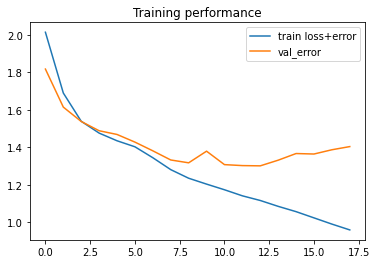

In [19]:
# Show loss curves 
plt.figure()
plt.title('Training performance')
plt.plot(history.epoch, history.history['loss'], label='train loss+error')
plt.plot(history.epoch, history.history['val_loss'], label='val_error')
plt.legend()

## Confusion matrix

In [20]:
test_Y_predictions = model.predict((iq_test, mp_test), batch_size=BATCH_SIZE)

test_Y_predictions_length = len(test_Y_predictions)
test_Y_onehotted = []

for i in range(0, test_Y_predictions_length - 1):
    # creating a [0...0] vector
    onehotted_prediction = np.zeros(len(classes))
    
    # I have to place a 1 where the probability value is maximum
    onehot_one_index = np.argmax(test_Y_predictions[i])
    onehotted_prediction[onehot_one_index] = 1
    
    test_Y_onehotted.append(onehotted_prediction)

In [21]:
# 11x11 zeros matrix
confusion_matrix = np.zeros((len(classes), len(classes)))

# row = true label, column = predicted label

for i in range(0, test_Y_predictions_length - 1):
    true_label_index = np.argmax(Y_test[i])
    predicted_label_index = np.argmax(test_Y_onehotted[i])
    
    confusion_matrix[true_label_index][predicted_label_index] += 1

softmaxed_confusion_matrix = np.zeros((len(classes), len(classes)))
    
# softmax each confusion matrix row
for i in range(0, len(classes)):
    vector_sum = np.sum(confusion_matrix[i])
    
    for j in range(0, len(confusion_matrix[i]) - 1):
        softmaxed_confusion_matrix[i][j] += round(confusion_matrix[i][j]/vector_sum, 2)

In [22]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

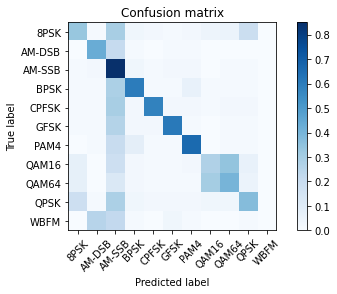

In [23]:
plot_confusion_matrix(softmaxed_confusion_matrix, labels=classes)

## Confusion matrix for each SNR

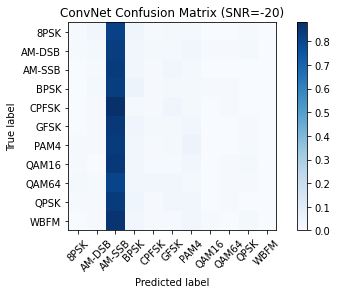

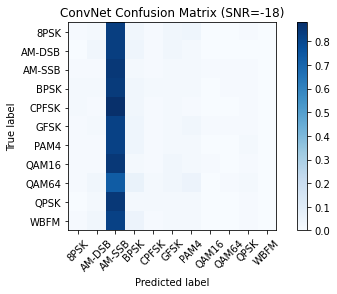

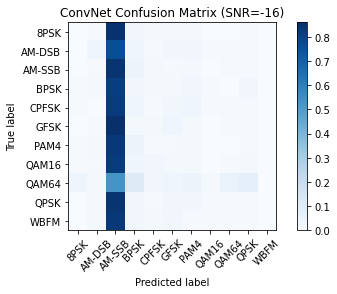

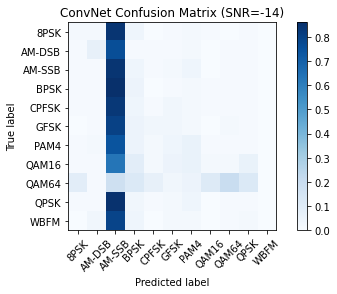

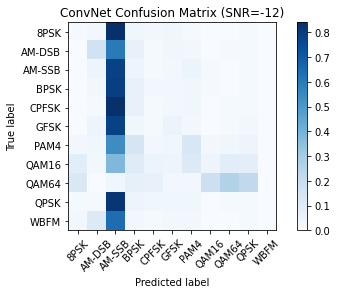

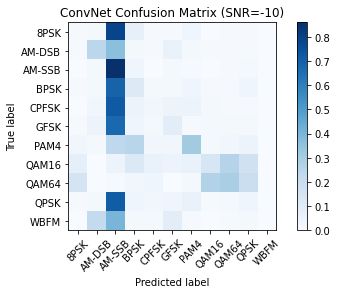

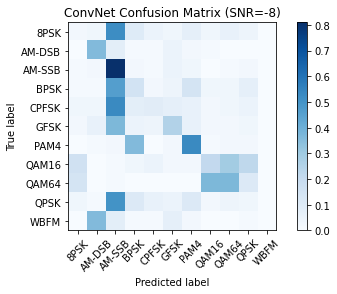

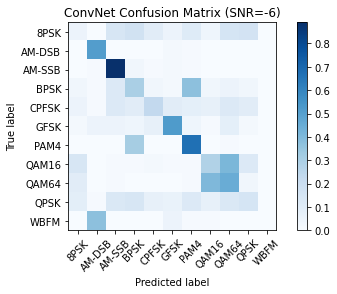

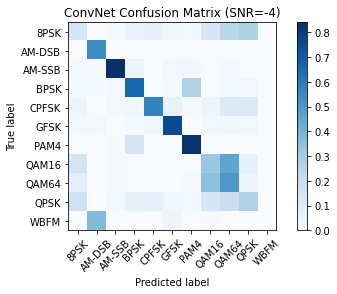

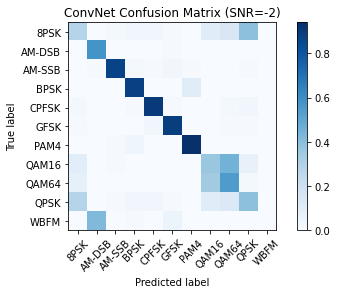

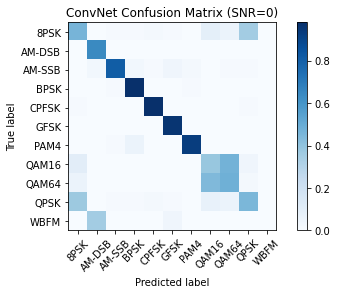

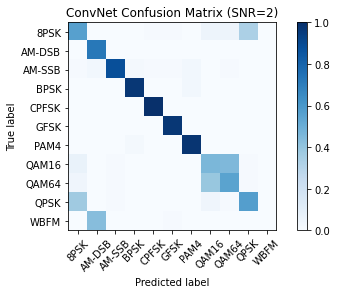

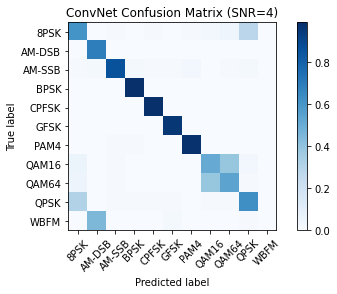

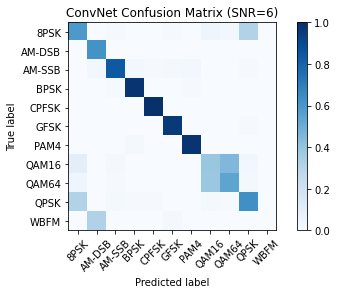

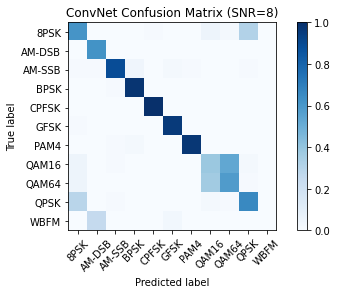

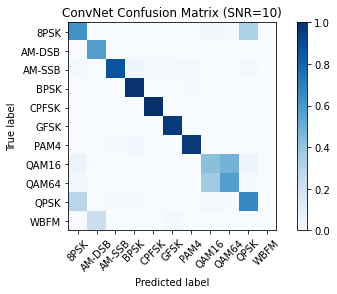

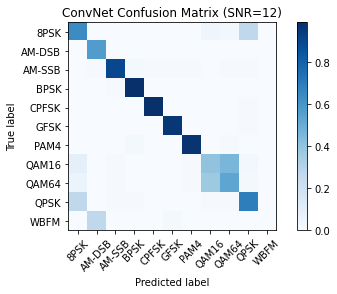

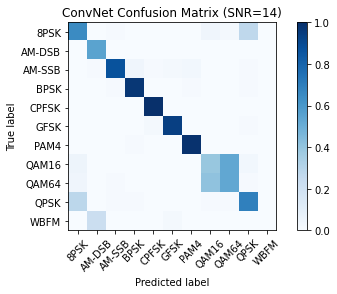

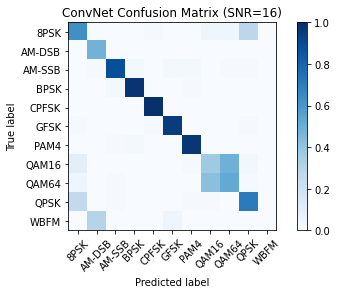

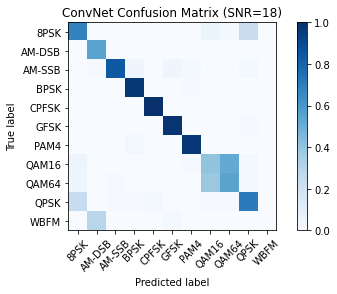

In [24]:
import math

# Plot confusion matrix
acc = {}

for snr in snrs:

    # extract classes @ SNR
    test_SNRs = list(dataset_df[snr_column_dataframe_name][test_index])
    this_snr_indexes = np.where(np.array(test_SNRs) == snr)
        
    test_X_i = (iq_test[this_snr_indexes], mp_test[this_snr_indexes])
    test_Y_i = Y_test[this_snr_indexes]
        
    # estimate classes
    test_Y_predictions = model.predict(test_X_i, batch_size=BATCH_SIZE)
    
    test_Y_predictions_length = len(test_Y_predictions)
    test_Y_onehotted = []
    
    for i in range(0, test_Y_predictions_length - 1):
        # creating a [0...0] vector
        onehotted_prediction = np.zeros(len(classes))

        # I have to place a 1 where the probability value is maximum
        onehot_one_index = np.argmax(test_Y_predictions[i])
        onehotted_prediction[onehot_one_index] = 1

        test_Y_onehotted.append(onehotted_prediction)
            
    # 11x11 zeros matrix
    confusion_matrix = np.zeros((len(classes), len(classes)))

    # row = true label, column = predicted label

    for i in range(0, test_Y_predictions_length - 1):
        true_label_index = np.argmax(test_Y_i[i])
        predicted_label_index = np.argmax(test_Y_onehotted[i])

        confusion_matrix[true_label_index][predicted_label_index] += 1

    softmaxed_confusion_matrix = np.zeros((len(classes), len(classes)))
    
    # softmax each confusion matrix row
    for i in range(0, len(classes)):
        vector_sum = np.sum(confusion_matrix[i])

        for j in range(0, len(confusion_matrix[i]) - 1):
            perc = confusion_matrix[i][j] / vector_sum
            softmaxed_confusion_matrix[i][j] += round(perc, 2)
    
    plt.figure()
    plot_confusion_matrix(softmaxed_confusion_matrix, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))
    
    well_predicted = np.sum(np.diag(confusion_matrix))
    all_predictions = np.sum(confusion_matrix)
    
    acc[snr] = well_predicted / all_predictions

## Accuracy performance

In [25]:
accuracy_perc = {}
for el in acc.items():
    accuracy_perc[el[0]] = int(el[1] * 100)
    
accuracy_df = pd.DataFrame(data=accuracy_perc, index=["Accuracy %"])
# accuracy_df.columns = ["SNRs", "Accuracy"]
accuracy_df

,-20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18
Accuracy %,9,8,10,13,15,21,29,42,54,64,69,74,75,74,76,75,75,75,73,75


In [26]:
# Save results to a pickle file for plotting later
fd = open(OUTPUT_FILENAME,'wb')
pickle.dump( ("CNN2", 0.5, acc) , fd )

Text(0.5, 1.0, 'CNN2 Classification Accuracy on RadioML 2016.10 Alpha')

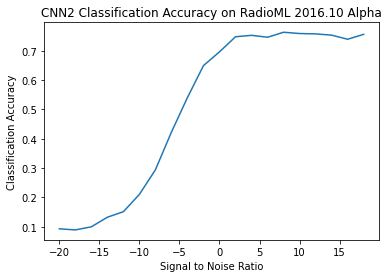

In [27]:
# Plot accuracy curve
plt.plot(snrs, list(map(lambda x: acc[x], snrs)))
plt.xlabel("Signal to Noise Ratio")
plt.ylabel("Classification Accuracy")
plt.title("CNN2 Classification Accuracy on RadioML 2016.10 Alpha")